In [25]:
# import pyforest
import pandas as pd
import numpy as np
import seaborn as sns

In [26]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
import pickle
import warnings
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
# !pip install scikit-learn==1.2.2

In [27]:
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
# numpy: 1.23.1
# sklearn: 1.3.2

numpy: 1.23.1


<IPython.core.display.Javascript object>

sklearn: 1.3.2


In [28]:
def get_tree_probabilities(model, x_data): 
    test_proba0_df = pd.DataFrame()
    test_proba1_df = pd.DataFrame()
    for tree_num in np.arange(len(model.estimators_)):
        test_proba_temp = model.estimators_[tree_num].predict_proba(x_data)
        # print(f'tree_num: {tree_num}, test_proba_temp shape: {test_proba_temp.shape}')
        test_proba0_df[tree_num] = test_proba_temp[:,0]
        test_proba1_df[tree_num] = test_proba_temp[:,1]
        # print(f'test_proba0_df shape: {test_proba0_df.shape}, test_proba1_df shape: {test_proba1_df.shape}')
    std0 = test_proba0_df.std(axis=1)
    std1 = test_proba1_df.std(axis=1)

    # print(f'in df tree prob function. std0 shape: {std0.shape}, std1 shape: {std1.shape}')
    return std0, std1

In [29]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis-train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [30]:
nanobret_RF='/Users/jayceepang/msse/ATOM_CODE/examples/holdout/holdout_results/jp_holdout_summer2025/RF2?/'
nanobret_GP='/Users/jayceepang/msse/ATOM_CODE/examples/holdout/holdout_results/jp_holdout_summer2025/GP/'
datapath='/Users/jayceepang/msse/ATOM_CODE/datasets/holdout_data/featurized/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
og_datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
samplings =['none_scaled','UNDER','SMOTE'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']
model_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'
remove_cols = ['NEK', 'compound_id', 'base_rdkit_smiles', 'active', 'subset'] 
og_rf_results_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'
og_gp_results_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/GP_results/'

In [31]:
def get_plotting_data_RF_UQ2(model, train_df, test_df): 
    test_dist = calc_AD_kmean_dist(train_df, test_df, k=7)
    train_dist = calc_AD_kmean_dist(train_df, train_df, k=7)
    std0, std1=get_tree_probabilities(model, test_df)
    return train_dist, test_dist, std0, std1
 

In [8]:
def get_plotting_data_GP_UQ2(train_df, test_df,results_df): 
    test_dist = calc_AD_kmean_dist(train_df, test_df, k=7)
    train_dist = calc_AD_kmean_dist(train_df, train_df, k=7)
    results_df=results_df.rename(columns={'y_pred':'prediction', 'var_pred_class0': 'var0', 'var_pred_class1': 'var1'})
    results_df['prediction_type'] = results_df.apply(lambda x: prediction_type(x['y'], x['prediction']), axis=1)
    results_df['ADdist'] = test_dist
    results_df['1-specificity'] = 1-results_df['specificity'] 
    
    return test_dist, results_df
 
 

In [9]:
def prediction_type(y_true, y_pred): 
    if (y_true == 0 and y_pred == 0): 
        return 'TN'
    elif (y_true == 0 and y_pred == 1): 
        return 'FP'
    elif (y_true == 1 and y_pred ==0): 
        return 'FN'
    elif (y_true == 1 and y_pred ==1): 
        return 'TP'
    else: 
        return 'error'

In [10]:
# pred_markers = {'TP': 'o','TN': 's', 'FP': '^', 'FN': 'D'}
pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 150, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}
sampling_combos = [('none_scaled','RF'),('none_scaled','RF_BCW'),('SMOTE','RF'), 
    ('none_scaled','BRFC'),('none_scaled','BRFC_BCW'),('UNDER','RF')]
# name_strat_lookup={'none_scaled': 'no_samp', 'RF': 'RF', 'RF_BCW': 'RF_BalWeight', 'BRFC': 'Bstrp Under', 'BRFC_BCW':'Bstrp Under BalWeight',
#                   'ADASYN': 'ADASYN', 'SMOTE':'SMOTE', 'UNDER':'UNDER'}
name_strat_lookup={'none_scaled': 'Orig', 'RF': 'RF', 'RF_BCW': 'RF BalWeight', 'BRFC': 'Bstrp Under RF', 'BRFC_BCW':'Bstrp Under RF BalWeight',
                  'ADASYN': 'ADASYN', 'SMOTE':'SMOTE', 'UNDER':'UNDER'}

In [11]:
def RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax):
    predictions = df['prediction']
    ad_dist=df['ADdist']
    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    fn_std0 = std0[false_neg] # NEW MAR 29 2025
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]

    data = {'std of probabilities': np.concatenate([tp_std1,tn_std0,fp_std1, fn_std0]),
        'prediction_type': ['TP'] * len(true_pos) + ['TN'] * len(true_neg) + ['FP'] * len(false_pos) + ['FN'] * len(false_neg),
        'ADdist': np.concatenate([tp_ad, tn_ad, fp_ad,fn_ad])}
    data = pd.DataFrame(data)
    sizes = data['prediction_type'].map(pred_sizes)
    # 
    sns.scatterplot(data=data, x='ADdist', y='std of probabilities', hue='prediction_type', palette=pred_palette,
           markers=pred_markers,style='prediction_type',ax=ax,s=120,alpha=0.75)
    ax.set_title(title, fontsize=19)
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    # ax.set_ylabel('SD of probability', fontsize=15)
    ax.set_ylabel('')
    ax.set_ylim(-0.01, 0.51)
    ax.set_xlim(-.30,10) 

In [34]:
pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 100, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}
def GP_scatter_varpred_AD_sbuplots(df,ax, ylabel_on=True,figure_path=None, filename=None):
    true_labels = df['y'] 
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    df['prediction variance'] = np.nan
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    feat=df['feat_type'].iloc[0]
    samp=df['strategy'].iloc[0]
    sizes = df['prediction_type'].map(pred_sizes)

    sns.scatterplot(data=df, x='ADdist', y='prediction variance', hue='prediction_type', palette=pred_palette,
           markers=pred_markers, style='prediction_type',ax=ax,s=120,alpha=0.75)
    # samp_label=f'{df["feat_type"].iloc[0]} {df["strategy"].iloc[0]}'
    
    samp_label=f'GP Matern {df["strategy"].iloc[0]}'
    if df["strategy"].iloc[0] == 'none_scaled': 
        samp_label=f'GP Matern Orig'
    title = f'{samp_label}\n1-specificity: {df["1-specificity"].iloc[0]:.2f}, sensitivity: {df["recall"].iloc[0]:.2f}'
    ax.set_title(f'{title}',fontsize=16)
    ax.set_yticks(np.arange(0,9, step=1))
    ax.get_legend().remove()
    ax.set_xlabel('ADdist', fontsize=16)
    if ylabel_on: 
        ax.set_ylabel('Predictive Variance', fontsize=16)
    else: 
        ax.set_ylabel('', fontsize=16)
        
    ax.set_ylim(-0.1, 9)
    ax.set_xlim(-.30,10) 




In [35]:
def change_names(df): 
    df['strategy']=df['strategy'].replace('none_scaled', 'no_samp') 
    df['RF_type']=df['RF_type'].replace('BRFC', 'Bstrp Under RF') 
    df['RF_type']=df['RF_type'].replace('BRFC_BCW', 'Bstrp Under RF + BalWeight') 
    df['RF_type'] = df['RF_type'].replace('RF_BCW','RF_BalWeight')
    return df
    

In [36]:
neks

['NEK2_binding',
 'NEK2_inhibition',
 'NEK3_binding',
 'NEK5_binding',
 'NEK9_binding',
 'NEK9_inhibition']

In [ ]:
for nek in neks:
    short_nek = nek[:4] 
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    fig.suptitle(f'{nek} SD of Probability vs. ADI (MFP) (Nanobret)', fontsize=22,y=0.94)

    plt.subplots_adjust(hspace=.5)
    count=0
    test_df = pd.read_csv(f'{datapath}{short_nek}_MFP_none_unscaled.csv').drop(columns=remove_cols)
    for count, (samp,rf) in enumerate(sampling_combos):
        row = count//3
        col = count%3
        ax =axes[row,col]
        count += 1
        root_name = f'{nek}_MFP_{samp}'
        rf_results_df = pd.read_csv(f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv')
        og_df = pd.read_csv(f'{og_datapath}{nek}_MFP_{samp}.csv') 
        train_df = og_df[og_df['subset'] == 'train'].drop(columns=remove_cols)
        with open(f'{model_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
            model = pickle.load(f) 
        train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ2(model, train_df, test_df)
        rf_results_df['1-specificity'] = 1-rf_results_df['specificity'] 
        true_labels =rf_results_df['y'].to_numpy()
        results_df=change_names(rf_results_df)
        
        df = pd.DataFrame({'prediction': rf_results_df['prediction'],'std0': std0,'std1': std1,'ADdist': test_dist,
            'feat_type': rf_results_df['feat_type'], 'sensitivity':rf_results_df['recall'], '1-specificity': rf_results_df['1-specificity']})
        samp_label=f'{name_strat_lookup[samp]} {name_strat_lookup[rf]}'
        title = (f'{samp_label}\n'
            f'1-specificity: {rf_results_df["1-specificity"].iloc[0]:.2f}, '
            f'sensitivity: {rf_results_df["recall"].iloc[0]:.2f}')
        RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax)
        if col == 0:
            ax.set_ylabel('Std of probability', fontsize=14)
     

    for col, samp2 in enumerate(['none_scaled','UNDER','SMOTE']):
        ax = axes[2, col]
        gp_results_df = pd.read_csv(f'{nanobret_GP}{short_nek}_MFP_none_scaled_{nek}_{samp2}_GP_matern_nanobret_cellular_holdout.csv')

        gp_test_dist, gp_results_df=get_plotting_data_GP_UQ2(train_df, test_df, gp_results_df)
        GP_scatter_varpred_AD_sbuplots(gp_results_df,ax, ylabel_on=False)
        if col == 0:
            ax.set_ylabel('Prediction Variance', fontsize=14)
    
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    fig.savefig(f'{nek}_RFGP_nanobret_UQ_scatter.png', bbox_inches='tight')

In [37]:
samp_palette={'no_samp': 'tab:blue','UNDER': 'tab:orange','SMOTE': 'hotpink','ADASYN': 'tab:red',
 'no_sampling_RF': 'cornflowerblue','no_sampling_RF_BCW': 'lavender','UNDER_RF': 'orange','no_sampling_BRFC': 'blue',
 'SMOTE_RF': 'hotpink','ADASYN_RF': 'red','no_samp_BRFC_BCW': 'black',
 'no_sampling_BRFC_BCW': 'black','no_sampling_GP_RBF': 'cornflowerblue',
 'UNDER_GP_RBF': 'orange','SMOTE_GP_RBF': 'hotpink','ADASYN_GP_RBF': 'red','no_sampling_GP_matern': 'cornflowerblue',
 'UNDER_GP_matern': 'orange','SMOTE_GP_matern': 'hotpink','ADASYN_GP_matern': 'red',
 'no_samp_Bstrp Under':'blue', 'no_samp_RF':'cornflowerblue', 
    'no_samp_Bstrp Under BalWeight':'black', 'no_samp_RF_BalWeight':'lavender'}

In [38]:
set_markers = {'nanobret': 's', 'test': 'o'}
gp_cols = ['mean_pred_class0', 'mean_pred_class1', 'y', 'prediction', 'var0',
       'var1', 'pred_prob_class0', 'pred_prob_class1', 'pred_prob_std_class0',
       'pred_prob_std_class1', 'subset', 'accuracy', 'precision', 'recall',
       'specificity', 'f1', 'ROC_AUC', 'MCC', 'balanced_accuracy', 'cm', 'TN',
       'FN', 'FP', 'TP', 'model', 'NEK',
       'feat_type', 'strategy','1-specificity',
       'prediction_type', 'ADdist', 'set']

In [57]:
def RF_scatter_stdprob_AD_sbuplots_SETS(df, title, ax, palette=pred_palette):
    predictions = df['prediction'].to_numpy()
    true_labels = df['y'].to_numpy()
    std0 = df['std0'].to_numpy()
    std1 = df['std1'].to_numpy()
    ad_dist = df['ADdist'].to_numpy()
    set_vals = df['set'].to_numpy()

    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    fn_std0 = std0[false_neg] # NEW MAR 29 2025
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]

    data = {'std of probabilities': np.concatenate([std1[true_pos],std0[true_neg],std1[false_pos],std0[false_neg]]),
        'prediction_type': (['TP'] * len(true_pos) +['TN'] * len(true_neg) +['FP'] * len(false_pos) +['FN'] * len(false_neg)),
        'ADdist': np.concatenate([
            ad_dist[true_pos],ad_dist[true_neg],ad_dist[false_pos],ad_dist[false_neg]]),
        'set': np.concatenate([
            set_vals[true_pos],set_vals[true_neg],
            set_vals[false_pos],set_vals[false_neg]])}
    plot_df = pd.DataFrame(data)

    sns.scatterplot(data=plot_df, x='ADdist', y='std of probabilities', hue='prediction_type', palette=pred_palette,
           style='set',markers=set_markers,ax=ax,s=120,alpha=0.75)
    ax.set_title(title, fontsize=19)
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    # ax.set_ylabel('SD of probability', fontsize=15)
    ax.set_ylabel('')
    ax.set_ylim(-0.01, 0.51)
    ax.set_xlim(-.30,12) 

In [58]:
def GP_scatter_varpred_AD_sbuplots_SETS(df,ax, palette=pred_palette, ylabel_on=True,figure_path=None, filename=None):
    true_labels = df['y'] 
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    df['prediction variance'] = np.nan
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    feat=df['feat_type'].iloc[0]
    samp=df['strategy'].iloc[0]
    sizes = df['prediction_type'].map(pred_sizes)

    sns.scatterplot(data=df, x='ADdist', y='prediction variance', hue='prediction_type', palette=pred_palette,
           style='set',markers=set_markers,ax=ax,s=120,alpha=0.75)
    # samp_label=f'{df["feat_type"].iloc[0]} {df["strategy"].iloc[0]}'
    
    samp_label=f'GP Matern {df["strategy"].iloc[0]}'
    if df["strategy"].iloc[0] == 'none_scaled': 
        samp_label=f'GP Matern Orig'
    title = f'{samp_label}'
    # title = f'{samp_label}\n1-specificity: {df["1-specificity"].iloc[0]:.2f}, sensitivity: {df["recall"].iloc[0]:.2f}'
    ax.set_title(f'{title}',fontsize=19)
    ax.set_yticks(np.arange(0,9, step=1))
    ax.get_legend().remove()
    ax.set_xlabel('ADdist', fontsize=16)
    if ylabel_on: 
        ax.set_ylabel('Predictive Variance', fontsize=16)
    else: 
        ax.set_ylabel('', fontsize=16)
        
    ax.set_ylim(-0.1, 9)
    ax.set_xlim(-.30,12) 




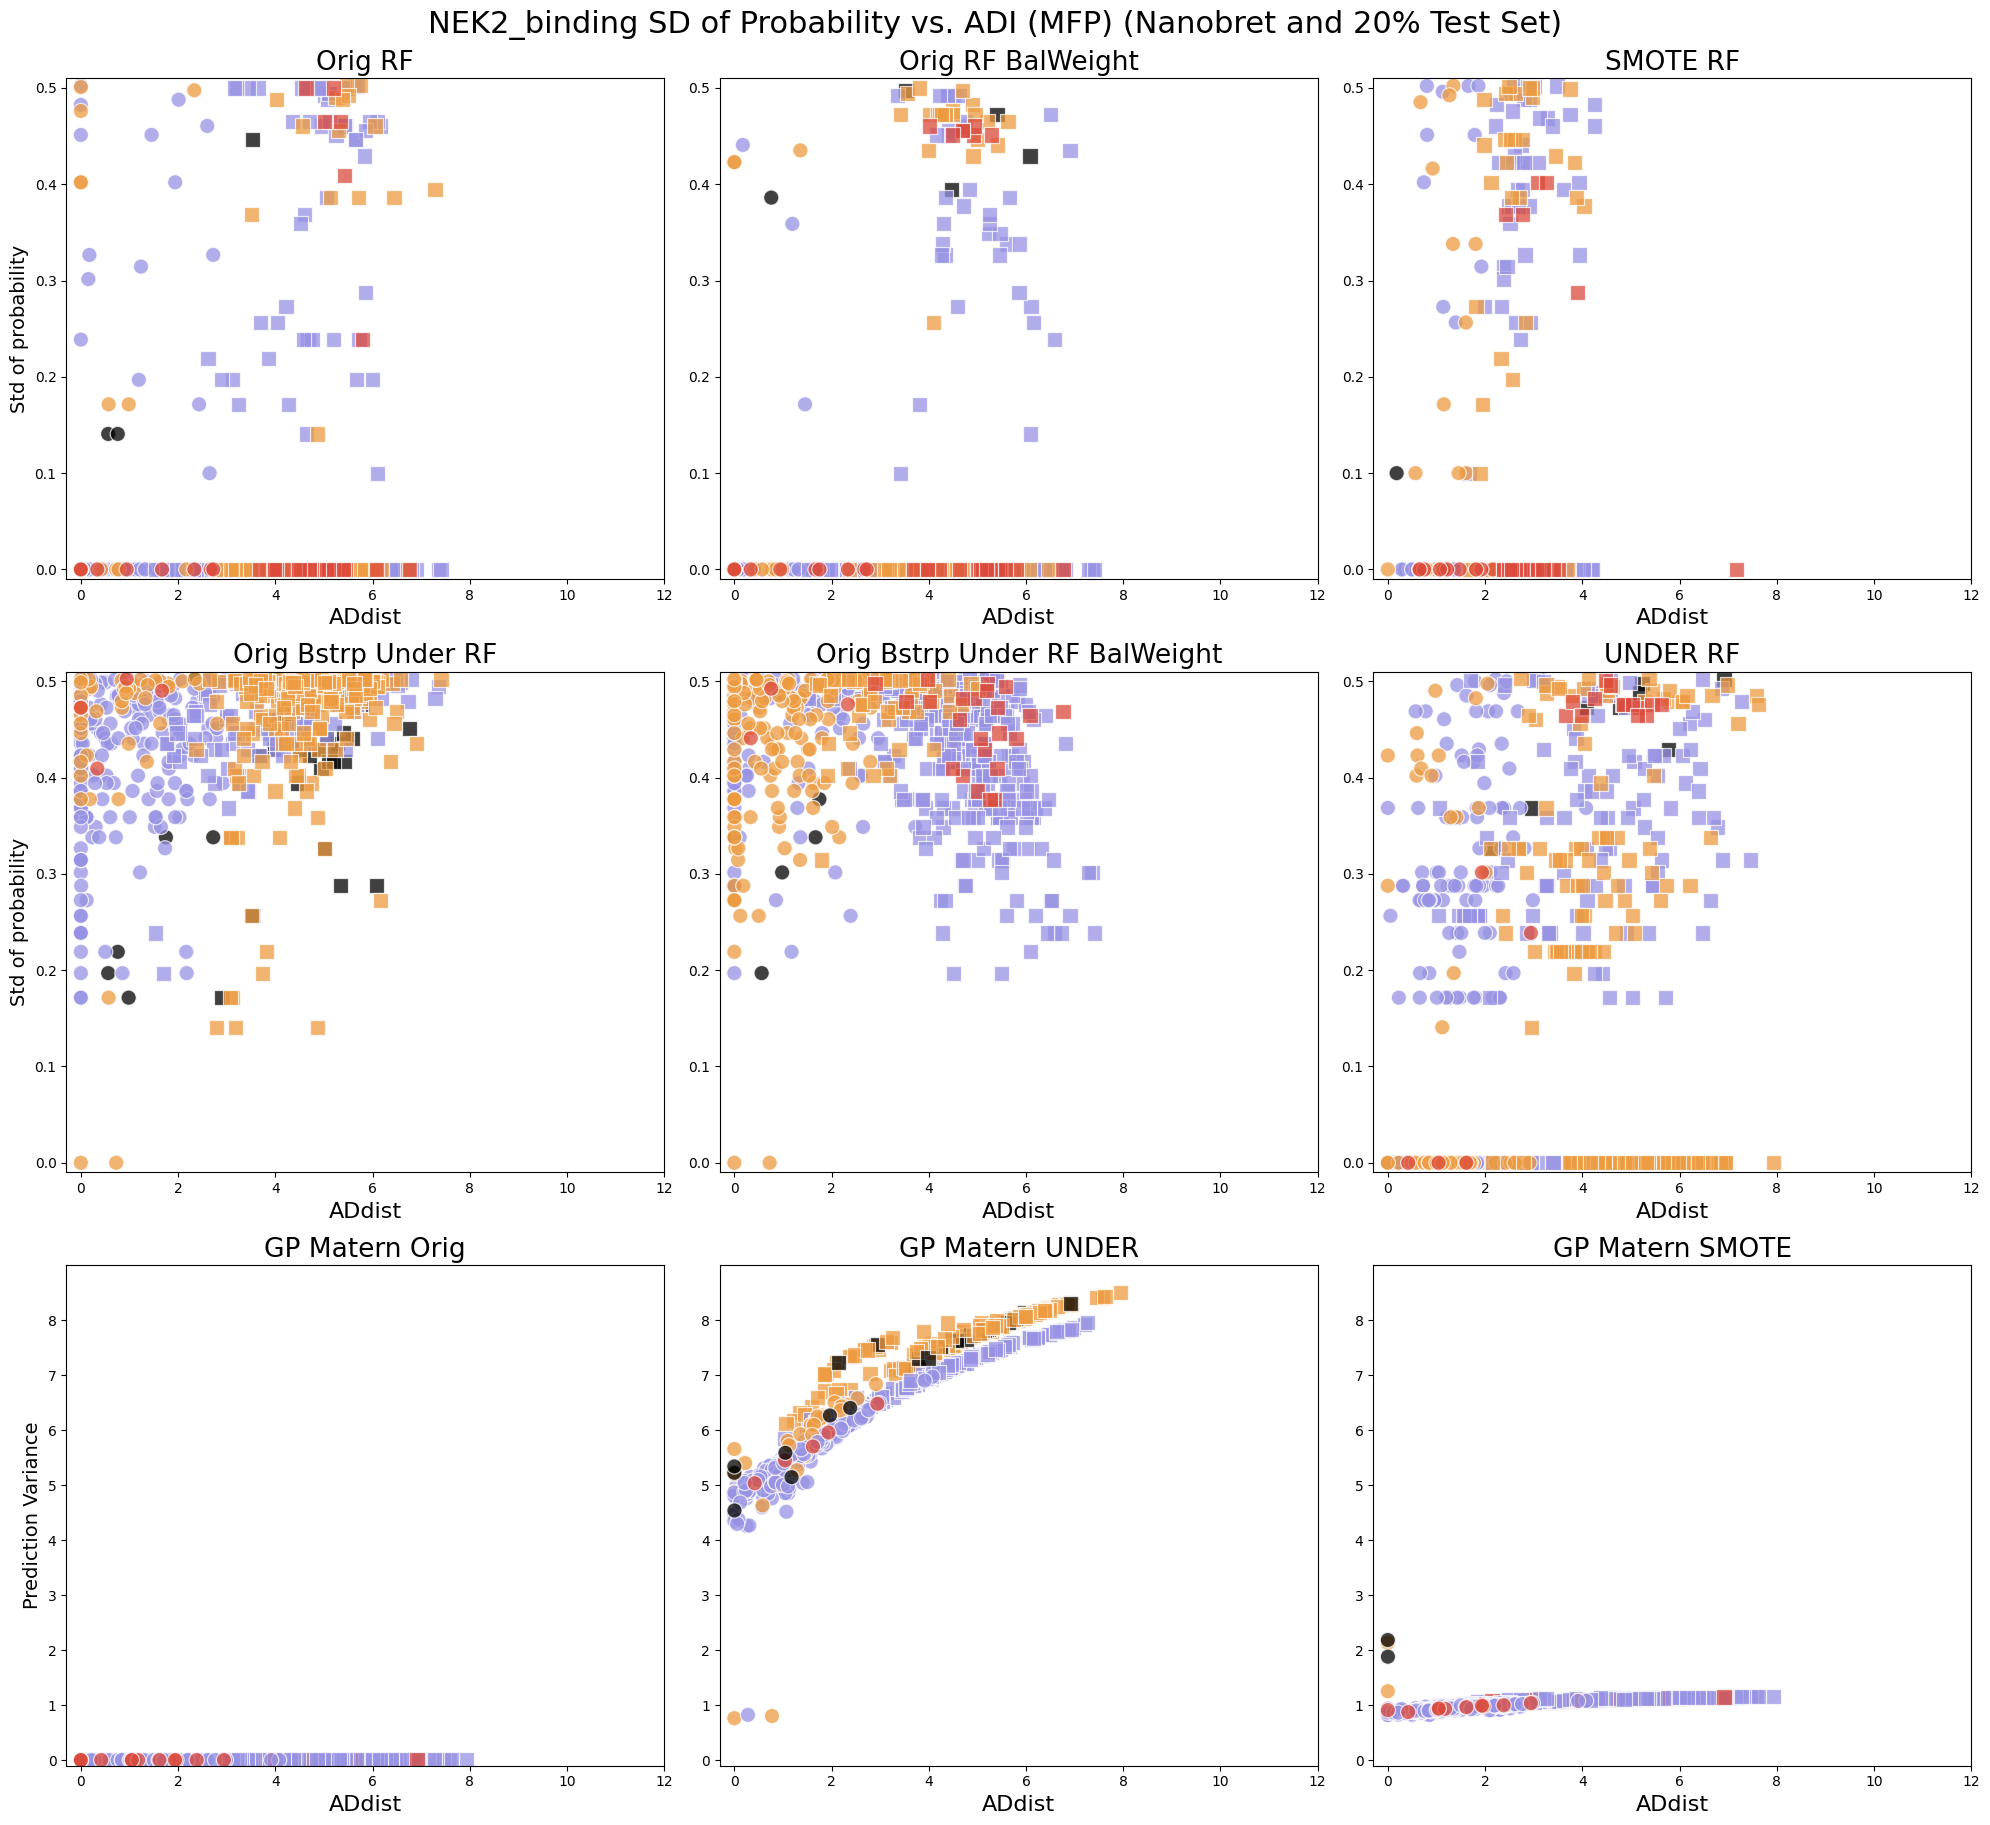

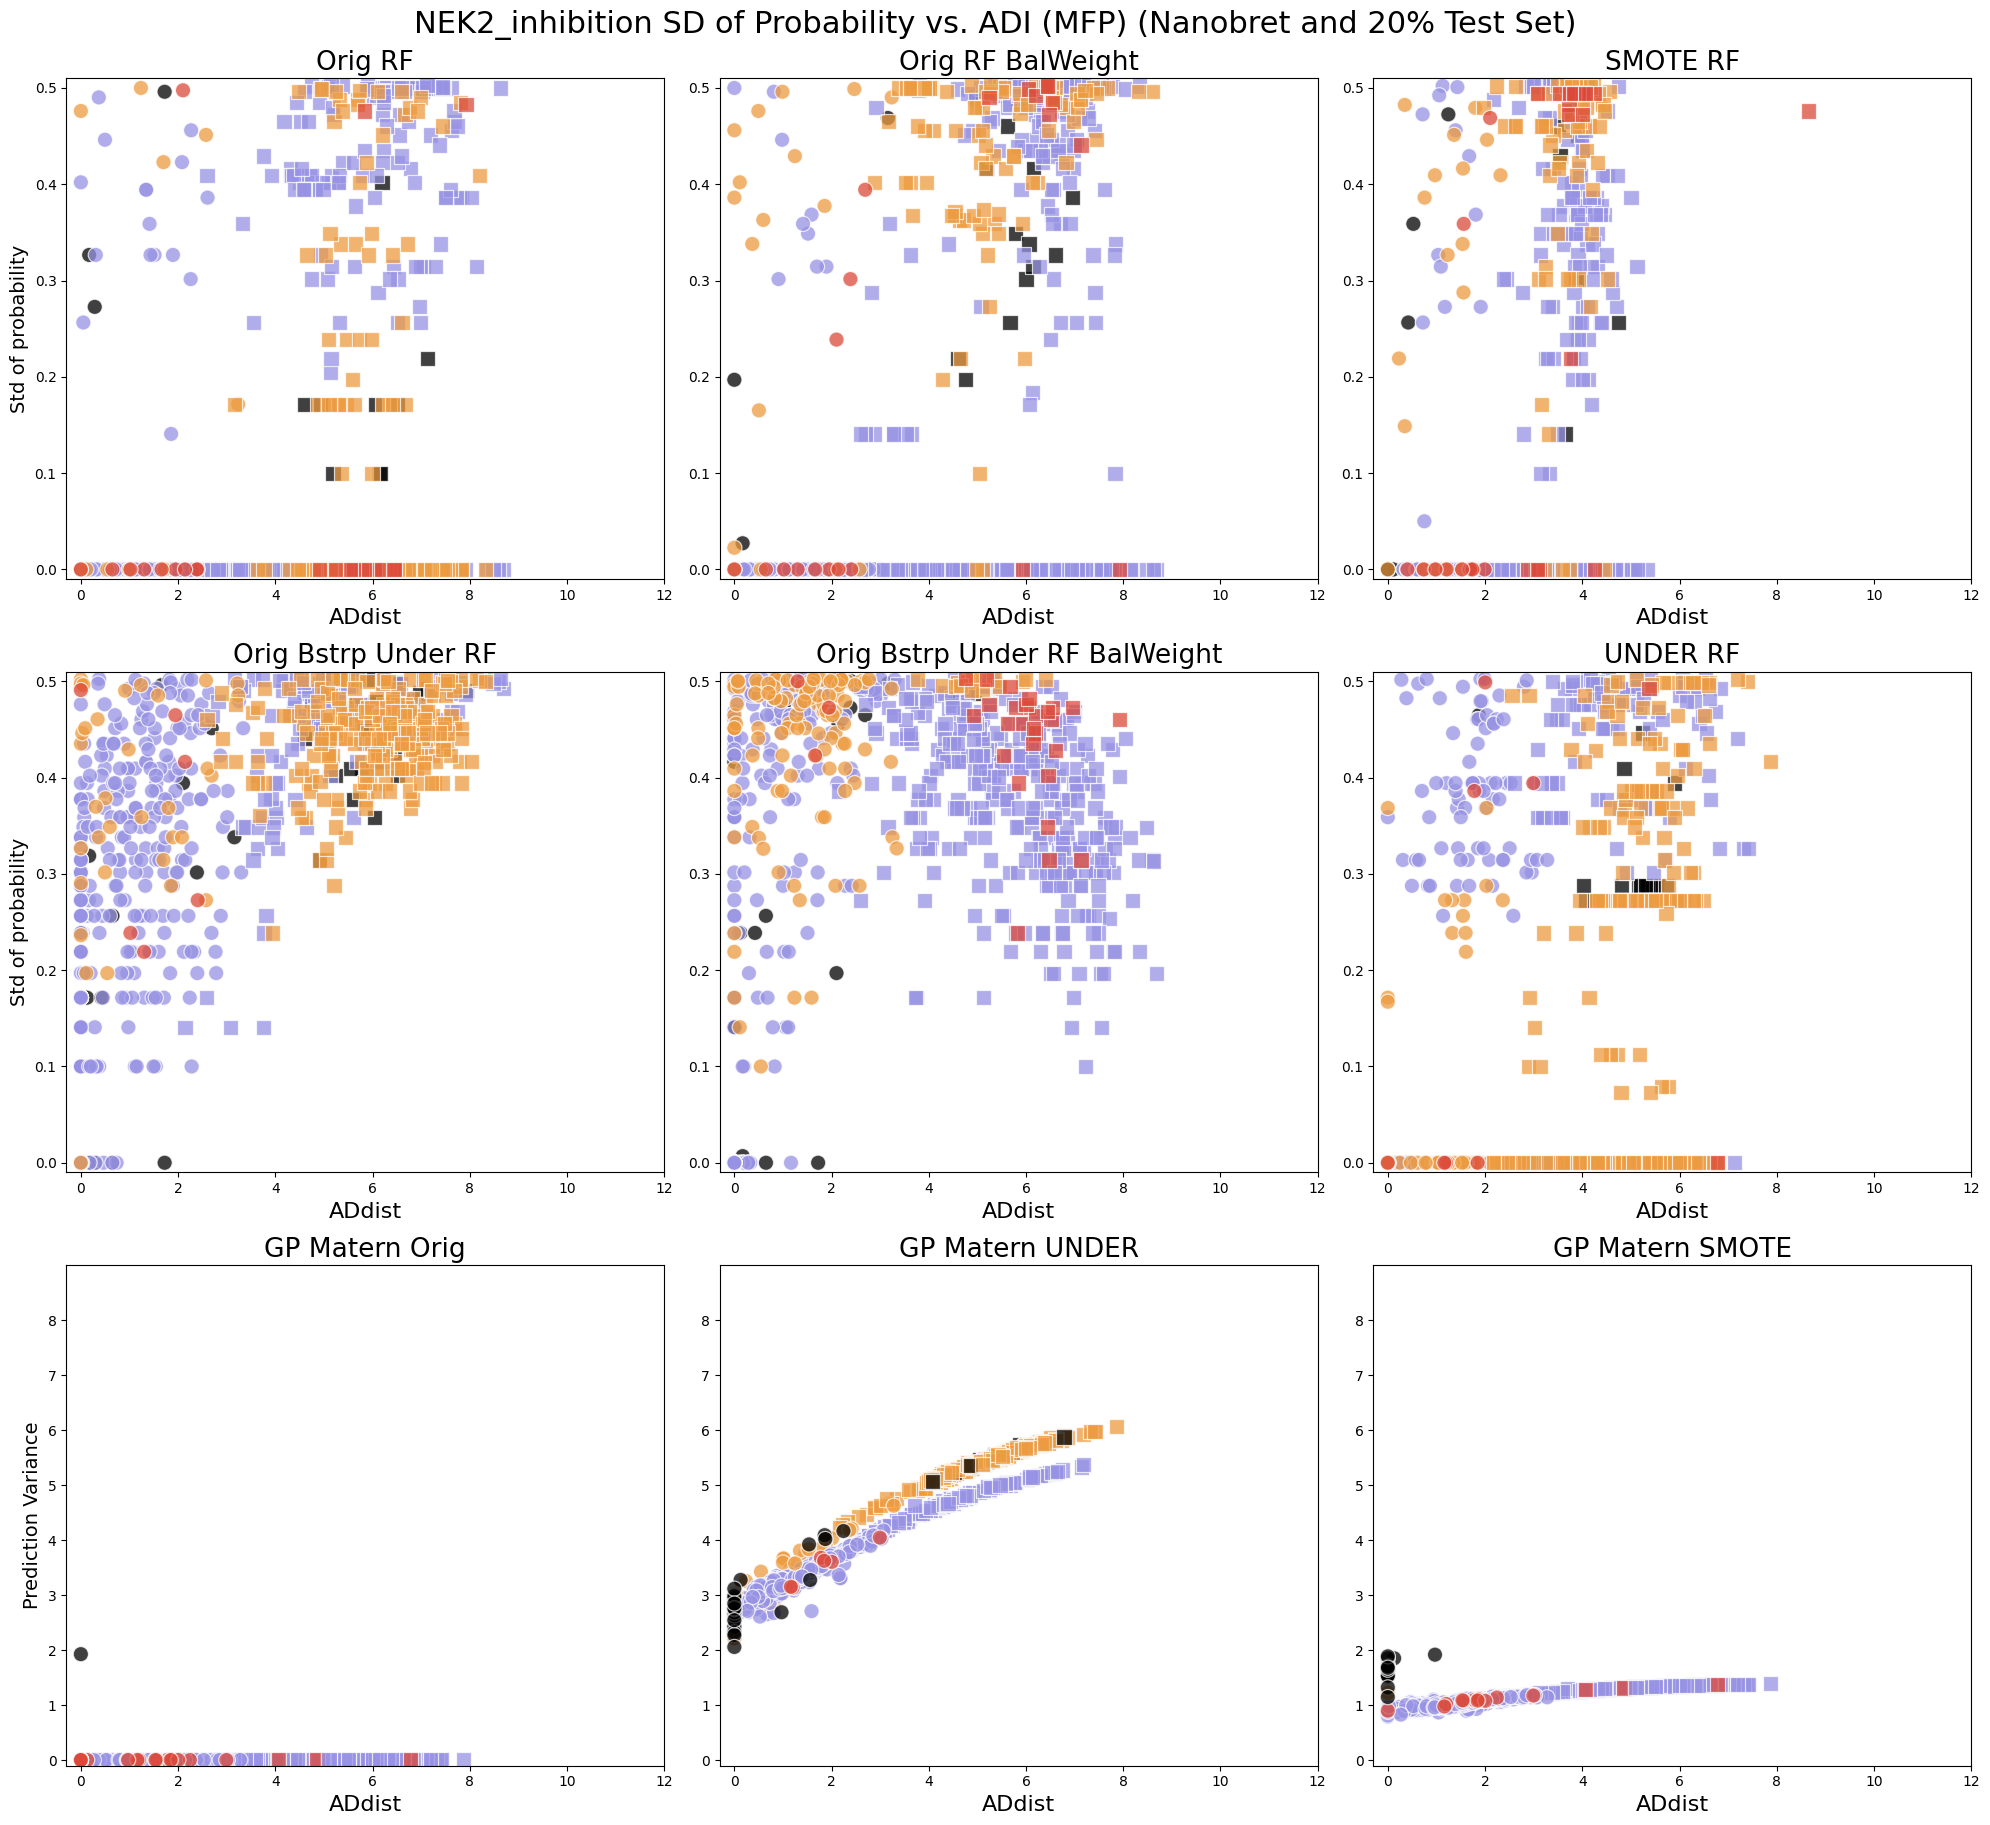

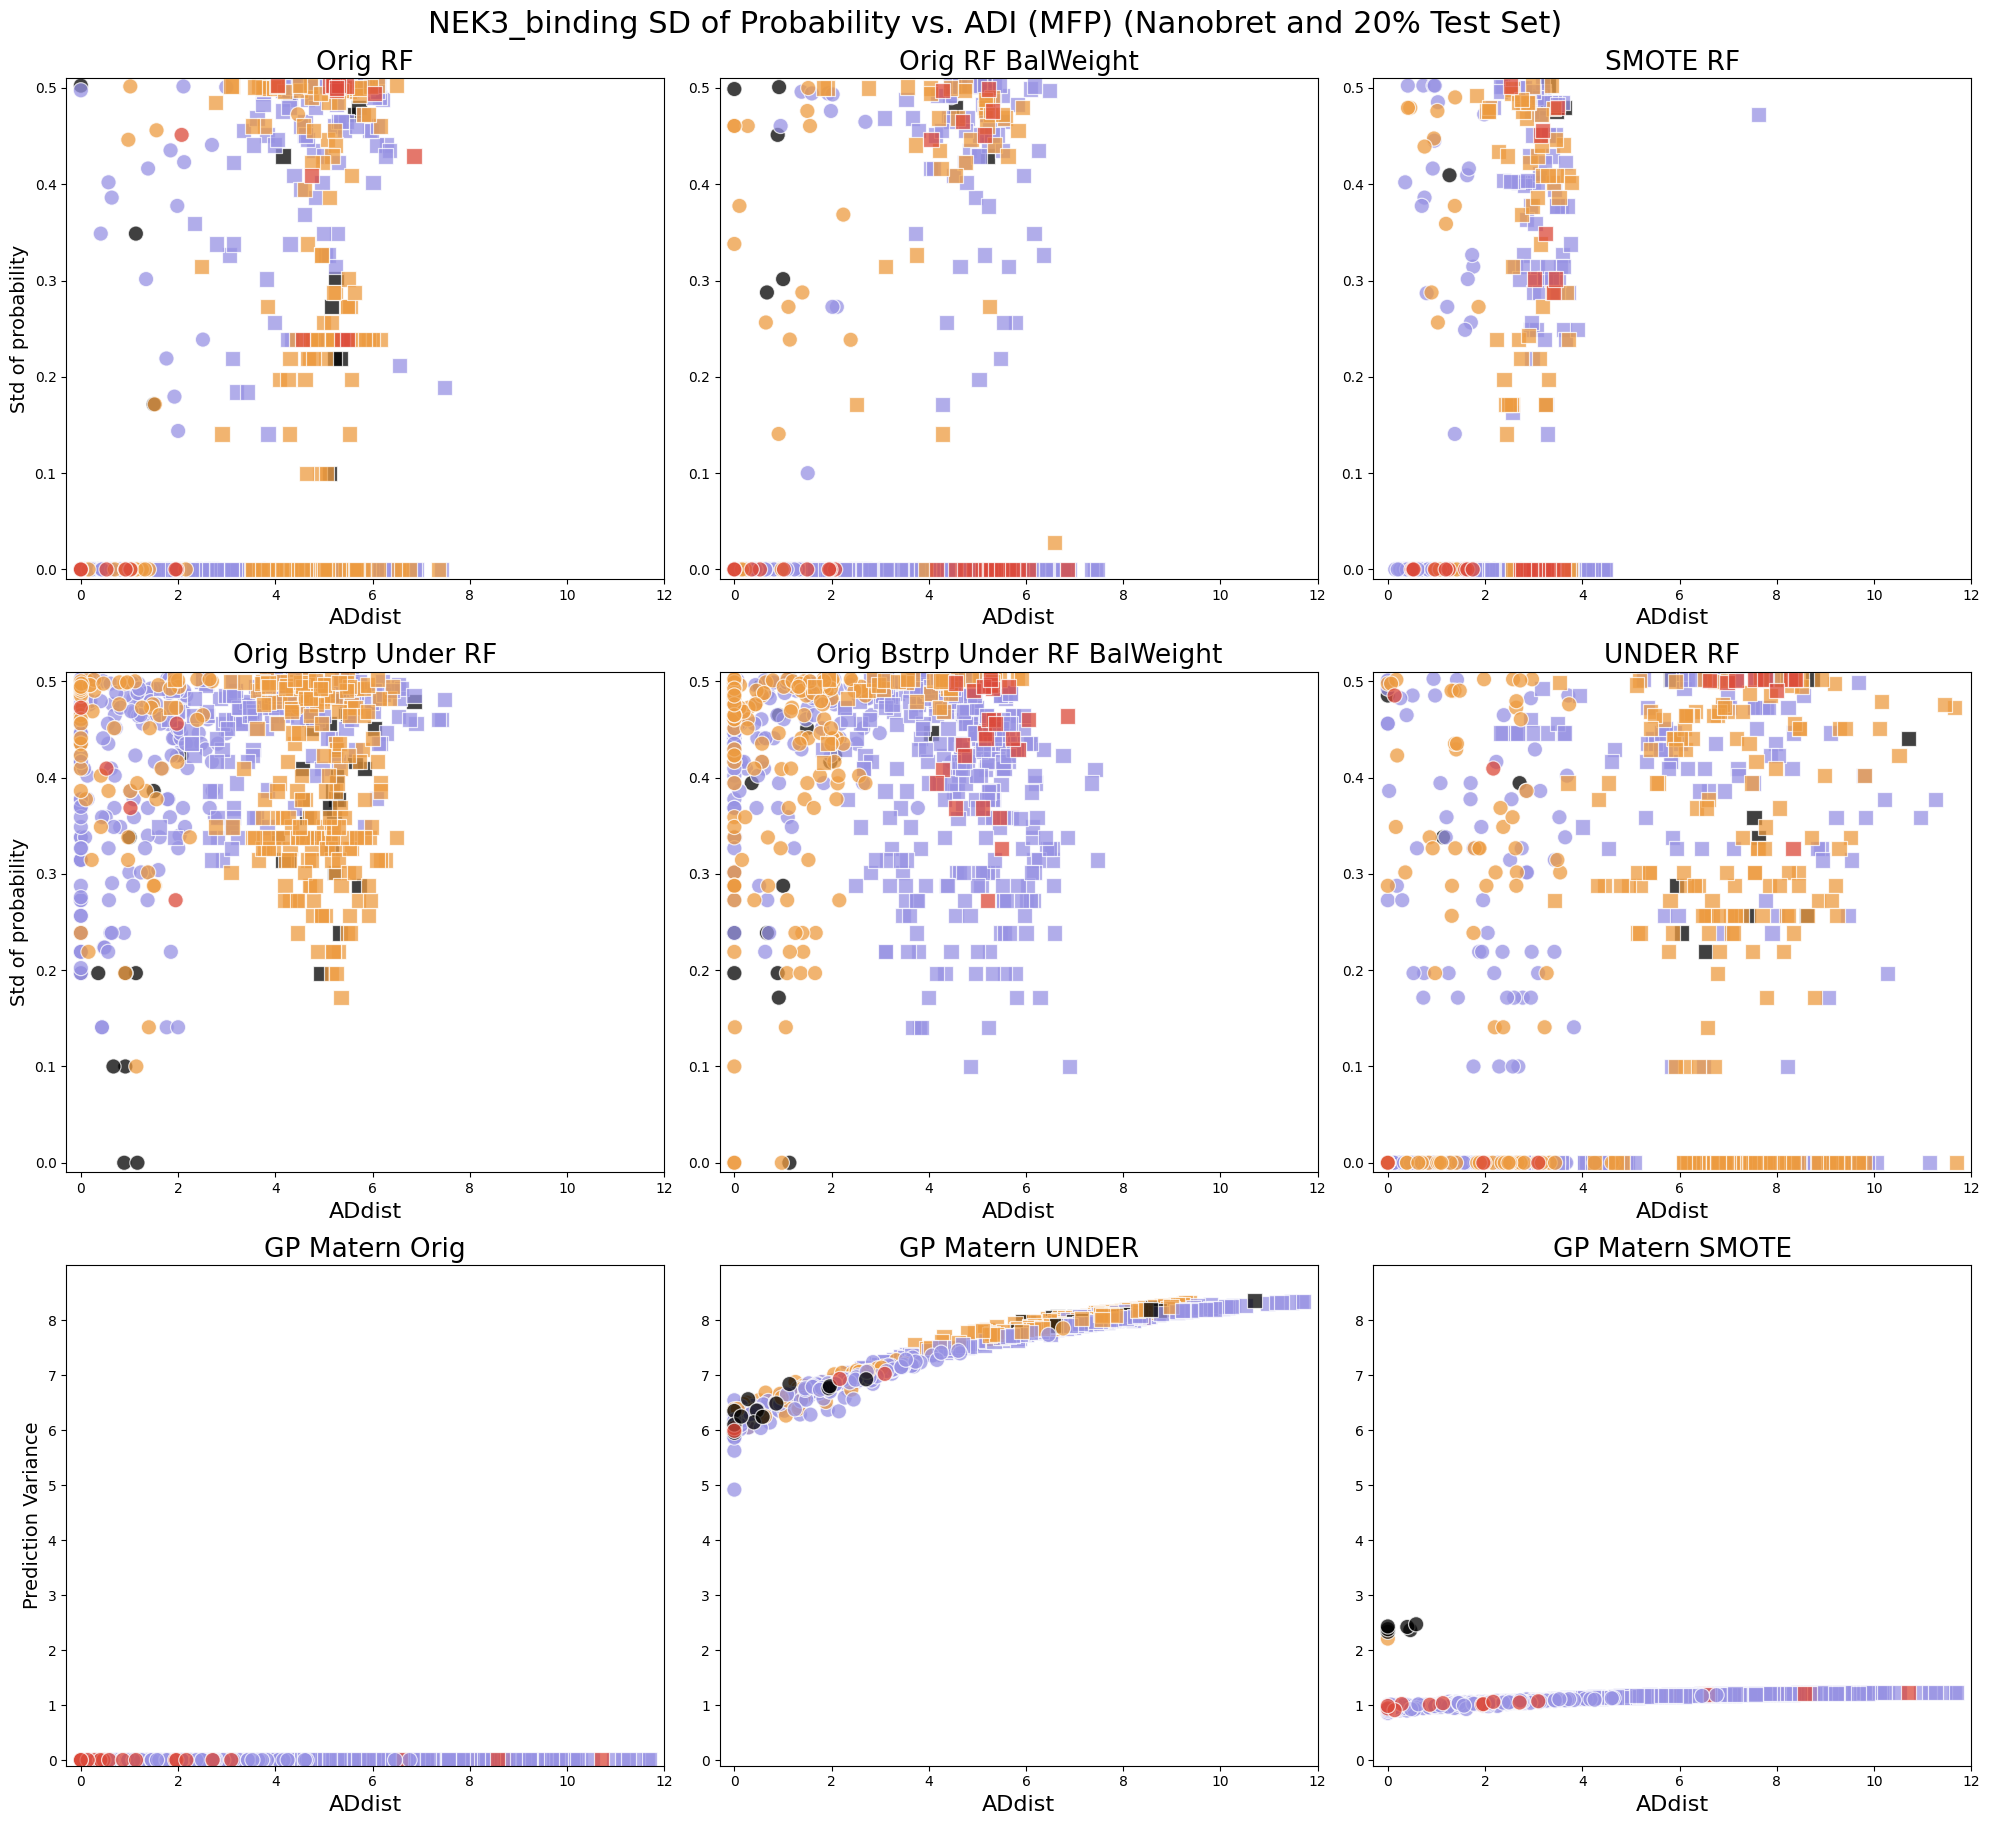

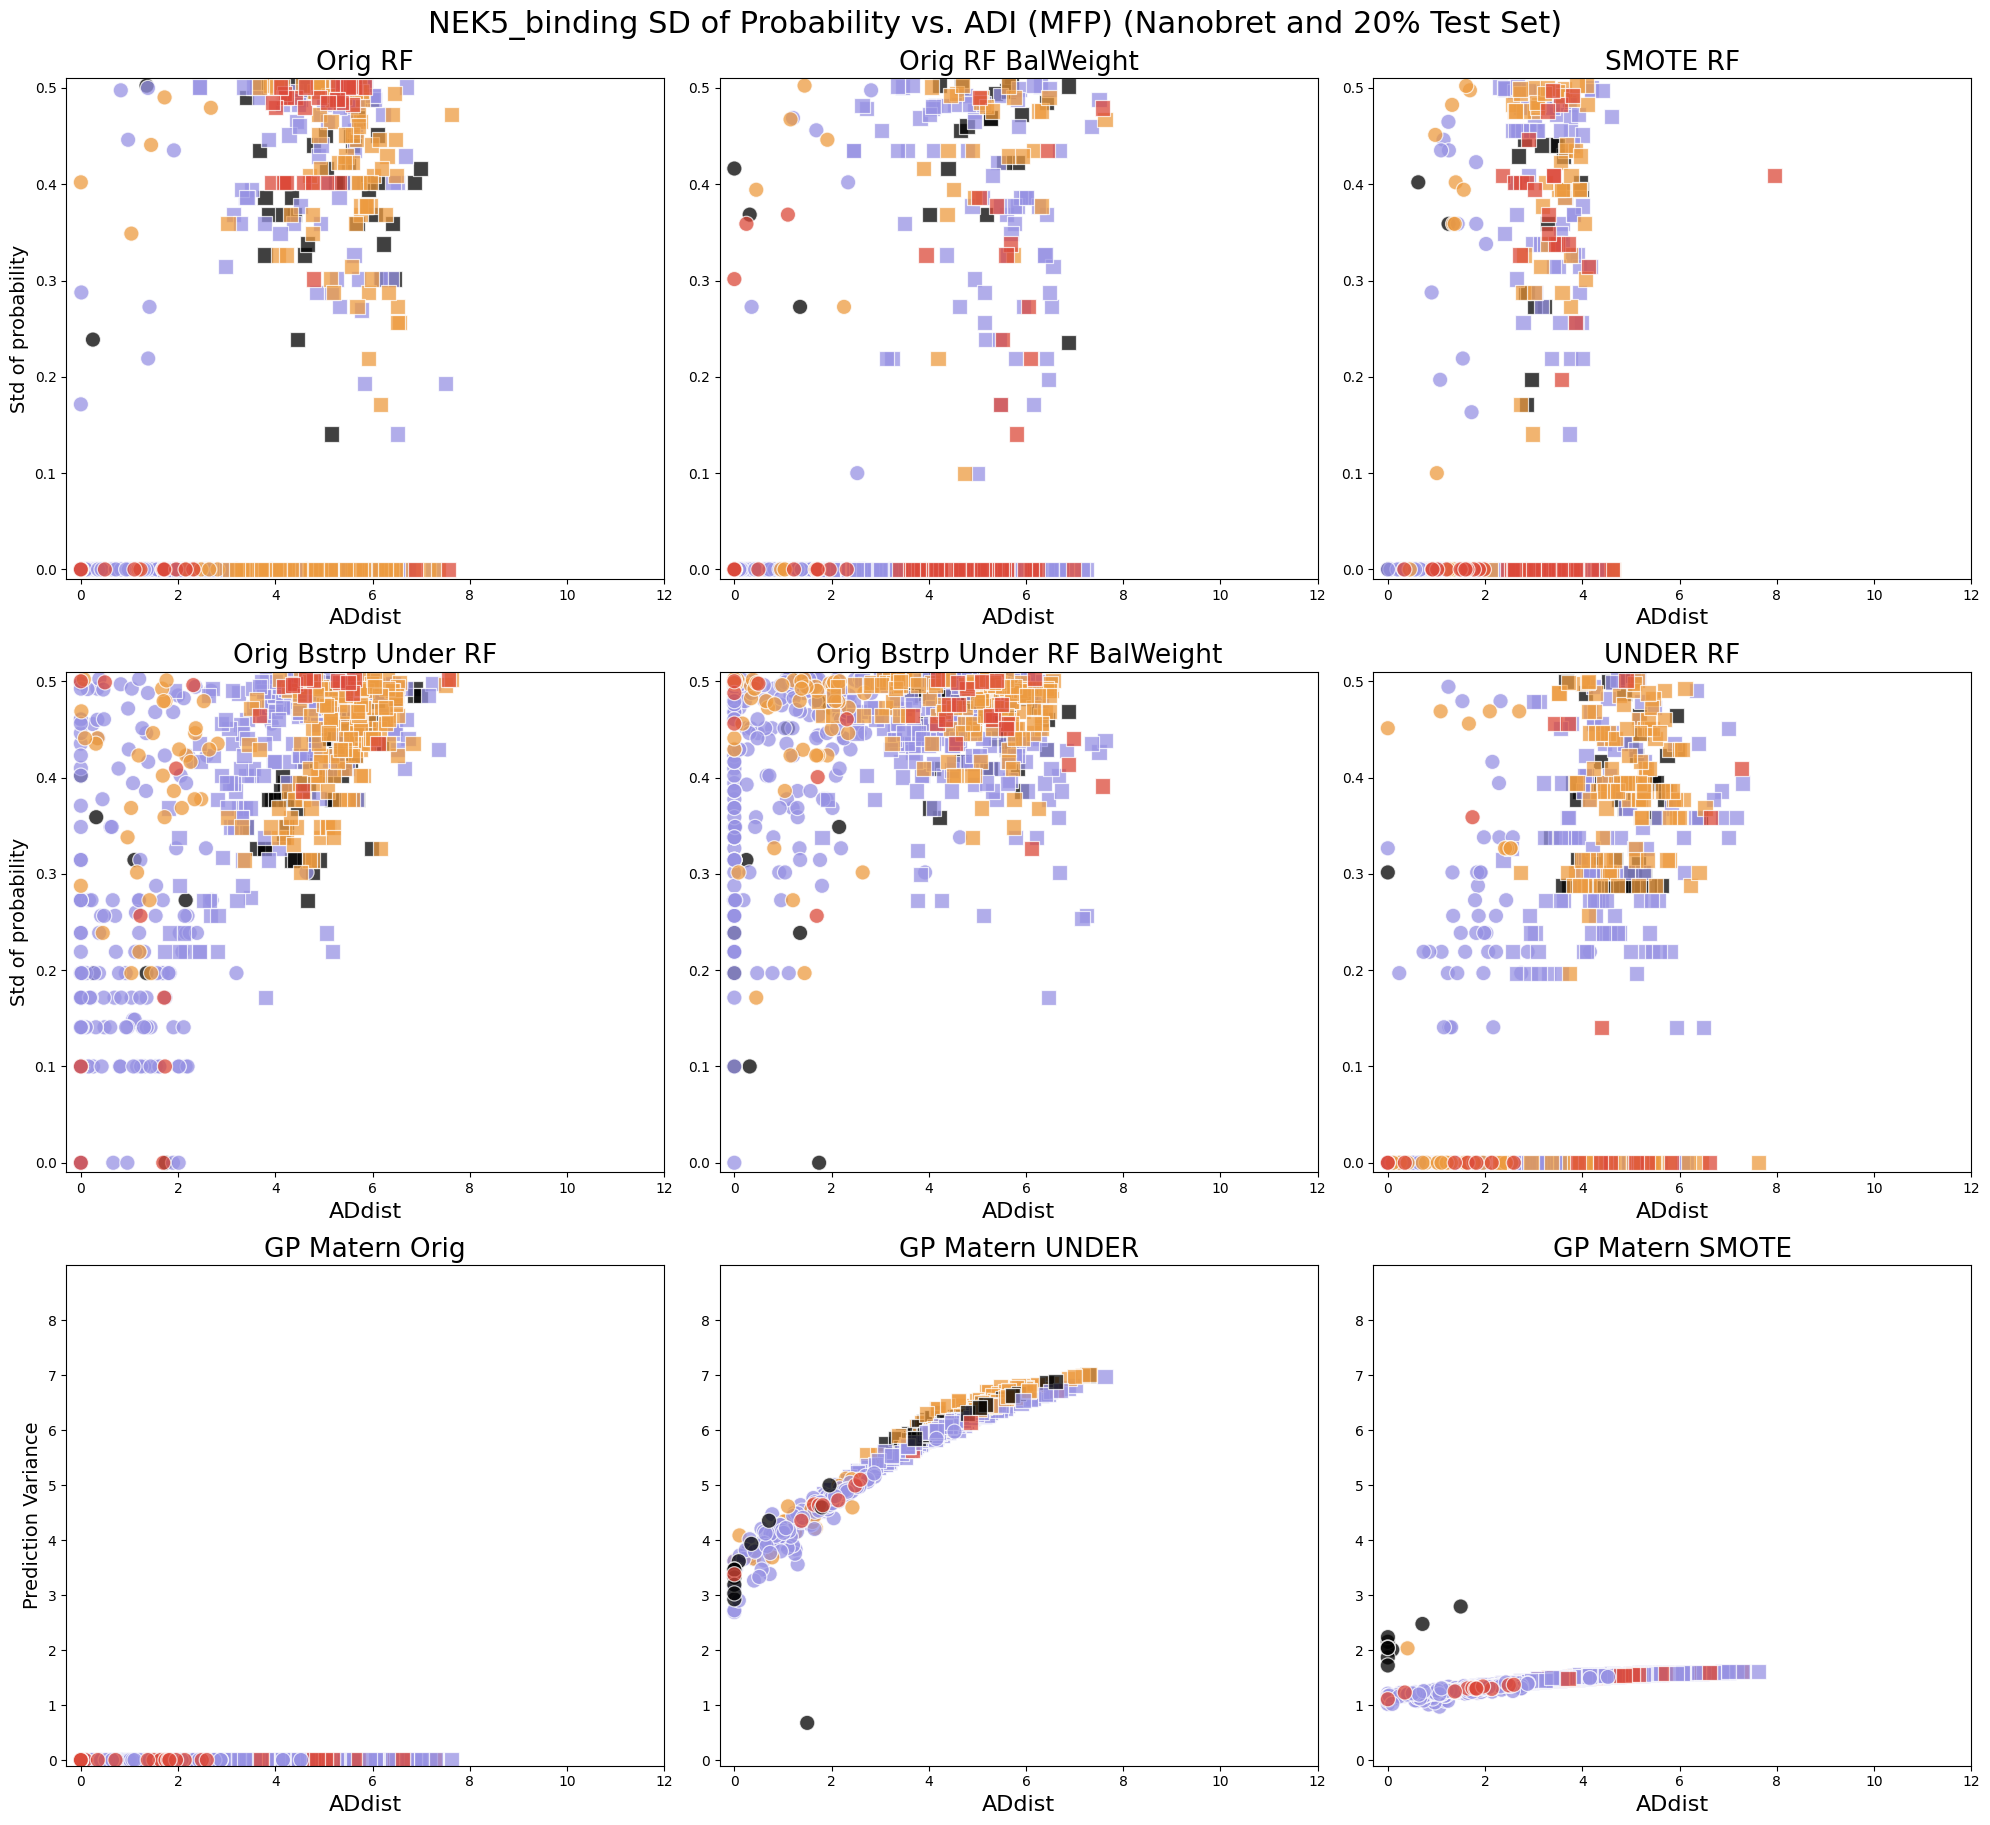

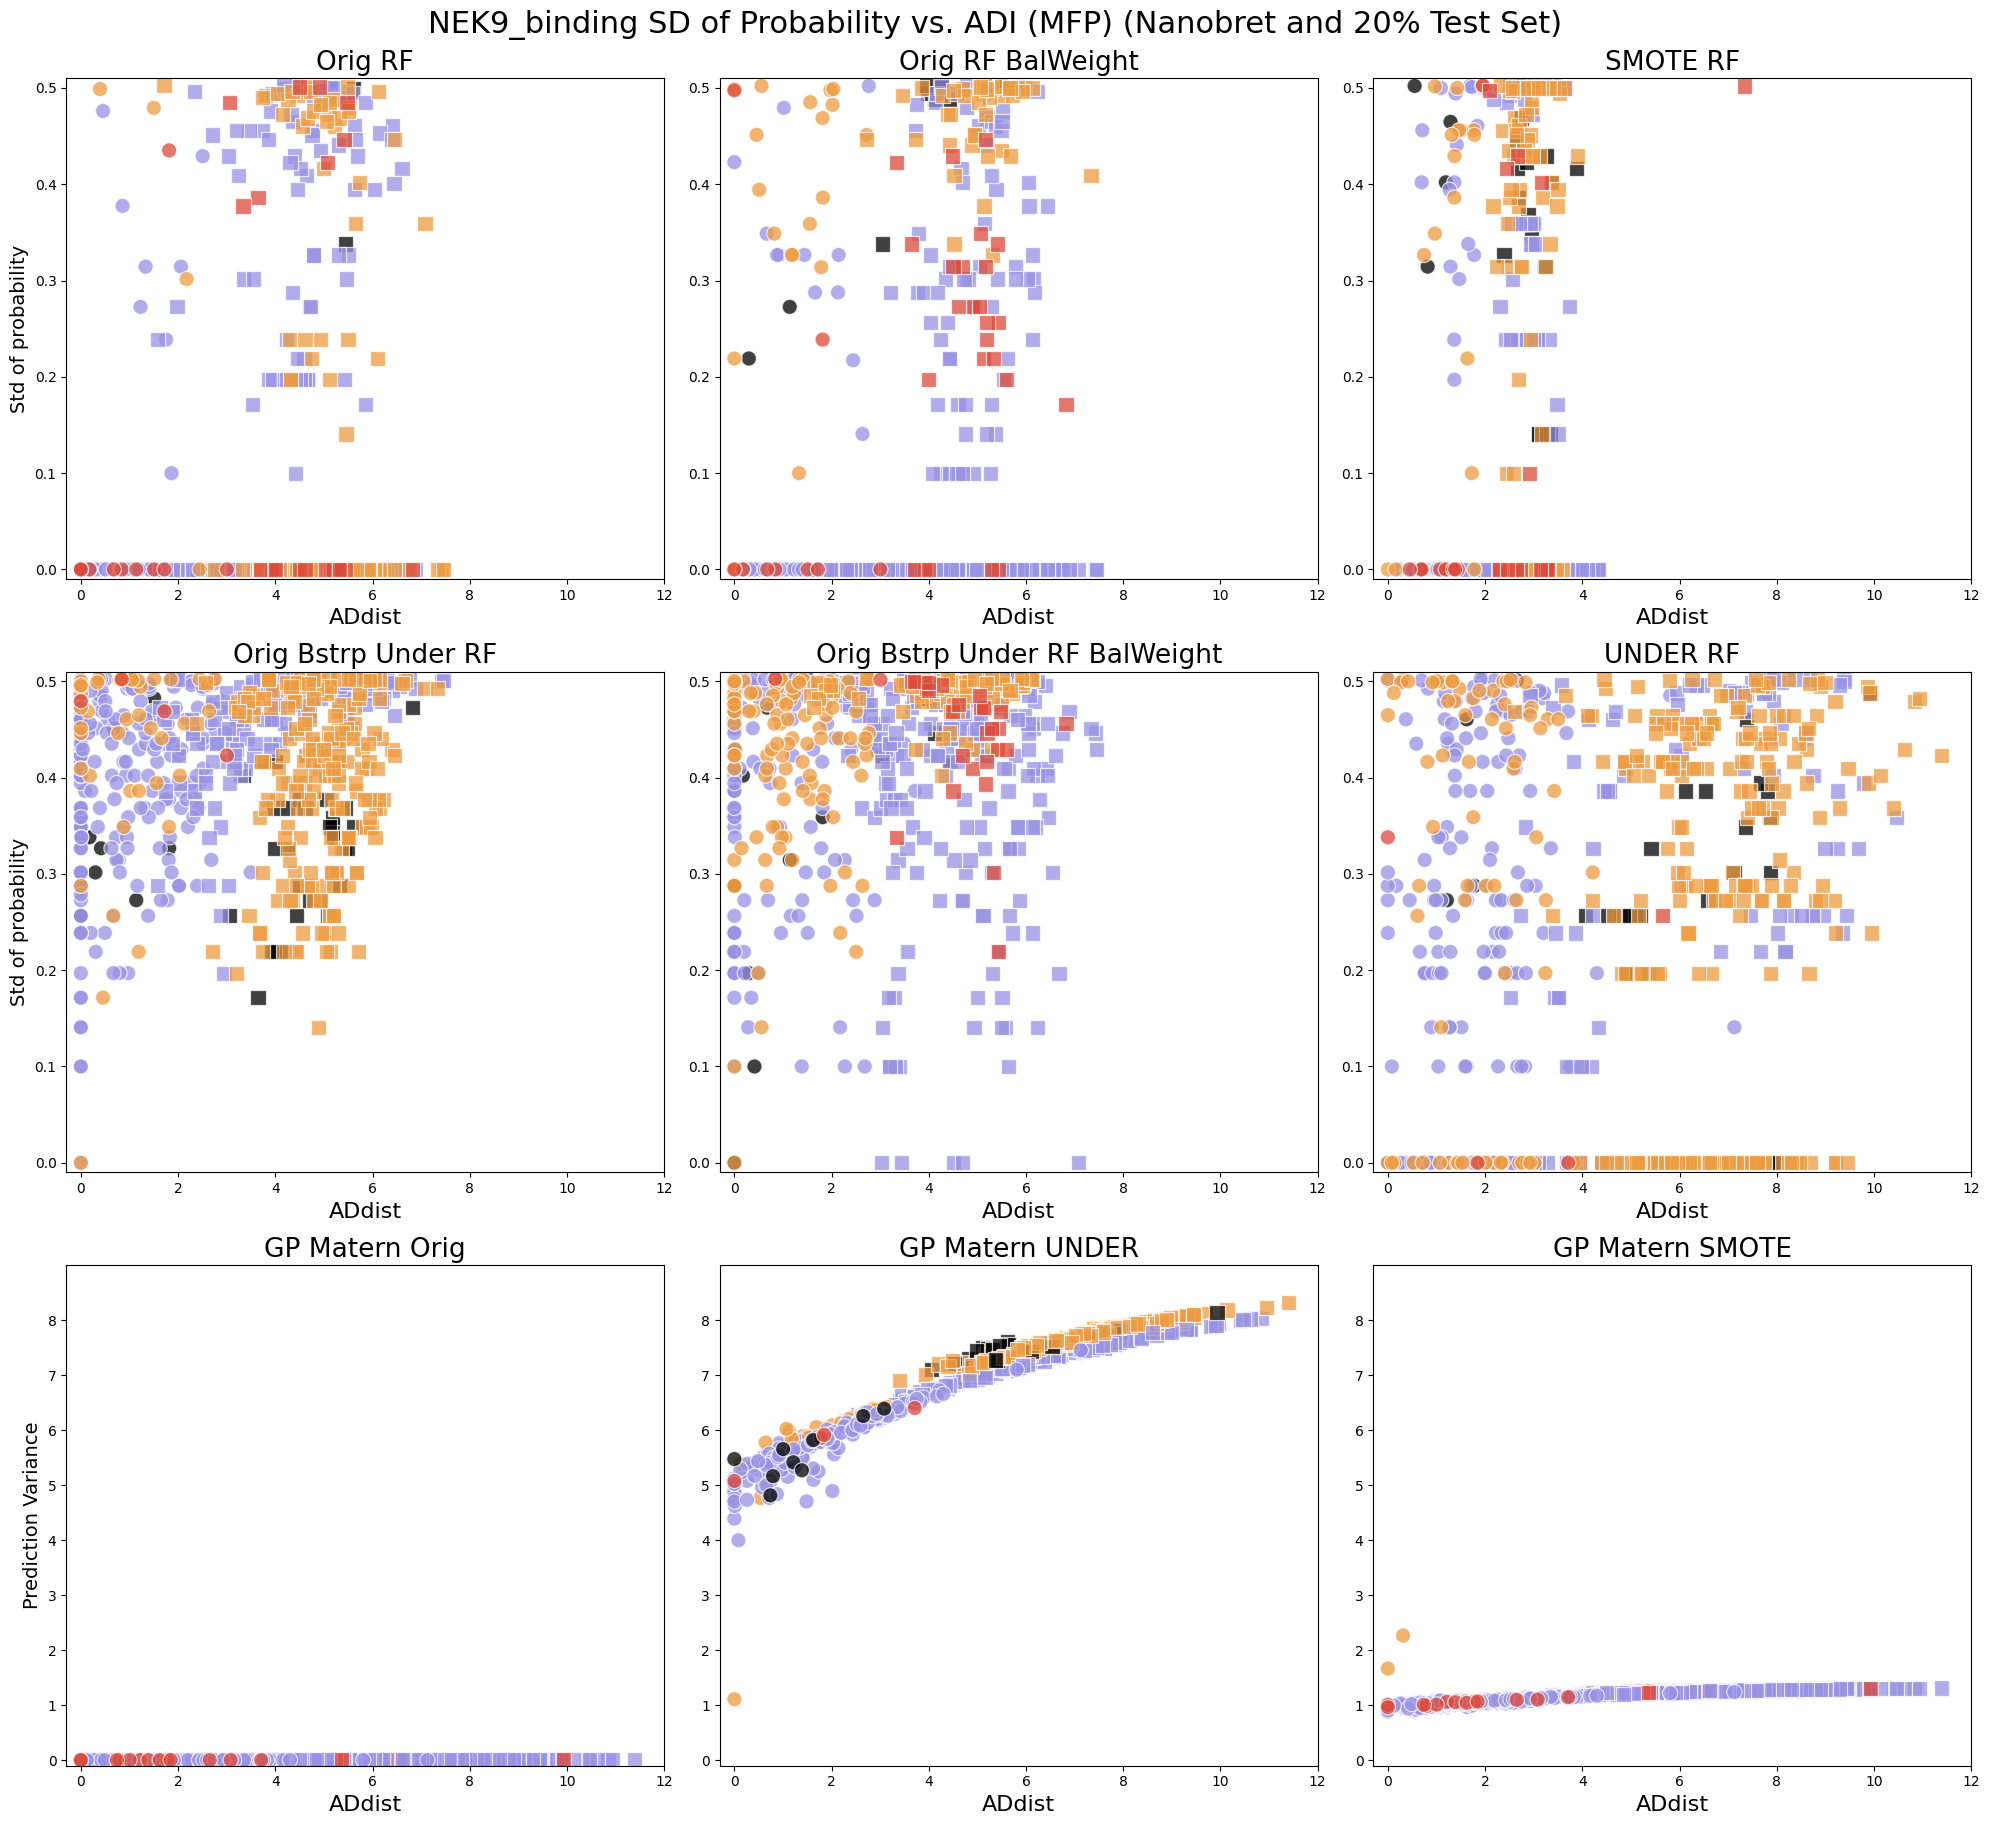

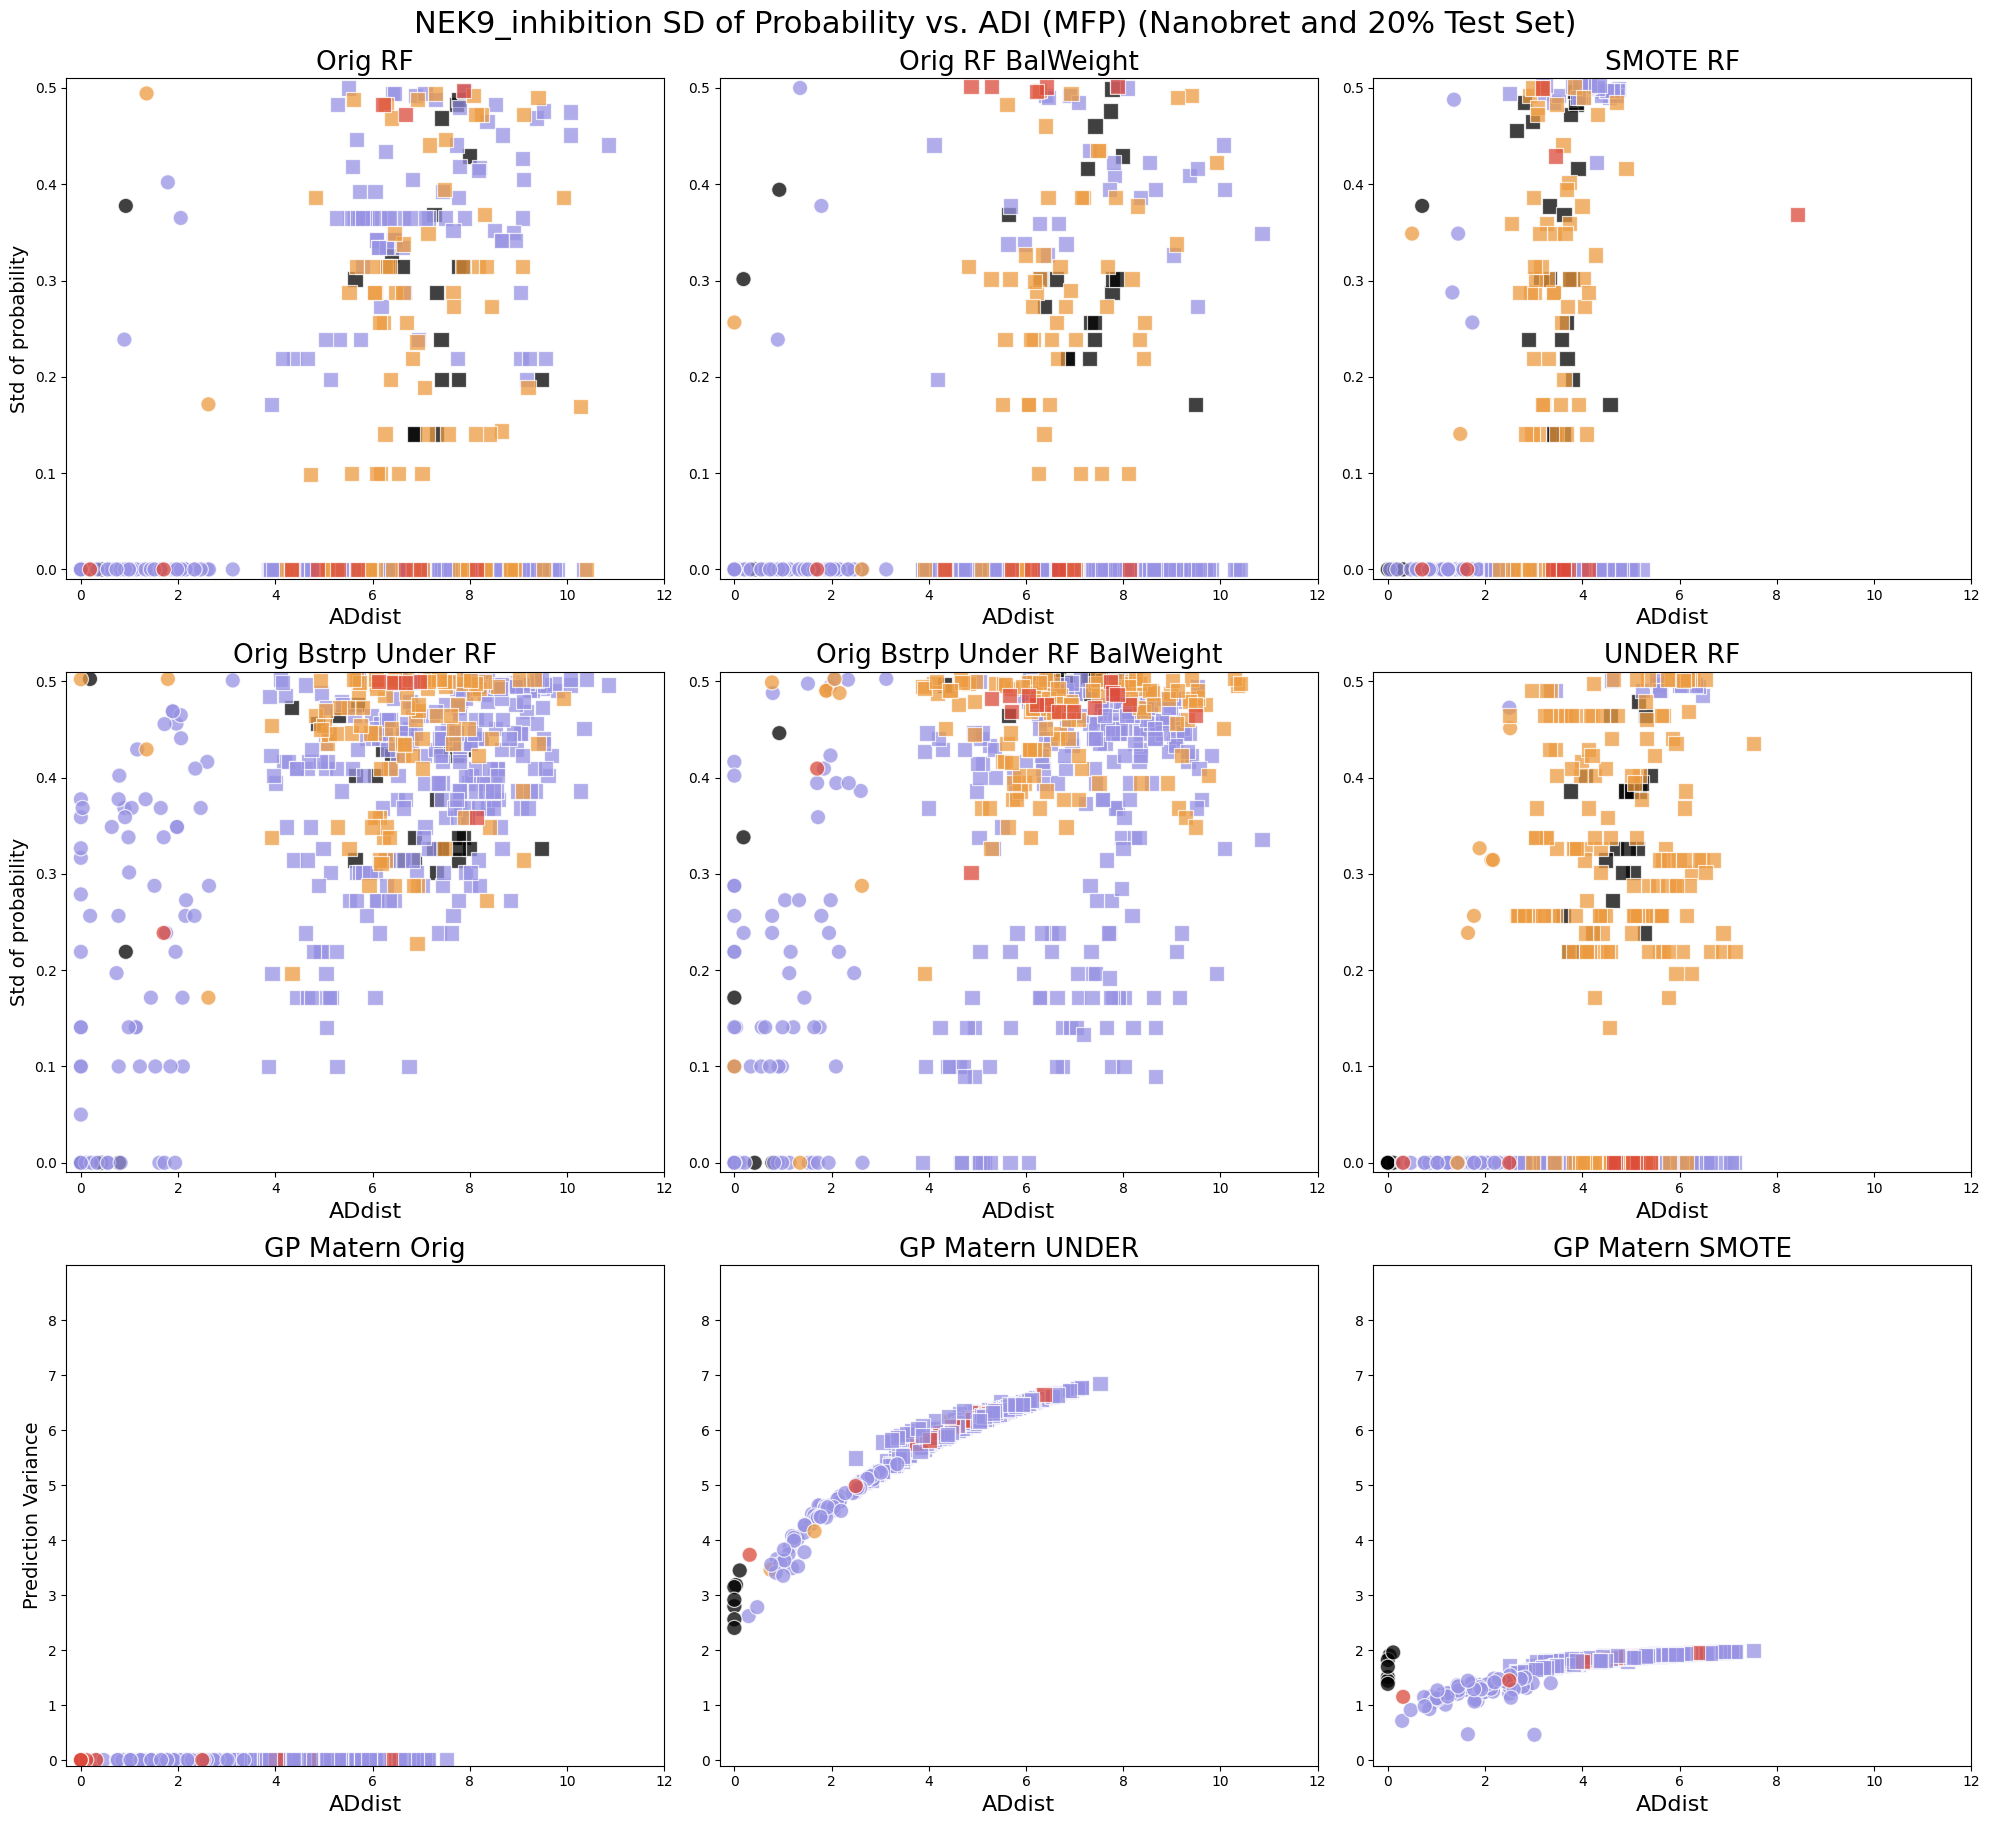

In [59]:
figpath = '/Users/jayceepang/msse/ATOM_CODE/UQ/all_sets/'
for nek in neks:
    short_nek = nek[:4] 

    nb_test_df = pd.read_csv(f'{datapath}{short_nek}_MFP_none_unscaled.csv').drop(columns=remove_cols)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    fig.suptitle(f'{nek} SD of Probability vs. ADI (MFP) (Nanobret and 20% Test Set)', fontsize=22,y=0.94)

    plt.subplots_adjust(hspace=.5)
    count=0
    for count, (samp,rf) in enumerate(sampling_combos):
        row = count//3
        col = count%3
        ax =axes[row,col]
        count += 1
        root_name = f'{nek}_MFP_{samp}'
        nb_rf_results_df = pd.read_csv(f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv')
        
        og_df = pd.read_csv(f'{og_datapath}{nek}_MFP_{samp}.csv') 
        train_df = og_df[og_df['subset'] == 'train'].drop(columns=remove_cols)
        ts1_test_df = og_df[og_df['subset'] == 'test'].drop(columns=remove_cols)
        
        ts1_rf_results_df = pd.read_csv(f'{og_rf_results_path}{nek}_MFP_{samp}_{rf}_prod_test.csv')
        
        with open(f'{model_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
            model = pickle.load(f) 
        
        nb_train_dist, nb_test_dist, nb_std0, nb_std1=get_plotting_data_RF_UQ2(model, train_df,nb_test_df)
        ts1_train_dist, ts1_test_dist, ts1_std0, ts1_std1=get_plotting_data_RF_UQ2(model, train_df,ts1_test_df)
        
        nb_rf_results_df['1-specificity'] = 1-nb_rf_results_df['specificity'] 
        nb_rf_true_labels =nb_rf_results_df['y'].to_numpy()
        nb_rf_results_df=change_names(nb_rf_results_df) 
        nb_rf_results_df['set'] = 'nanobret'
        nb_rf_results_df['std0'] = nb_std0
        nb_rf_results_df['std1'] = nb_std1
        nb_rf_results_df['ADdist'] = nb_test_dist
   

        ts1_rf_results_df['1-specificity'] = 1-ts1_rf_results_df['specificity'] 
        
        ts1_rf_results_df=change_names(ts1_rf_results_df) 
        ts1_rf_results_df['set'] = 'test'
        ts1_rf_results_df['std0'] = ts1_std0
        ts1_rf_results_df['std1'] = ts1_std1
        ts1_rf_results_df['ADdist'] = ts1_test_dist
        
        
        # if nb_rf_results_df.columns.tolist() == ts1_rf_results_df.columns.tolist():
        #     assert len(nb_rf_results_df) == len(nb_std0) == len(nb_test_dist)
        #     assert len(ts1_rf_results_df) == len(ts1_std0) == len(ts1_test_dist)
        rf_all_results = pd.concat([ts1_rf_results_df,nb_rf_results_df], ignore_index=True)
        samp_label=f'{name_strat_lookup[samp]} {name_strat_lookup[rf]}'
        title = (f'{samp_label}')
        # print(nek,
        #     rf_all_results[['std0', 'std1', 'ADdist']].describe())

        RF_scatter_stdprob_AD_sbuplots_SETS(rf_all_results, title, ax)
        if col == 0:
            ax.set_ylabel('Std of probability', fontsize=14)
     
        # print(nek,
        # hashlib.md5(pathlib.Path(path).read_bytes()).hexdigest())
    for col, samp2 in enumerate(['none_scaled','UNDER','SMOTE']):
        ax = axes[2, col]
        gp_nb_results = pd.read_csv(f'{nanobret_GP}{short_nek}_MFP_none_scaled_{nek}_{samp2}_GP_matern_nanobret_cellular_holdout.csv')
        gp_nb_dist, gp_nb_results_df=get_plotting_data_GP_UQ2(train_df, nb_test_df, gp_nb_results)
        gp_nb_results_df['set'] = 'nanobret'
        gp_nb_results_df = gp_nb_results_df[gp_cols]
        gp_ts1_results = pd.read_csv(f'{og_gp_results_path}{nek}_MFP_{samp2}_matern_prod_test.csv')
        # {feat}_{samp}_{kernel}
        gp_ts1_dist, gp_ts1_results_df=get_plotting_data_GP_UQ2(train_df, ts1_test_df, gp_ts1_results)
        gp_ts1_results_df['set'] = 'test'
        gp_ts1_results_df = gp_ts1_results_df[gp_cols]
        if gp_nb_results_df.columns.tolist() == gp_ts1_results_df.columns.tolist():

            gp_all_results = pd.concat([gp_nb_results_df,gp_ts1_results_df], ignore_index=True)
        
        GP_scatter_varpred_AD_sbuplots_SETS(gp_all_results,ax, ylabel_on=False)
        if col == 0:
            ax.set_ylabel('Prediction Variance', fontsize=14)
    
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # fig.savefig(f'{figpath}{nek}_RFGP_allsets_UQ_scatter.png', bbox_inches='tight')



In [21]:
import hashlib, pathlib
for nek in neks: 
    short_nek = nek[:4] 
    path = f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv'
    print(
        nek,
        hashlib.md5(pathlib.Path(path).read_bytes()).hexdigest()
    )

NEK2_binding fedd4665742037fae6b56539b931c25c
NEK2_inhibition 83a427384e76d928700a4fd9a4475e86
NEK3_binding 86eb4fd4f0e1090c1fbaa96a8fed562d
NEK5_binding b9233a95a37ea3a76148c3e7cefa84b9
NEK9_binding 1ca23ae72b740857c8798dc0d8d5bb82
NEK9_inhibition 477230e2c9e488891b452ef0ecd1cb5a


In [48]:
def GP_scatter_varpred_AD_sbuplots_SETS_logscale(df,ax, ylabel_on=True,figure_path=None, filename=None):
    true_labels = df['y'] 
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    df['prediction variance'] = np.nan
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    feat=df['feat_type'].iloc[0]
    samp=df['strategy'].iloc[0]
    sizes = df['prediction_type'].map(pred_sizes)
    df = df[df['prediction variance'] > 0]

    sns.scatterplot(data=df, x='ADdist', y='prediction variance', hue='prediction_type', palette=pred_palette,
           style='set',markers=set_markers,ax=ax,s=120,alpha=0.75)
    # samp_label=f'{df["feat_type"].iloc[0]} {df["strategy"].iloc[0]}'
    
    samp_label=f'GP Matern {df["strategy"].iloc[0]}'
    if df["strategy"].iloc[0] == 'none_scaled': 
        samp_label=f'GP Matern Orig'
    title = f'{samp_label}'
    # title = f'{samp_label}\n1-specificity: {df["1-specificity"].iloc[0]:.2f}, sensitivity: {df["recall"].iloc[0]:.2f}'
    ax.set_title(f'{title}',fontsize=19)
    ax.set_yscale('log')
    
    ax.set_yticks(np.arange(0,9, step=1))
    ax.get_legend().remove()
    ax.set_xlabel('ADdist', fontsize=16)
    if ylabel_on: 
        ax.set_ylabel('Predictive Variance', fontsize=16)
    else: 
        ax.set_ylabel('', fontsize=16)
        
    # ax.set_ylim(-0.1, 9)
    # ax.set_yticks(np.arange(0,9, step=1))
    ax.set_ylim(1e-4, 10)




In [52]:
def RF_scatter_stdprob_AD_sbuplots_SETS_logscale(df, title, ax):
    predictions = df['prediction'].to_numpy()
    true_labels = df['y'].to_numpy()
    std0 = df['std0'].to_numpy()
    std1 = df['std1'].to_numpy()
    ad_dist = df['ADdist'].to_numpy()
    set_vals = df['set'].to_numpy()

    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    fn_std0 = std0[false_neg] # NEW MAR 29 2025
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]
    
    data = {'std of probabilities': np.concatenate([std1[true_pos],std0[true_neg],std1[false_pos],std0[false_neg]]),
        'prediction_type': (['TP'] * len(true_pos) +['TN'] * len(true_neg) +['FP'] * len(false_pos) +['FN'] * len(false_neg)),
        'ADdist': np.concatenate([
            ad_dist[true_pos],ad_dist[true_neg],ad_dist[false_pos],ad_dist[false_neg]]),
        'set': np.concatenate([
            set_vals[true_pos],set_vals[true_neg],
            set_vals[false_pos],set_vals[false_neg]])}
    plot_df = pd.DataFrame(data)
    plot_df['std of probabilities'] = plot_df['std of probabilities'].clip(lower=1e-6)
    
    sns.scatterplot(data=plot_df, x='ADdist', y='std of probabilities', hue='prediction_type', palette=pred_palette,
           style='set',markers=set_markers,ax=ax,s=120,alpha=0.75)
    ax.set_yscale('log')
    ax.set_title(title, fontsize=19)
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    # ax.set_ylabel('SD of probability', fontsize=15)
    ax.set_ylabel('')
    ax.set_ylim(1e-4, 1)
    ax.set_xlim(-.30,12) 

# Log scale

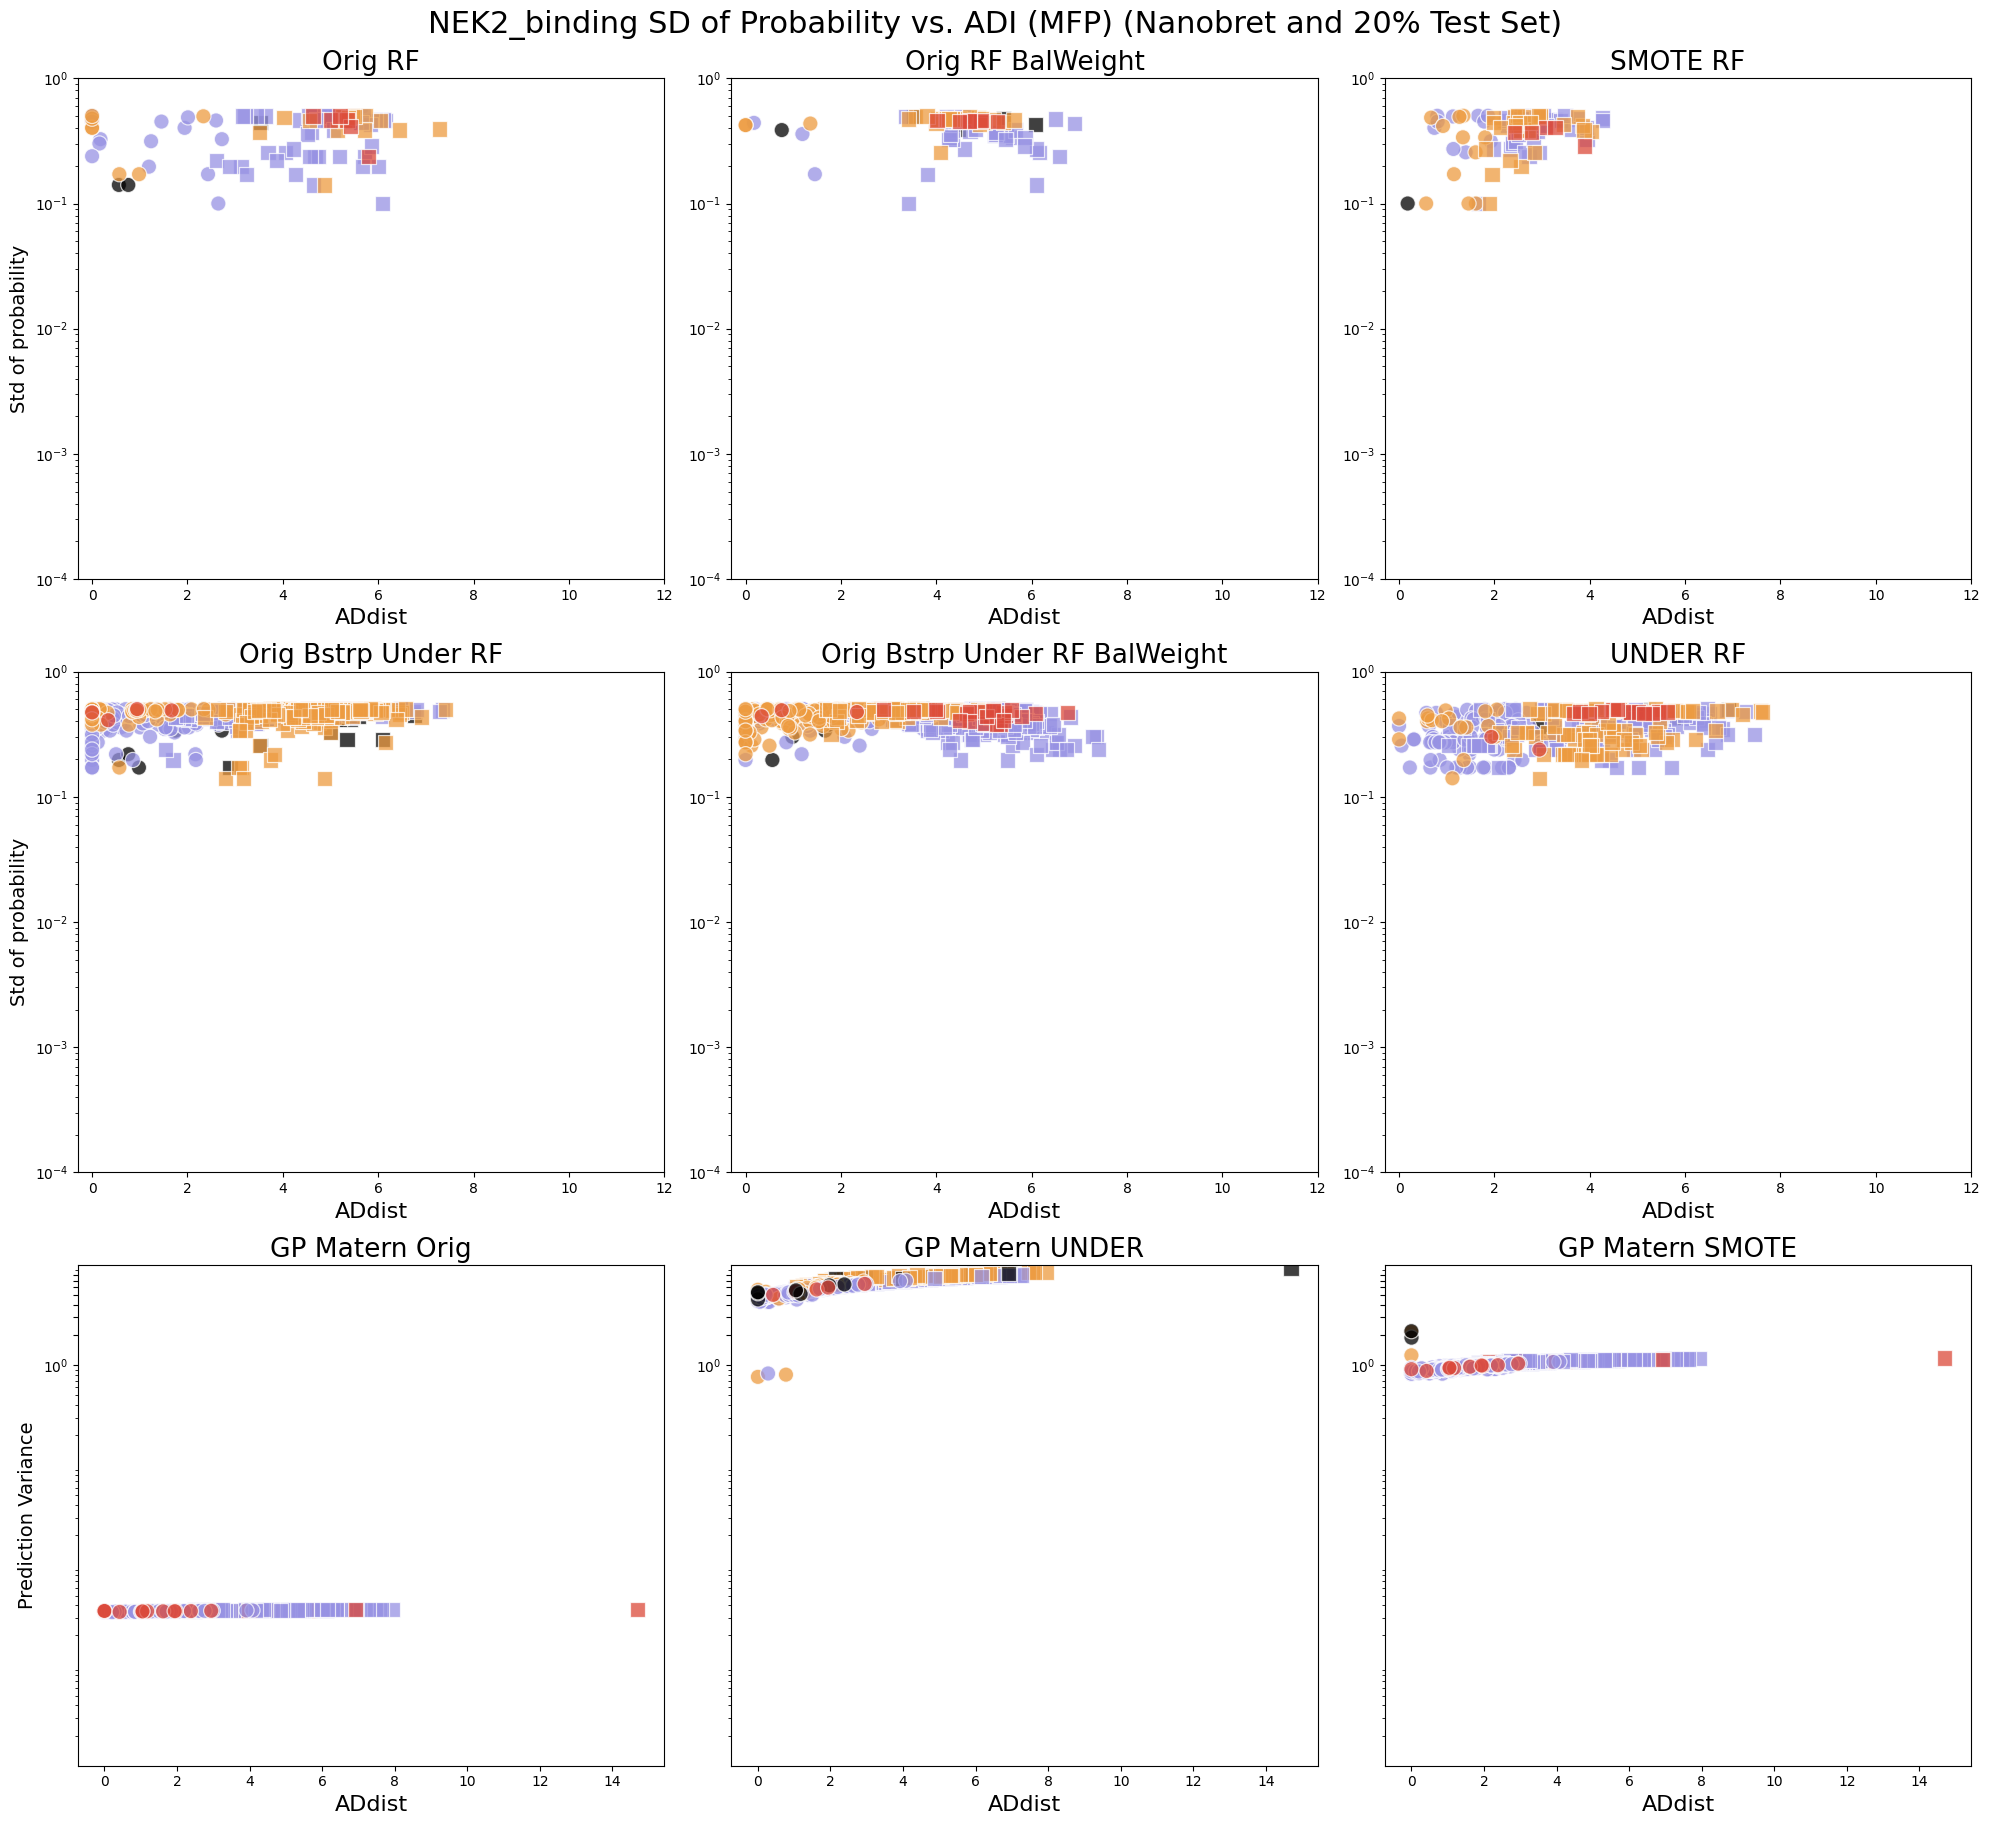

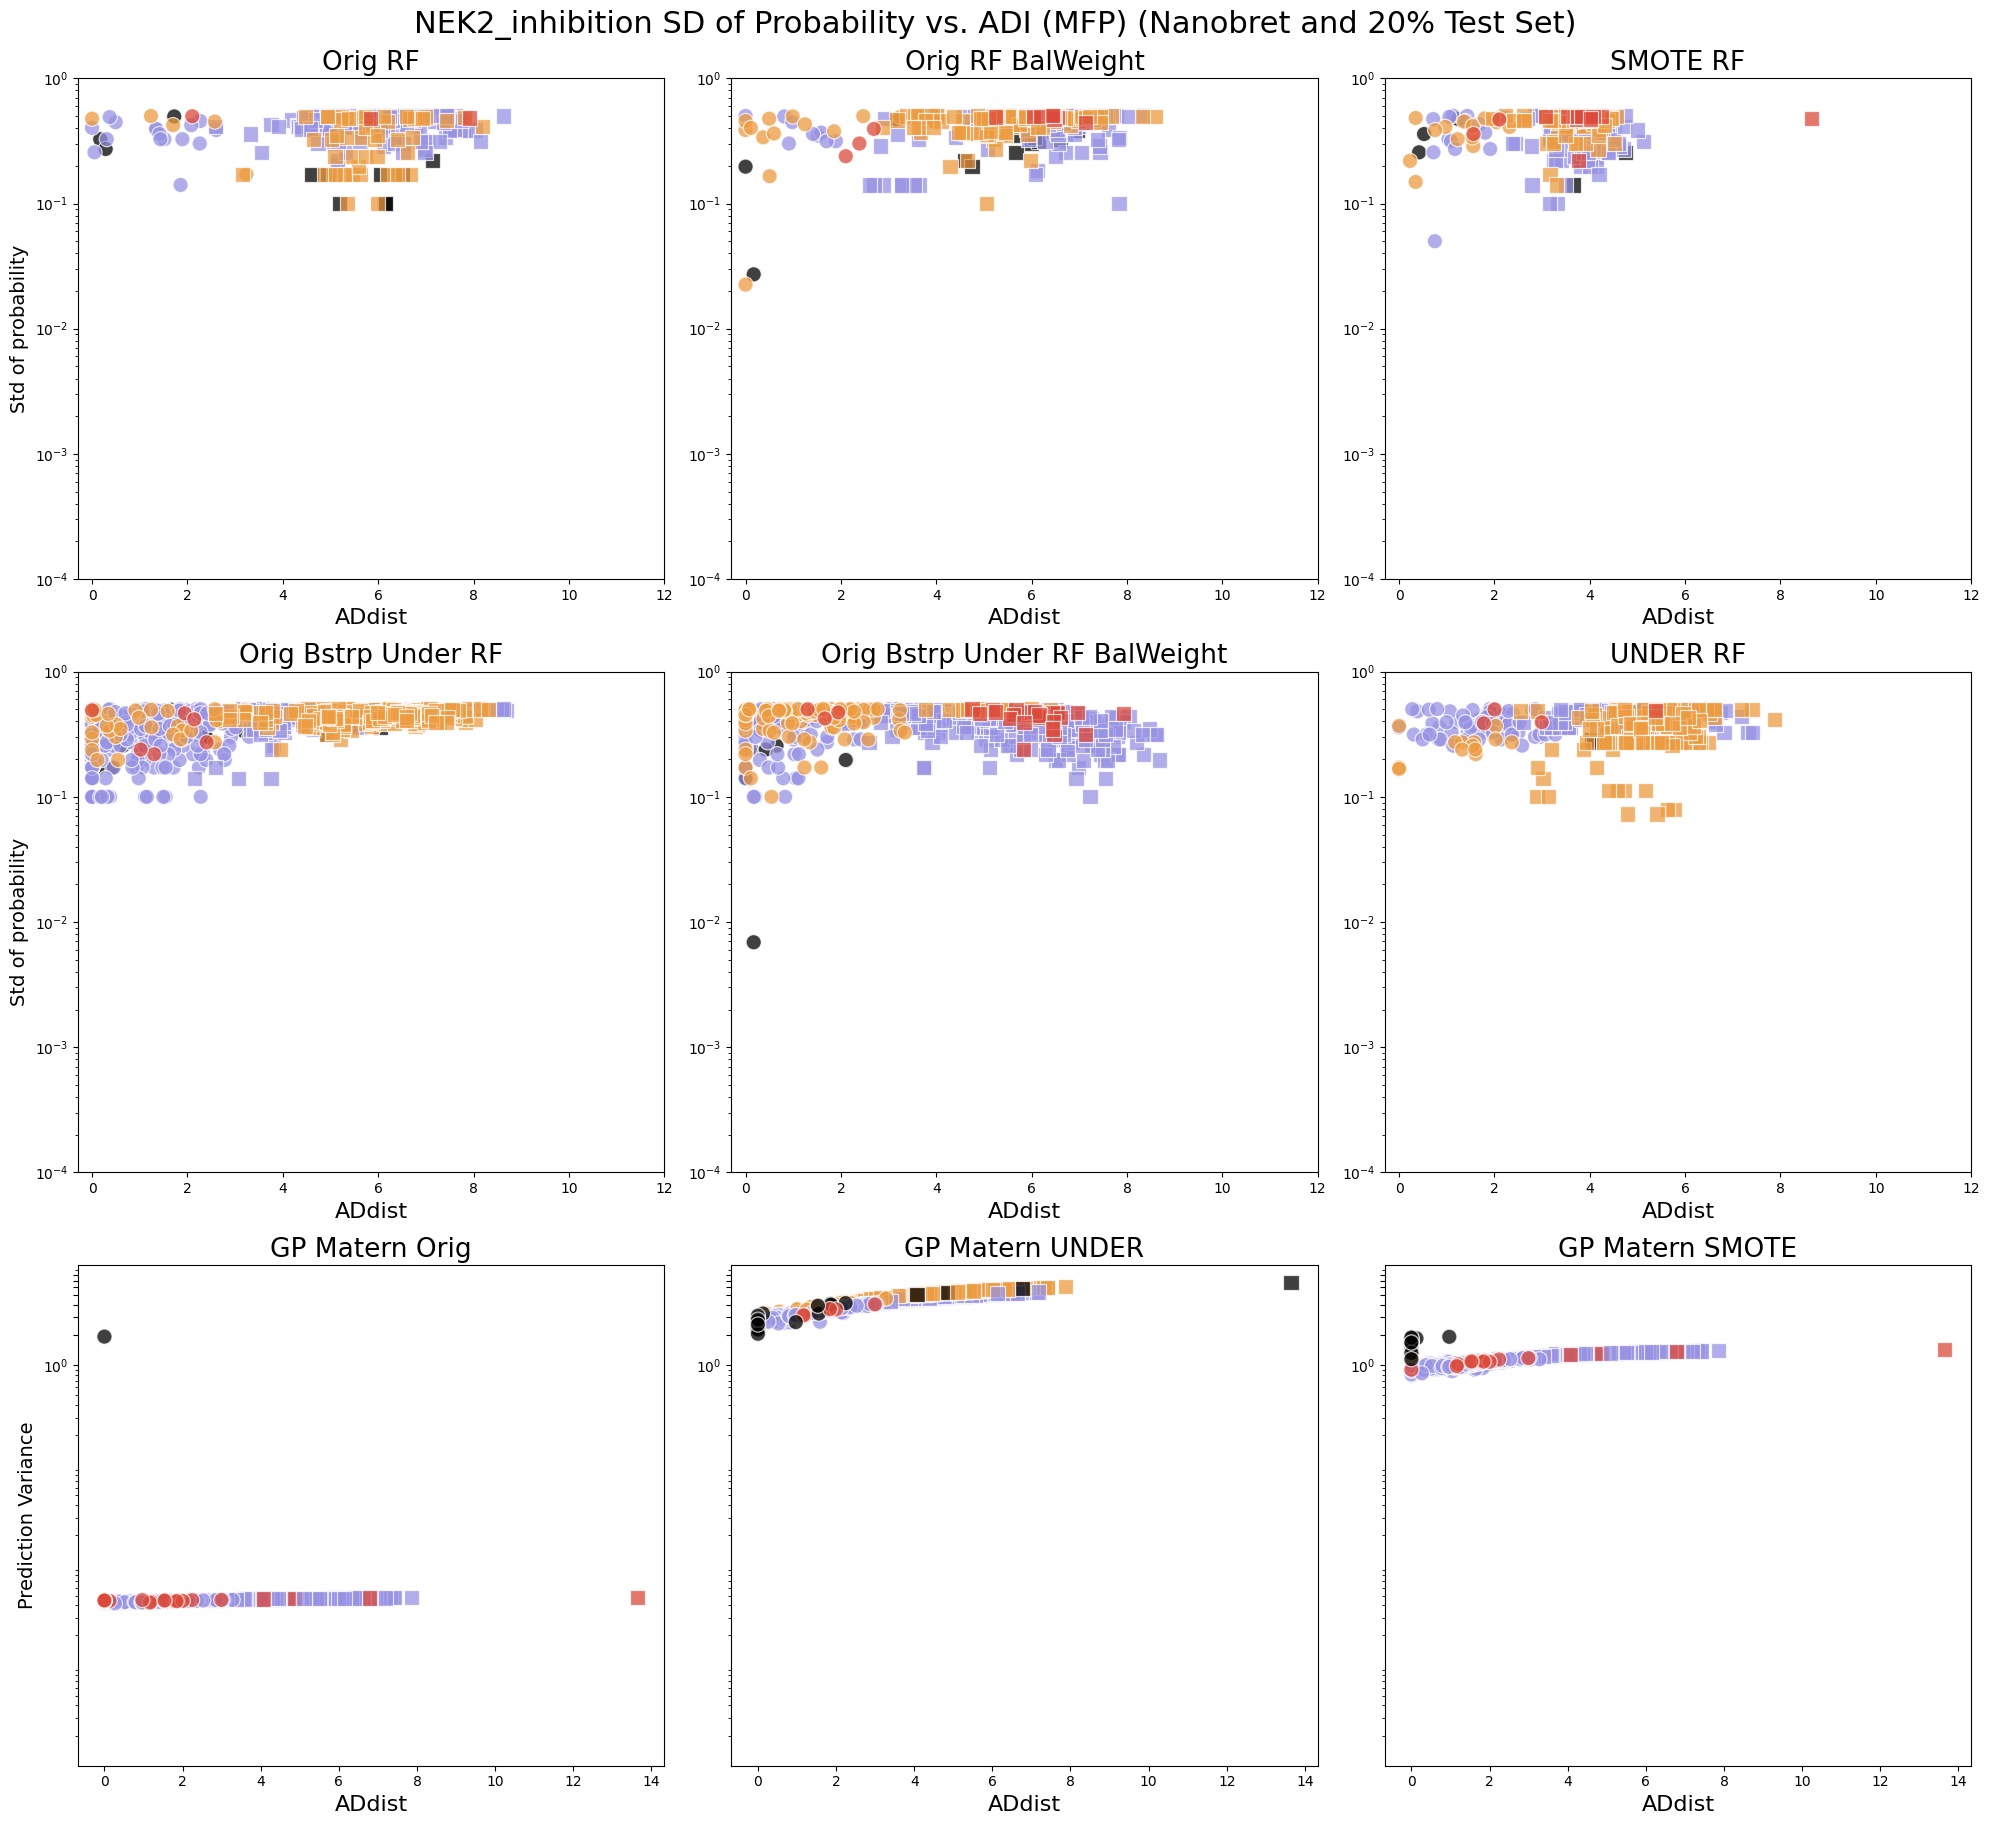

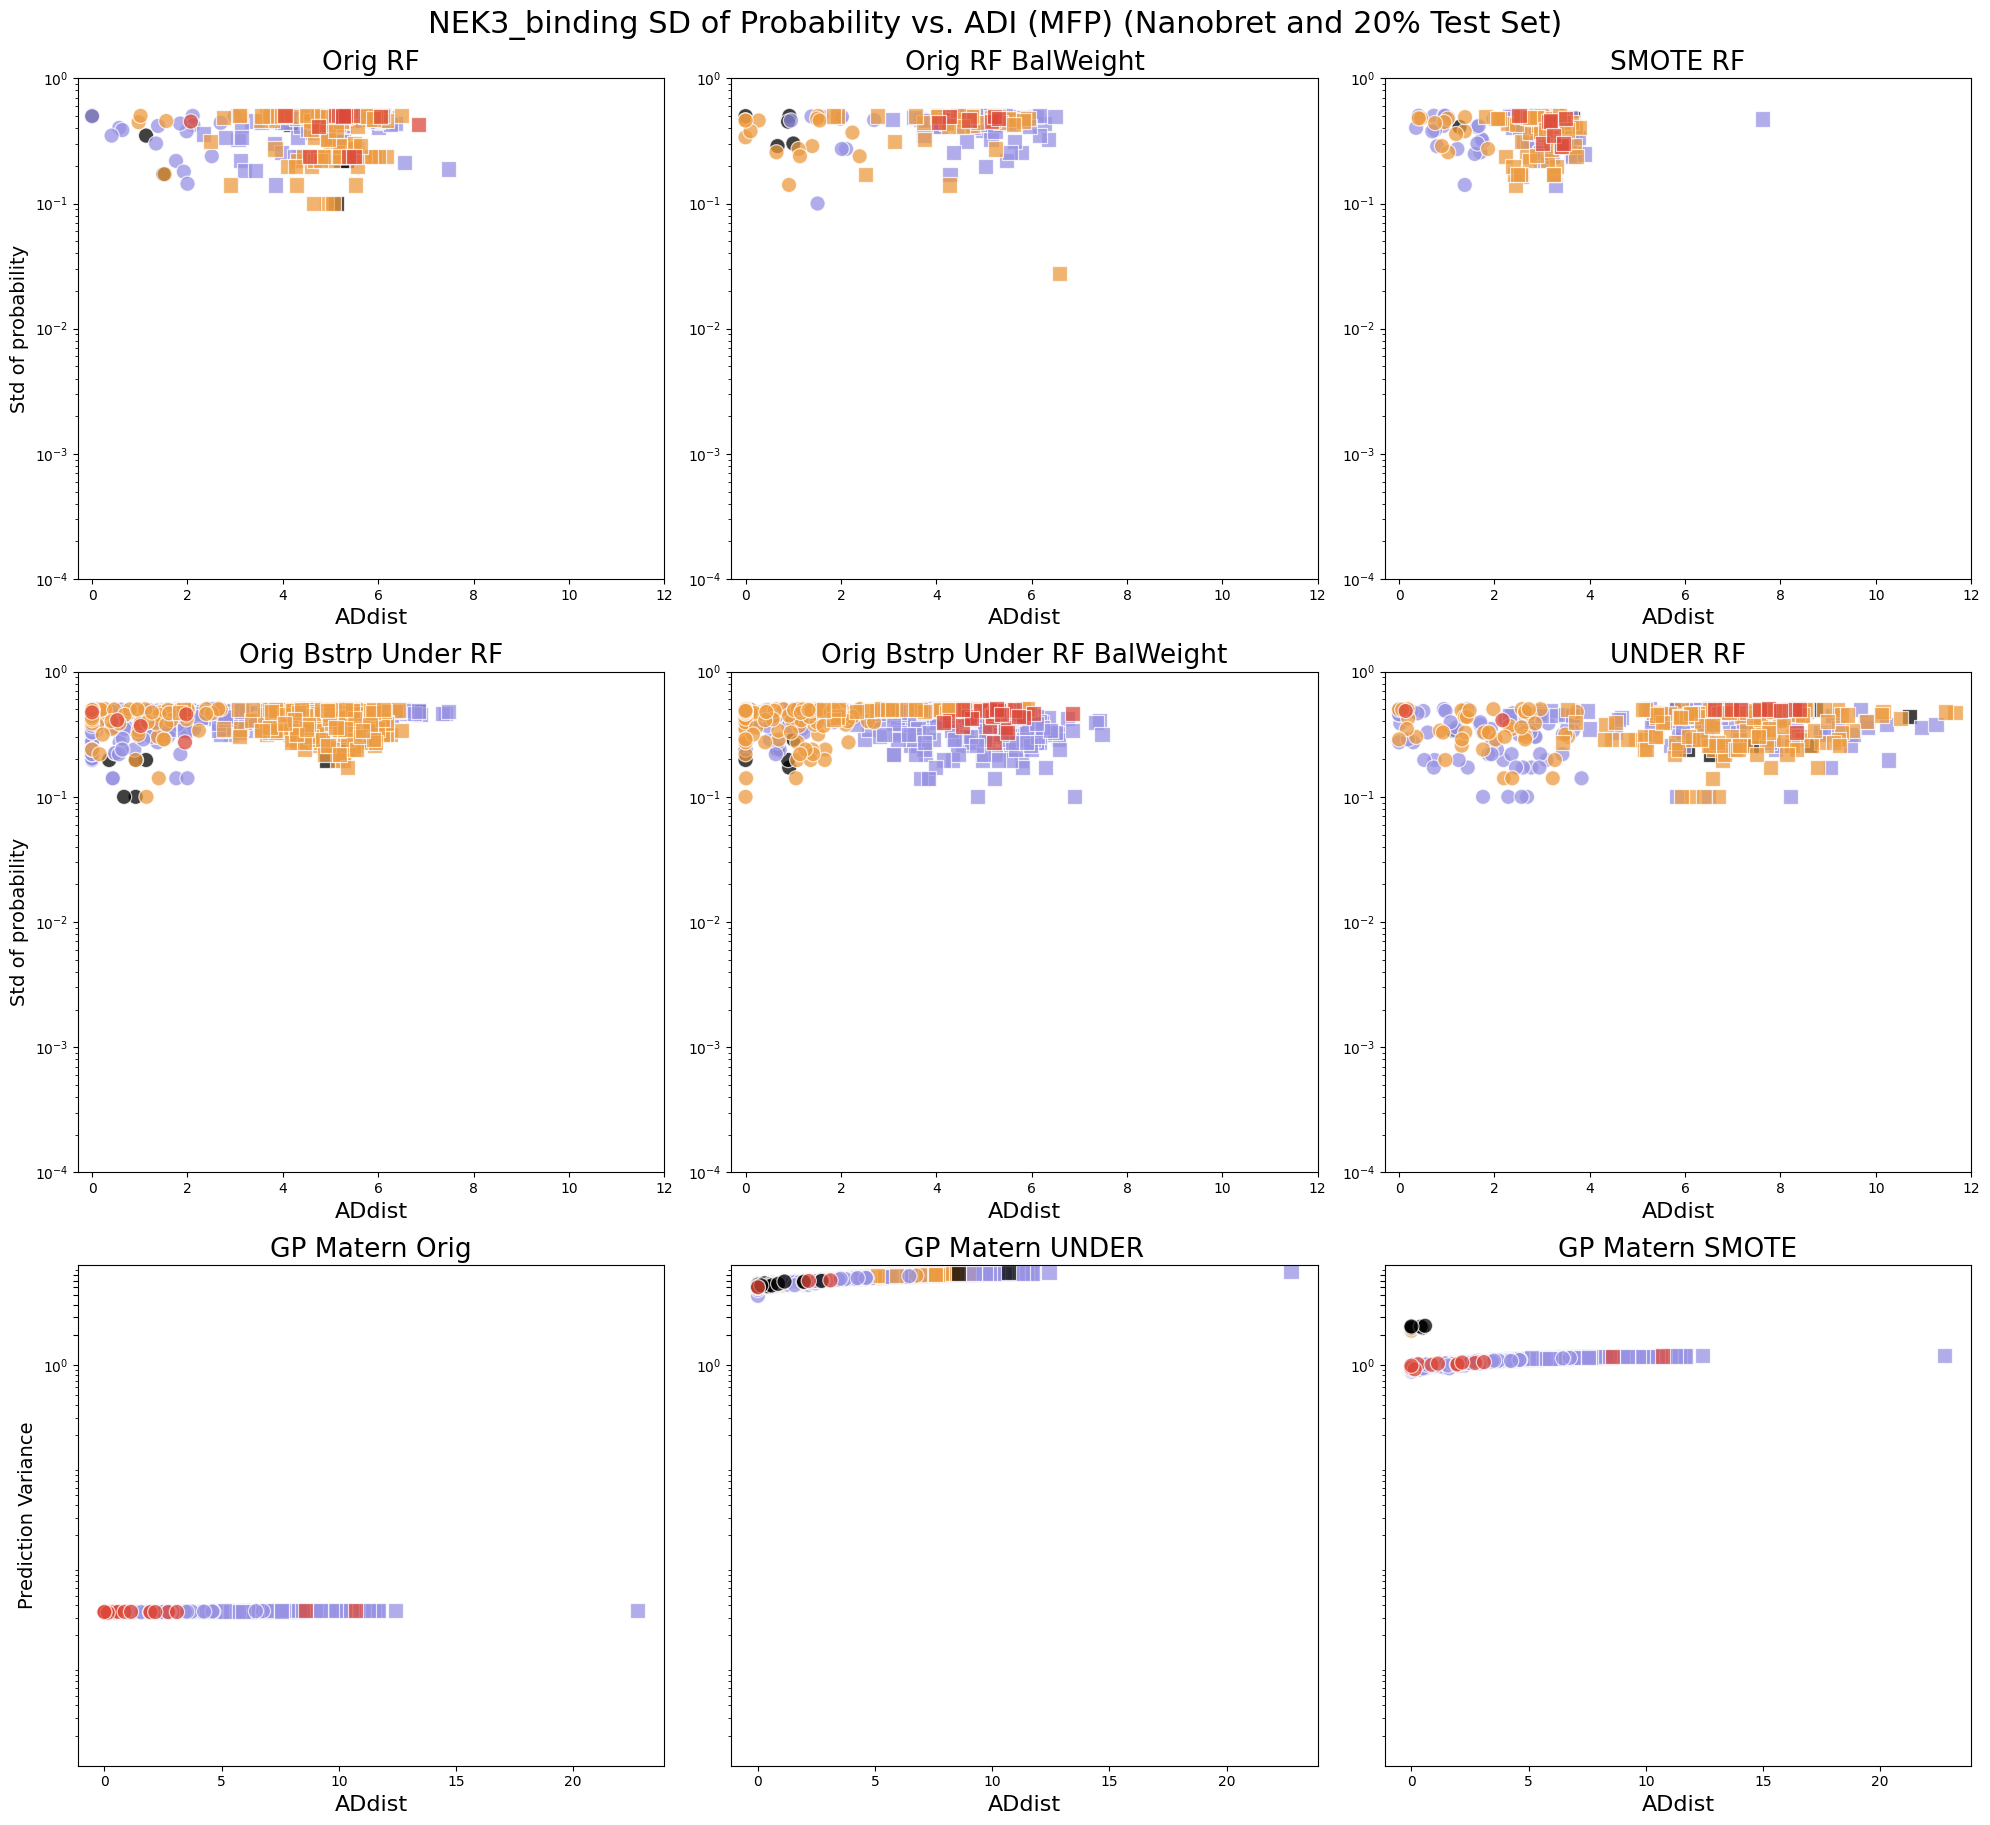

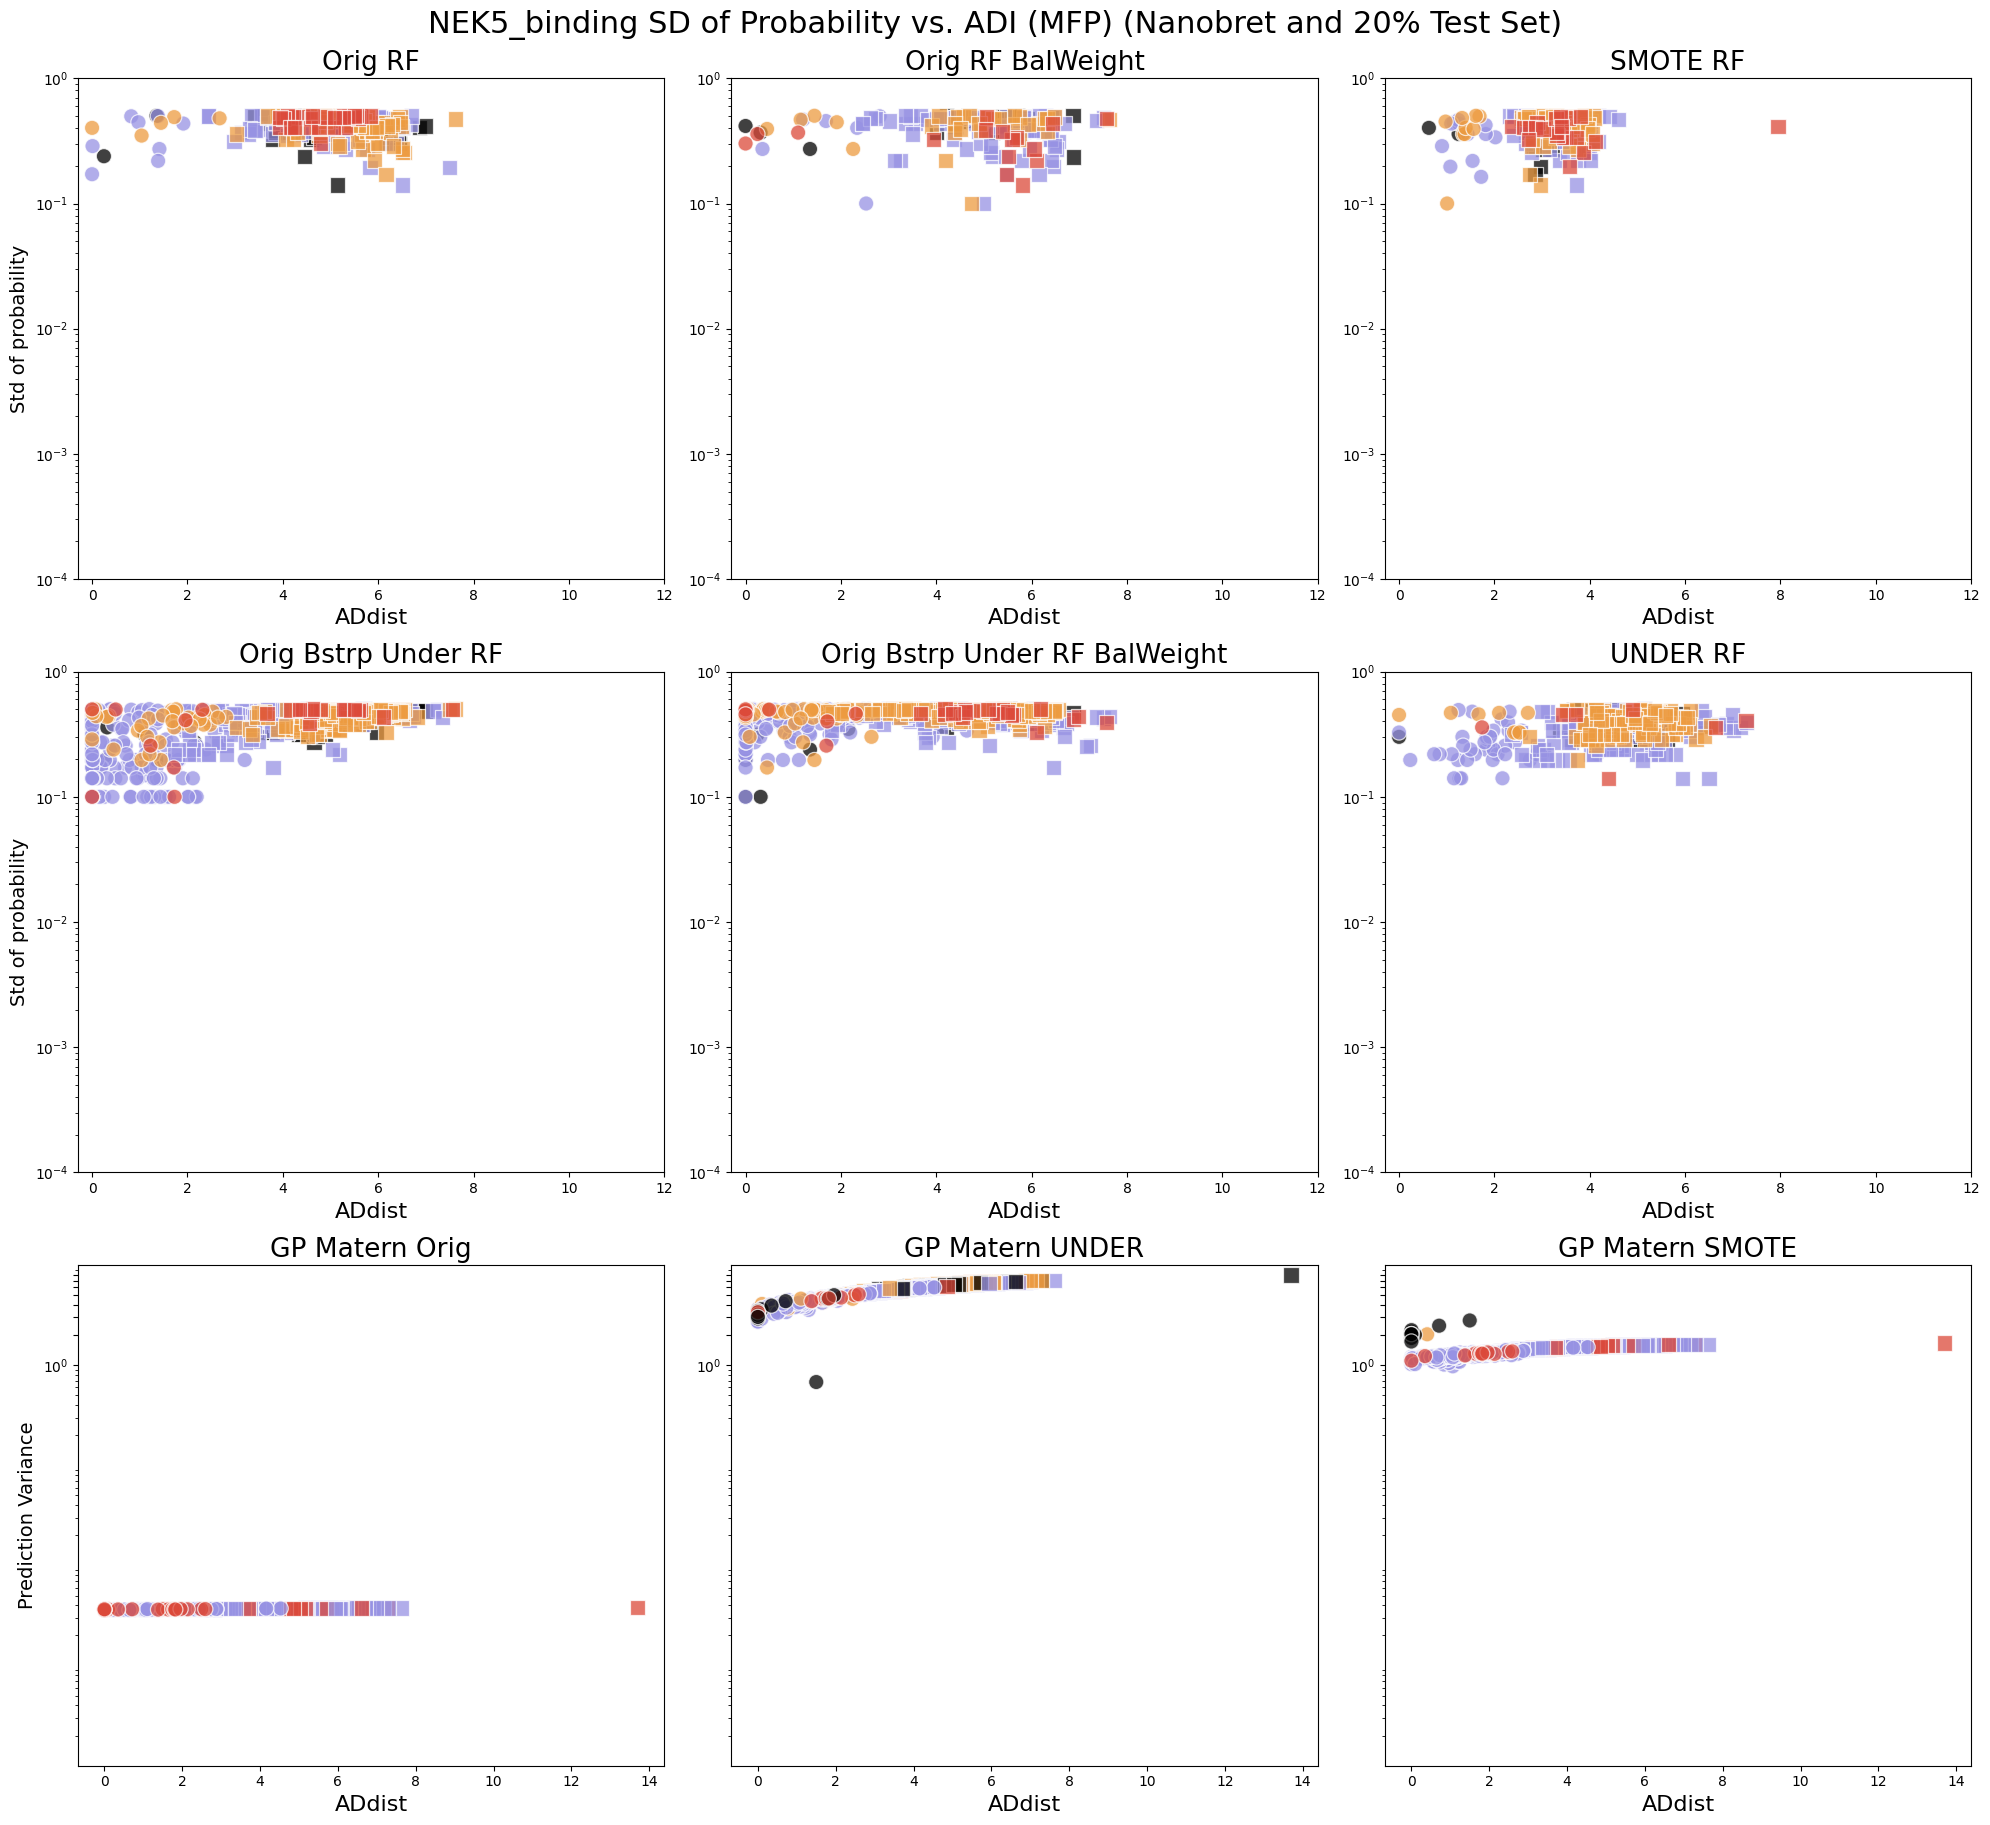

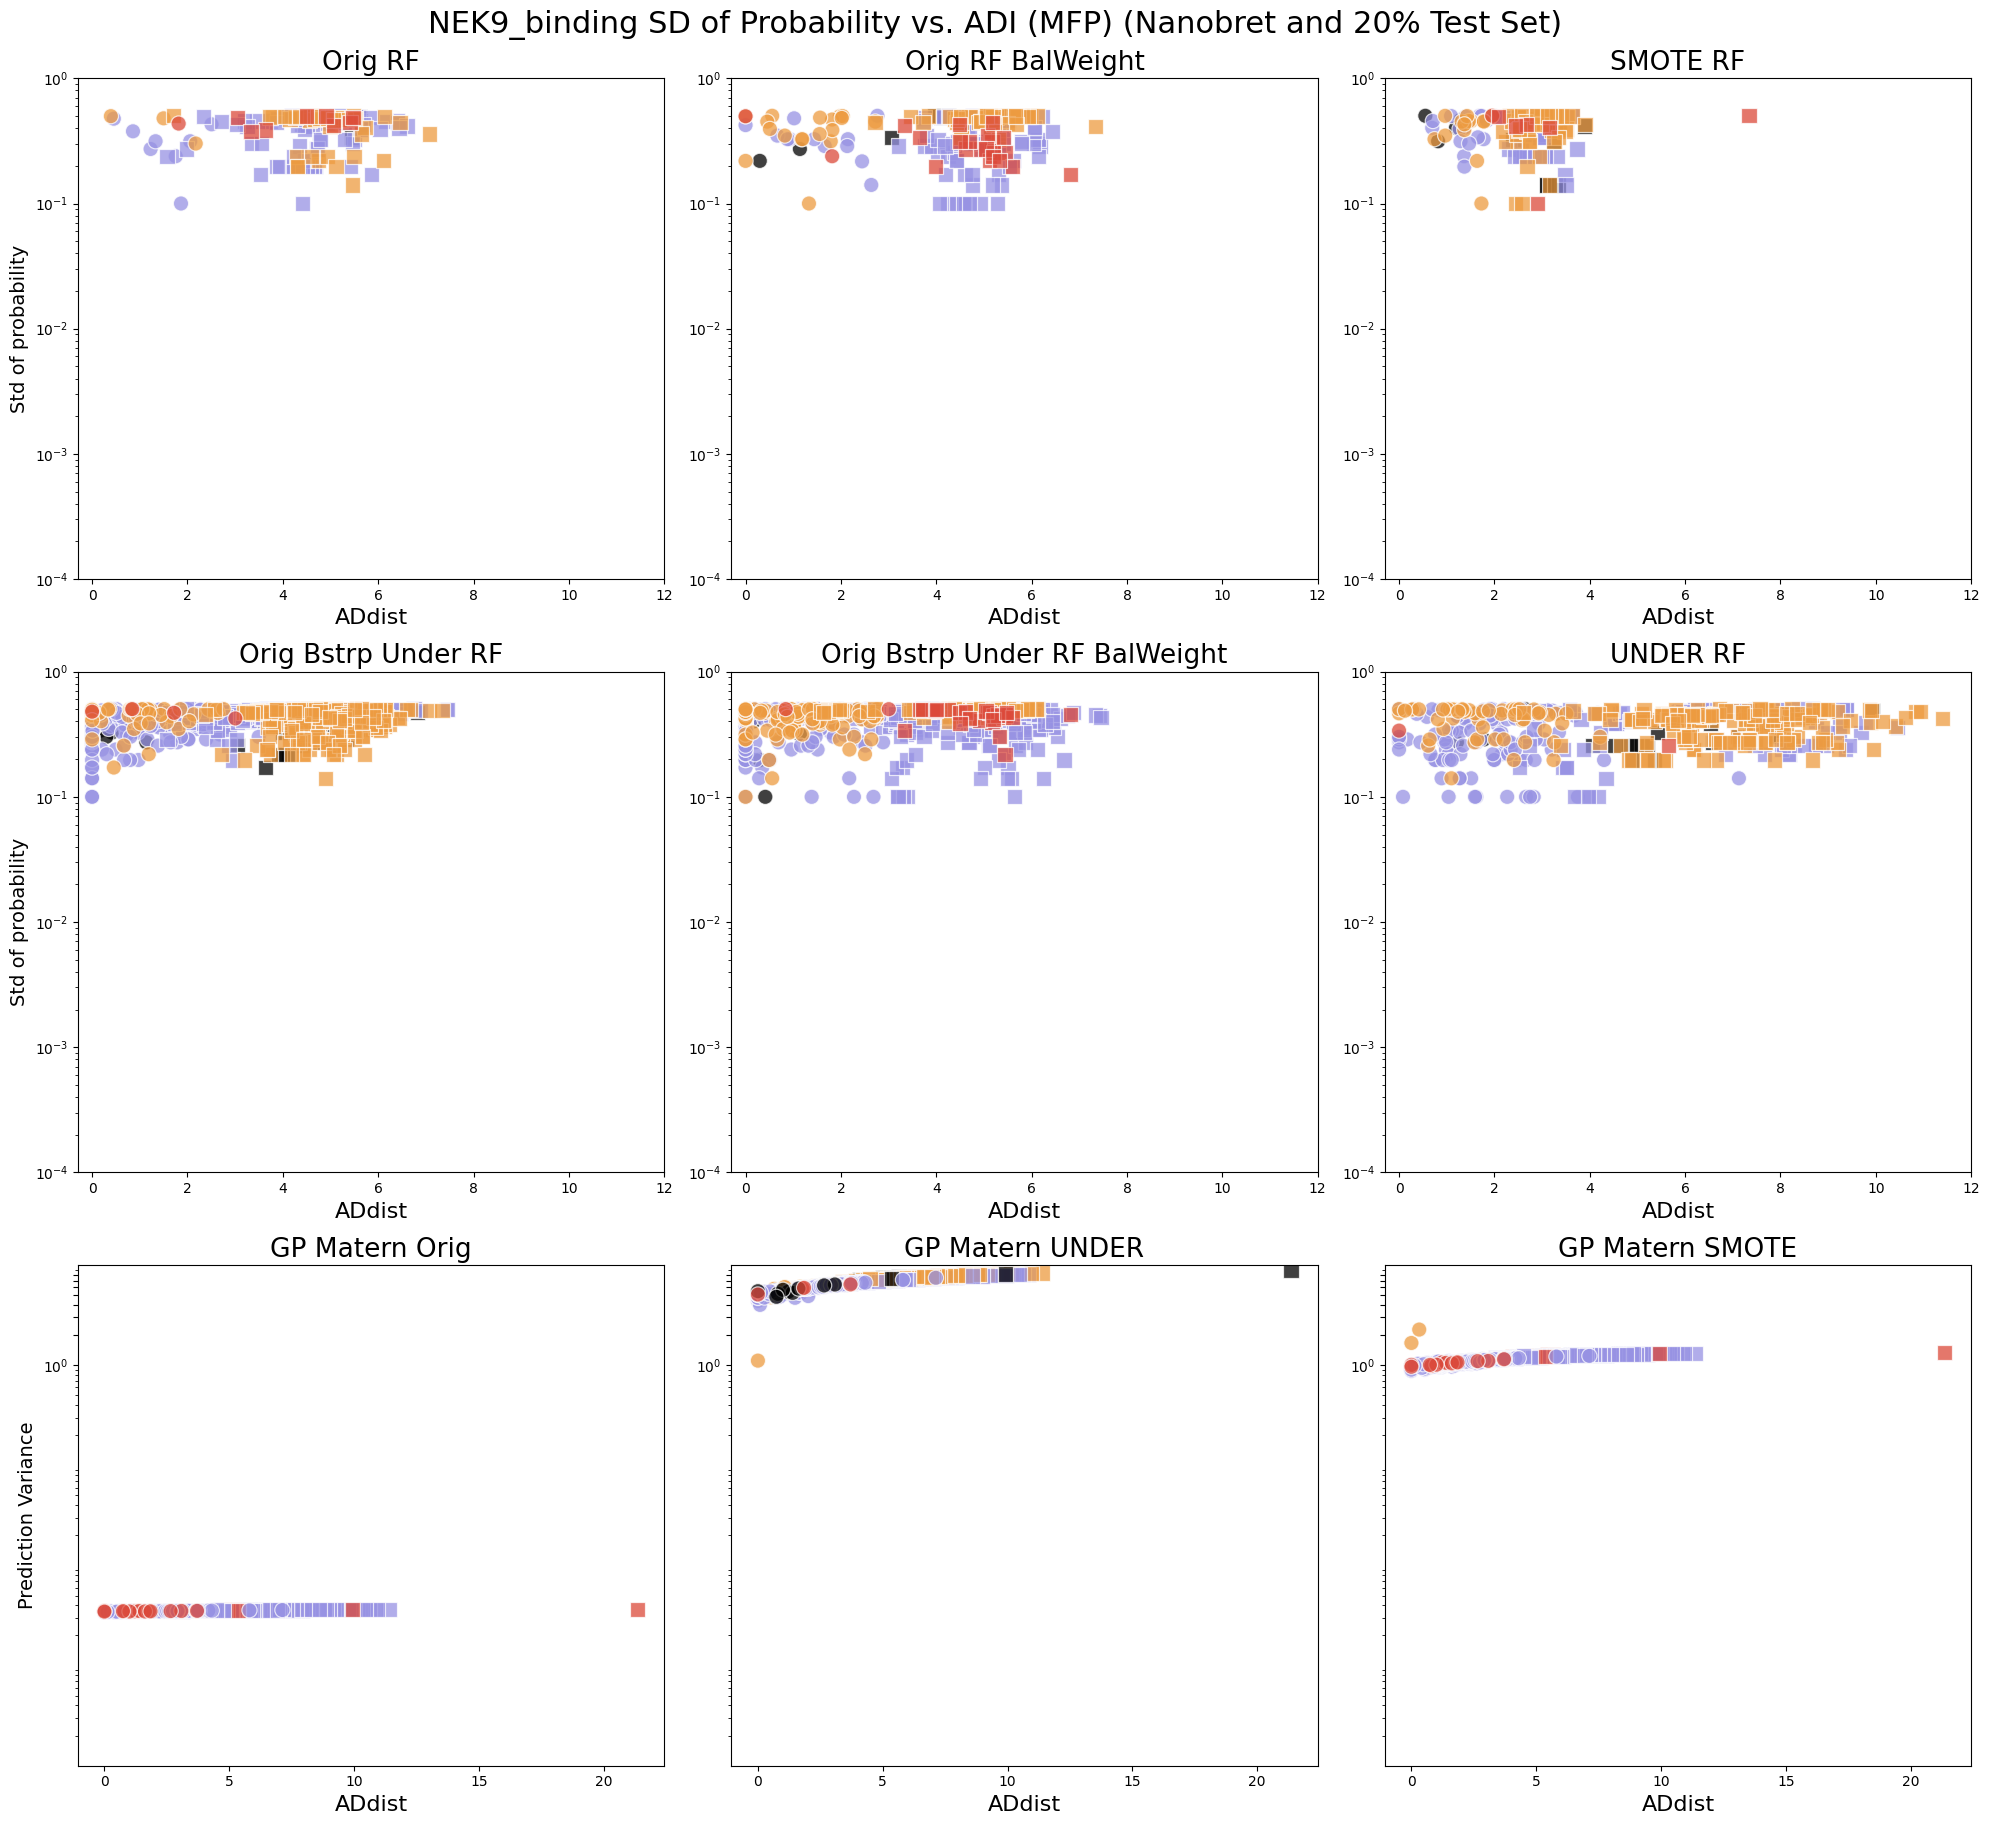

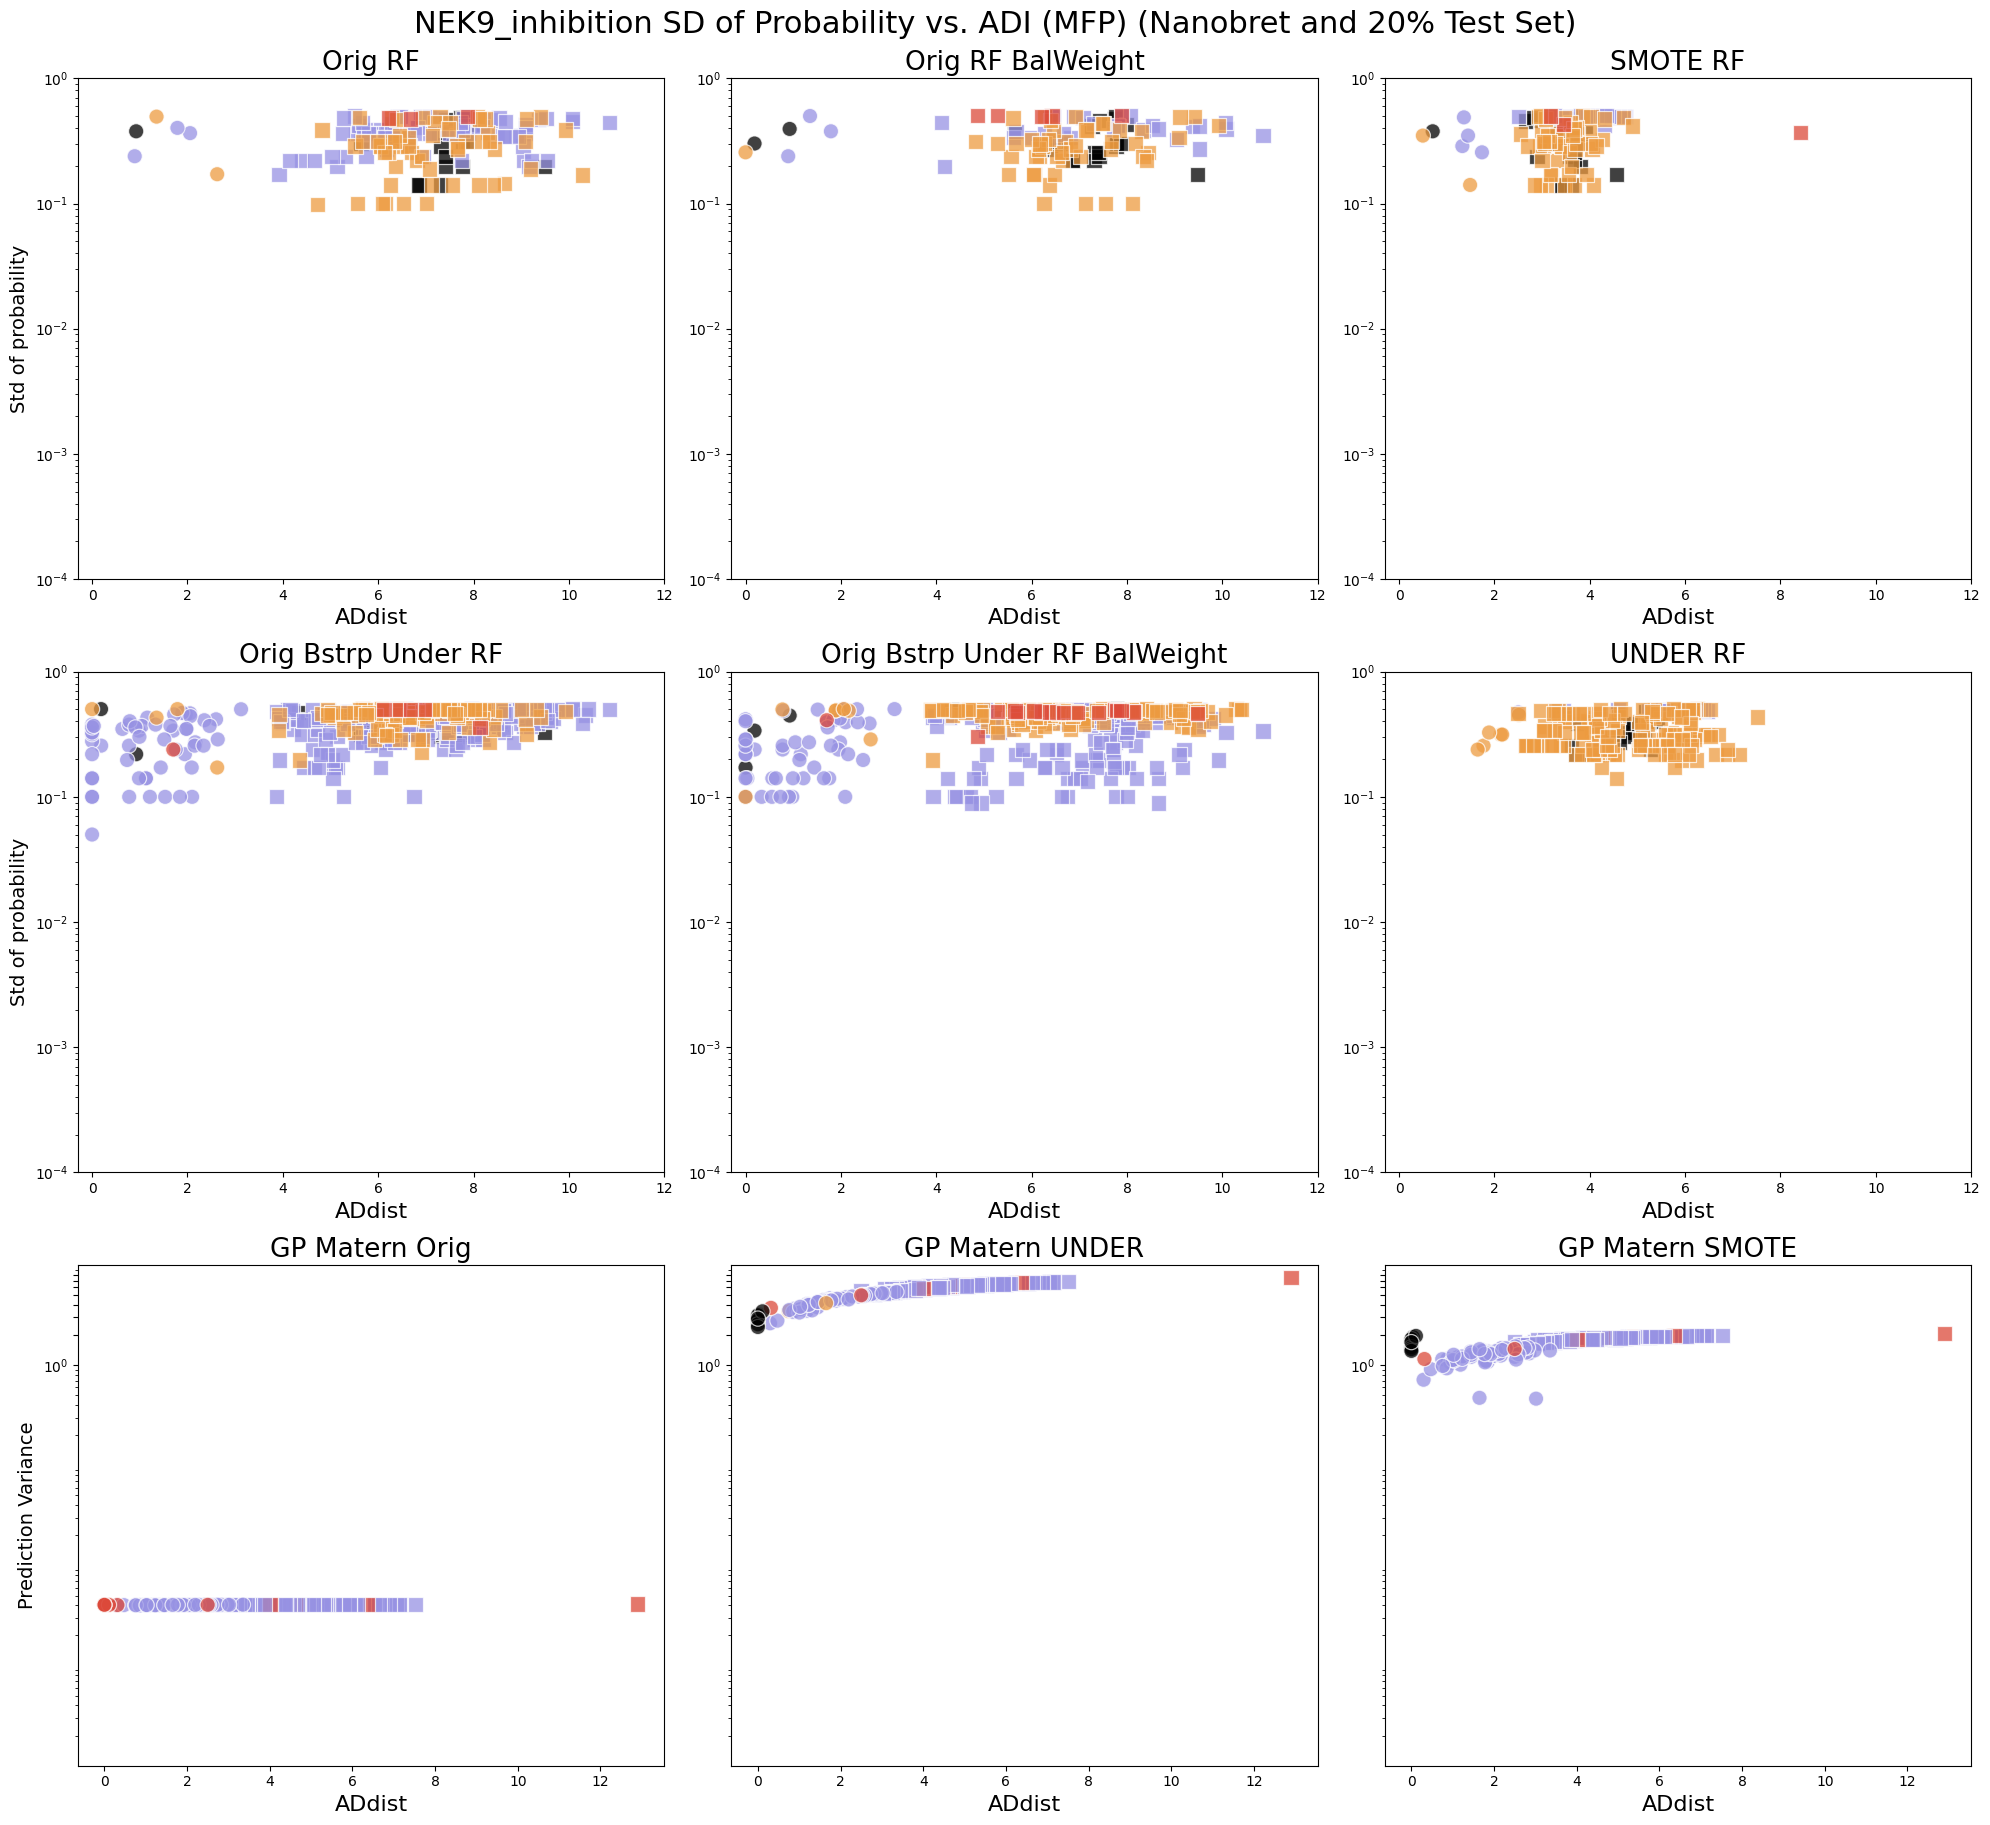

In [53]:
figpath = '/Users/jayceepang/msse/ATOM_CODE/UQ/all_sets/'
for nek in neks:
    short_nek = nek[:4] 

    nb_test_df = pd.read_csv(f'{datapath}{short_nek}_MFP_none_unscaled.csv').drop(columns=remove_cols)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    fig.suptitle(f'{nek} SD of Probability vs. ADI (MFP) (Nanobret and 20% Test Set)', fontsize=22,y=0.94)

    plt.subplots_adjust(hspace=.5)
    count=0
    for count, (samp,rf) in enumerate(sampling_combos):
        row = count//3
        col = count%3
        ax =axes[row,col]
        count += 1
        root_name = f'{nek}_MFP_{samp}'
        nb_rf_results_df = pd.read_csv(f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv')
        
        og_df = pd.read_csv(f'{og_datapath}{nek}_MFP_{samp}.csv') 
        train_df = og_df[og_df['subset'] == 'train'].drop(columns=remove_cols)
        ts1_test_df = og_df[og_df['subset'] == 'test'].drop(columns=remove_cols)
        
        ts1_rf_results_df = pd.read_csv(f'{og_rf_results_path}{nek}_MFP_{samp}_{rf}_prod_test.csv')
        
        with open(f'{model_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
            model = pickle.load(f) 
        
        nb_train_dist, nb_test_dist, nb_std0, nb_std1=get_plotting_data_RF_UQ2(model, train_df,nb_test_df)
        ts1_train_dist, ts1_test_dist, ts1_std0, ts1_std1=get_plotting_data_RF_UQ2(model, train_df,ts1_test_df)
        
        nb_rf_results_df['1-specificity'] = 1-nb_rf_results_df['specificity'] 
        nb_rf_true_labels =nb_rf_results_df['y'].to_numpy()
        nb_rf_results_df=change_names(nb_rf_results_df) 
        nb_rf_results_df['set'] = 'nanobret'
        nb_rf_results_df['std0'] = nb_std0
        nb_rf_results_df['std1'] = nb_std1
        nb_rf_results_df['ADdist'] = nb_test_dist
   

        ts1_rf_results_df['1-specificity'] = 1-ts1_rf_results_df['specificity'] 
        
        ts1_rf_results_df=change_names(ts1_rf_results_df) 
        ts1_rf_results_df['set'] = 'test'
        ts1_rf_results_df['std0'] = ts1_std0
        ts1_rf_results_df['std1'] = ts1_std1
        ts1_rf_results_df['ADdist'] = ts1_test_dist
        
        
        # if nb_rf_results_df.columns.tolist() == ts1_rf_results_df.columns.tolist():
        #     assert len(nb_rf_results_df) == len(nb_std0) == len(nb_test_dist)
        #     assert len(ts1_rf_results_df) == len(ts1_std0) == len(ts1_test_dist)
        rf_all_results = pd.concat([ts1_rf_results_df,nb_rf_results_df], ignore_index=True)
        samp_label=f'{name_strat_lookup[samp]} {name_strat_lookup[rf]}'
        title = (f'{samp_label}')
        # print(nek,
        #     rf_all_results[['std0', 'std1', 'ADdist']].describe())

        RF_scatter_stdprob_AD_sbuplots_SETS_logscale(rf_all_results, title, ax)
        if col == 0:
            ax.set_ylabel('Std of probability', fontsize=14)
     
        # print(nek,
        # hashlib.md5(pathlib.Path(path).read_bytes()).hexdigest())
    for col, samp2 in enumerate(['none_scaled','UNDER','SMOTE']):
        ax = axes[2, col]
        gp_nb_results = pd.read_csv(f'{nanobret_GP}{short_nek}_MFP_none_scaled_{nek}_{samp2}_GP_matern_nanobret_cellular_holdout.csv')
        gp_nb_dist, gp_nb_results_df=get_plotting_data_GP_UQ2(train_df, nb_test_df, gp_nb_results)
        gp_nb_results_df['set'] = 'nanobret'
        gp_nb_results_df = gp_nb_results_df[gp_cols]
        gp_ts1_results = pd.read_csv(f'{og_gp_results_path}{nek}_MFP_{samp2}_matern_prod_test.csv')
        # {feat}_{samp}_{kernel}
        gp_ts1_dist, gp_ts1_results_df=get_plotting_data_GP_UQ2(train_df, ts1_test_df, gp_ts1_results)
        gp_ts1_results_df['set'] = 'test'
        gp_ts1_results_df = gp_ts1_results_df[gp_cols]
        if gp_nb_results_df.columns.tolist() == gp_ts1_results_df.columns.tolist():

            gp_all_results = pd.concat([gp_nb_results_df,gp_ts1_results_df], ignore_index=True)
        
        GP_scatter_varpred_AD_sbuplots_SETS_logscale(gp_all_results,ax, ylabel_on=False)
        if col == 0:
            ax.set_ylabel('Prediction Variance', fontsize=14)
    
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    fig.savefig(f'{figpath}{nek}_RFGP_allsets_UQ_scatter_logscale.png', bbox_inches='tight')



# Color by test set

In [62]:
def GP_scatter_varpred_AD_sbuplots_SETS_color(df,ax, palette=pred_palette, ylabel_on=True,figure_path=None, filename=None):
    true_labels = df['y'] 
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    df['prediction variance'] = np.nan
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    feat=df['feat_type'].iloc[0]
    samp=df['strategy'].iloc[0]
    sizes = df['prediction_type'].map(pred_sizes)

    sns.scatterplot(data=df, x='ADdist', y='prediction variance', hue='set', palette=palette,
           style='set',markers=set_markers,ax=ax,s=120,alpha=0.75)
    # samp_label=f'{df["feat_type"].iloc[0]} {df["strategy"].iloc[0]}'
    
    samp_label=f'GP Matern {df["strategy"].iloc[0]}'
    if df["strategy"].iloc[0] == 'none_scaled': 
        samp_label=f'GP Matern Orig'
    title = f'{samp_label}'
    # title = f'{samp_label}\n1-specificity: {df["1-specificity"].iloc[0]:.2f}, sensitivity: {df["recall"].iloc[0]:.2f}'
    ax.set_title(f'{title}',fontsize=19)
    ax.set_yticks(np.arange(0,9, step=1))
    ax.get_legend().remove()
    ax.set_xlabel('ADdist', fontsize=16)
    if ylabel_on: 
        ax.set_ylabel('Predictive Variance', fontsize=16)
    else: 
        ax.set_ylabel('', fontsize=16)
        
    ax.set_ylim(-0.1, 9)
    ax.set_xlim(-.30,12) 


def RF_scatter_stdprob_AD_sbuplots_SETS_color(df, title, ax, palette=pred_palette):
    predictions = df['prediction'].to_numpy()
    true_labels = df['y'].to_numpy()
    std0 = df['std0'].to_numpy()
    std1 = df['std1'].to_numpy()
    ad_dist = df['ADdist'].to_numpy()
    set_vals = df['set'].to_numpy()

    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    fn_std0 = std0[false_neg] # NEW MAR 29 2025
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]

    data = {'std of probabilities': np.concatenate([std1[true_pos],std0[true_neg],std1[false_pos],std0[false_neg]]),
        'prediction_type': (['TP'] * len(true_pos) +['TN'] * len(true_neg) +['FP'] * len(false_pos) +['FN'] * len(false_neg)),
        'ADdist': np.concatenate([
            ad_dist[true_pos],ad_dist[true_neg],ad_dist[false_pos],ad_dist[false_neg]]),
        'set': np.concatenate([
            set_vals[true_pos],set_vals[true_neg],
            set_vals[false_pos],set_vals[false_neg]])}
    plot_df = pd.DataFrame(data)

    sns.scatterplot(data=plot_df, x='ADdist', y='std of probabilities', hue='set', palette=palette,
           style='set',markers=set_markers,ax=ax,s=120,alpha=0.75)
    ax.set_title(title, fontsize=19)
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    # ax.set_ylabel('SD of probability', fontsize=15)
    ax.set_ylabel('')
    ax.set_ylim(-0.01, 0.51)
    ax.set_xlim(-.30,12) 

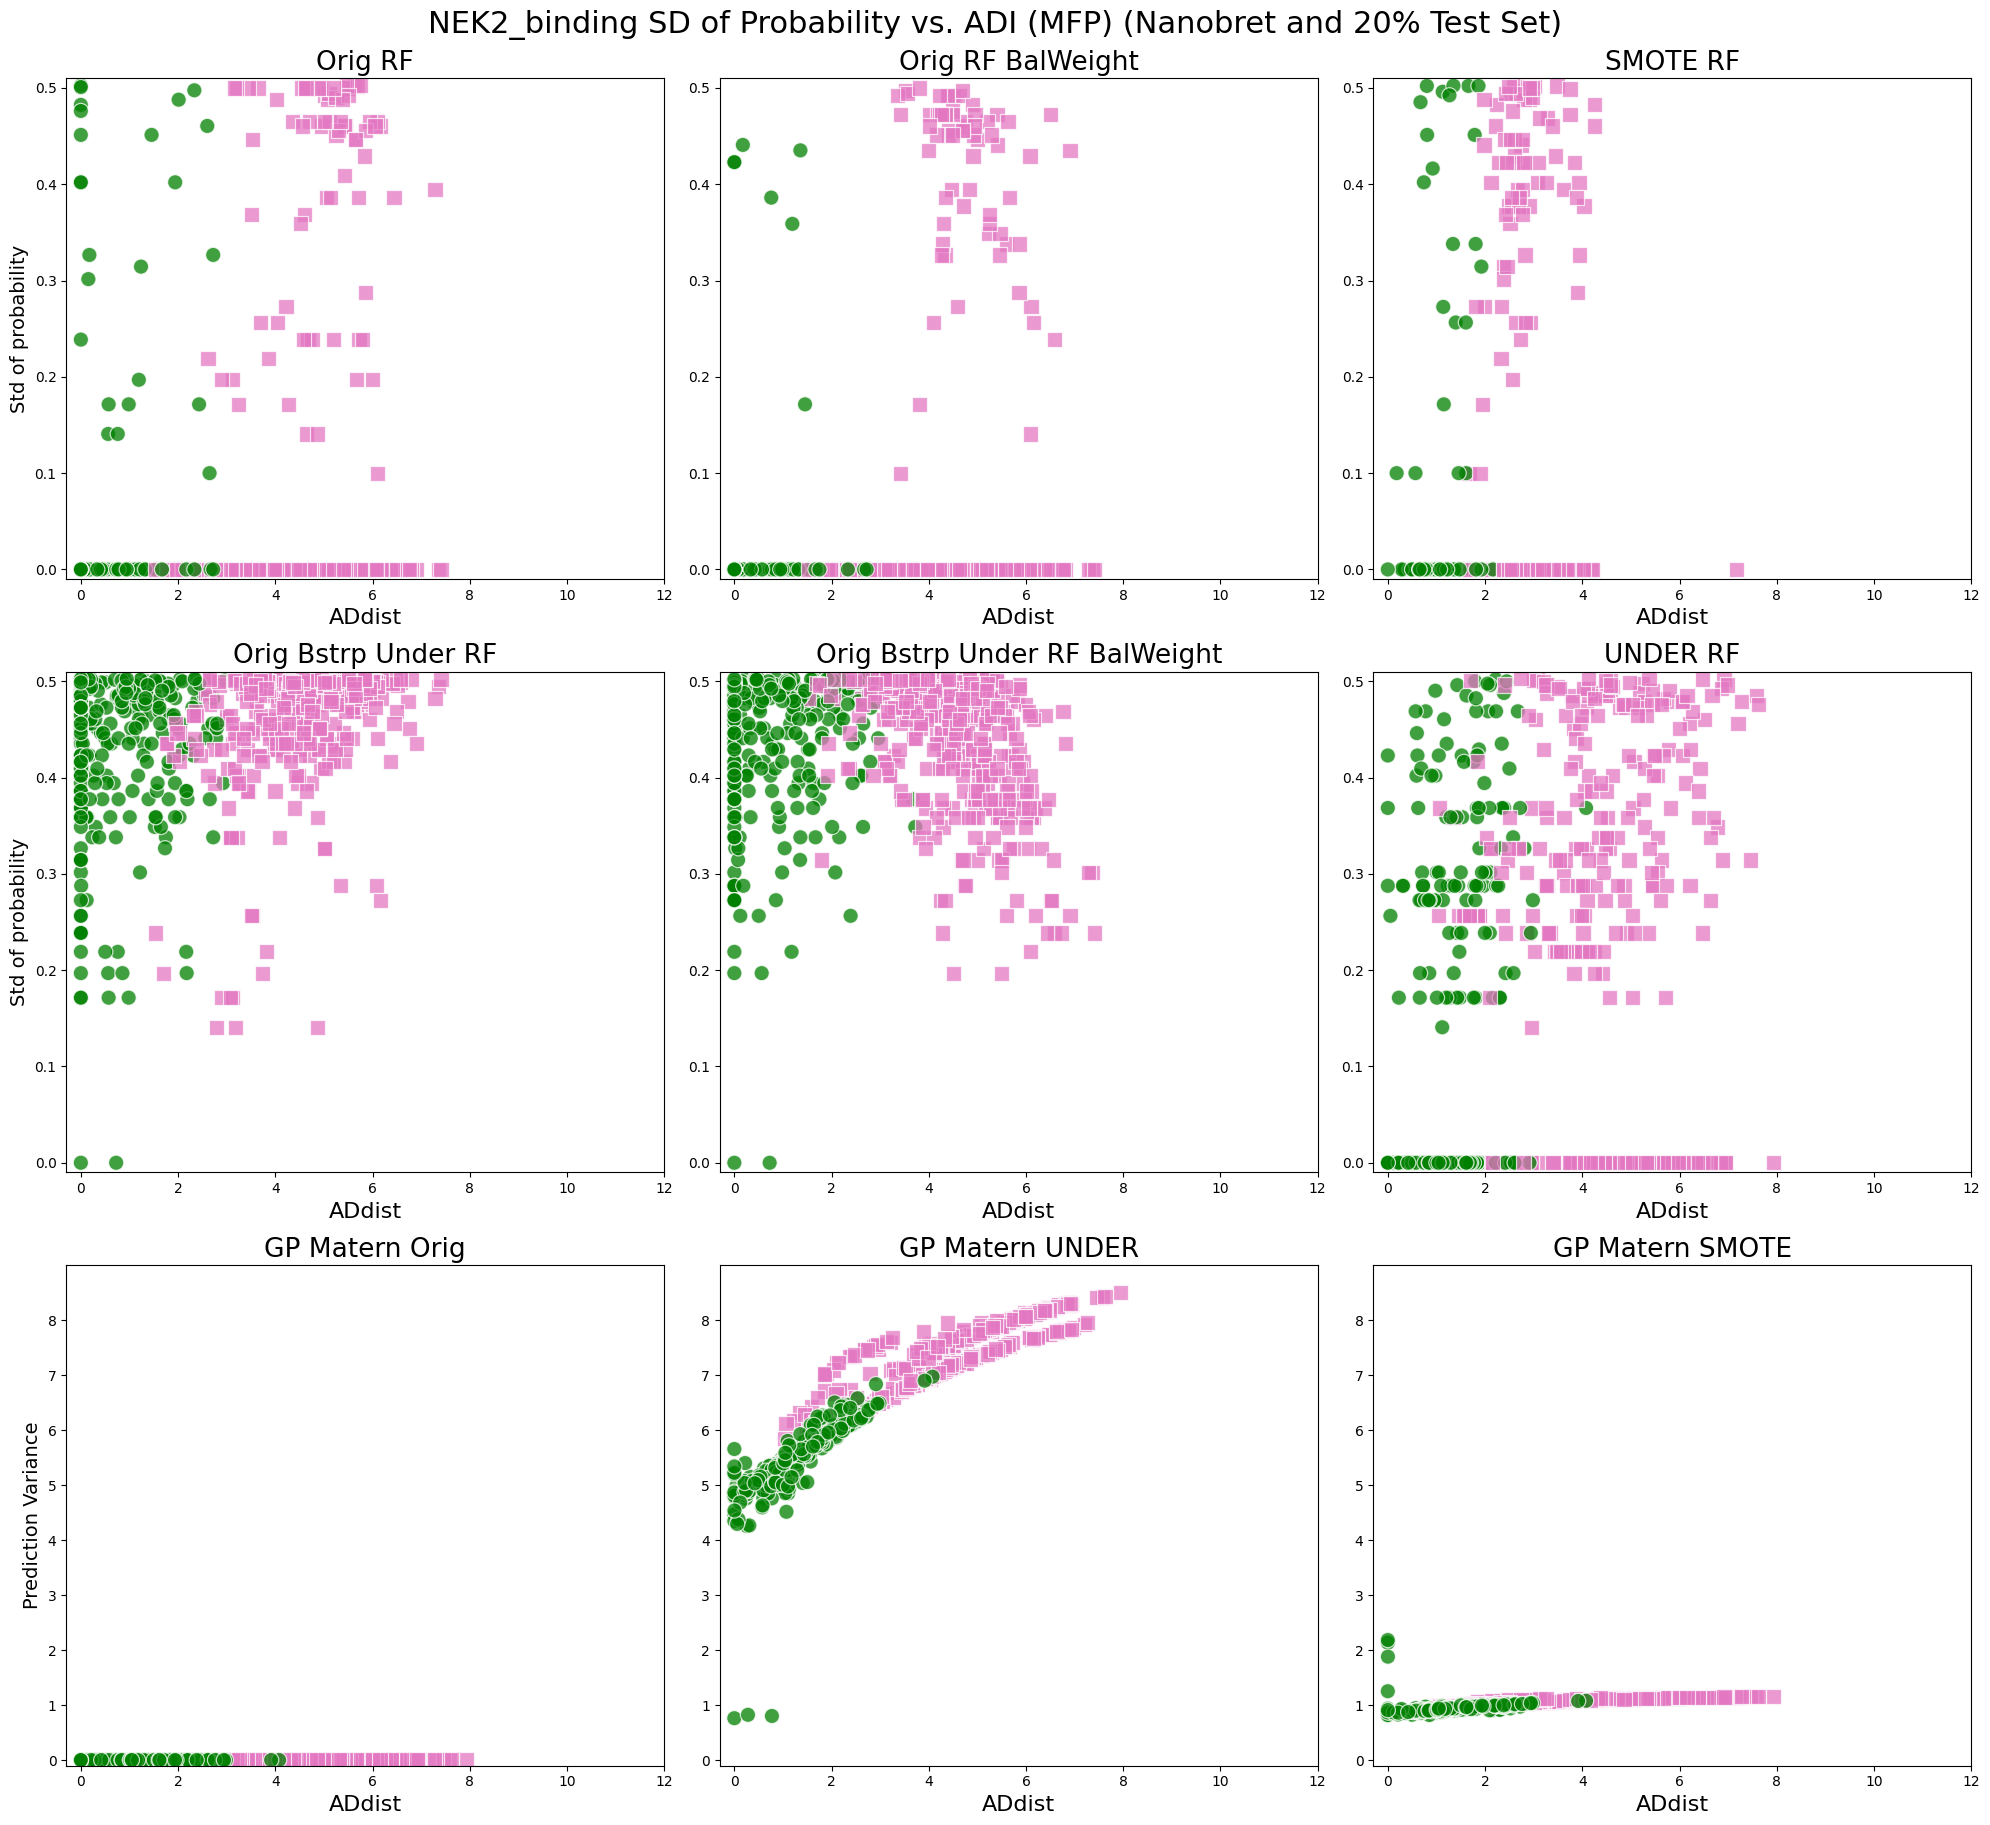

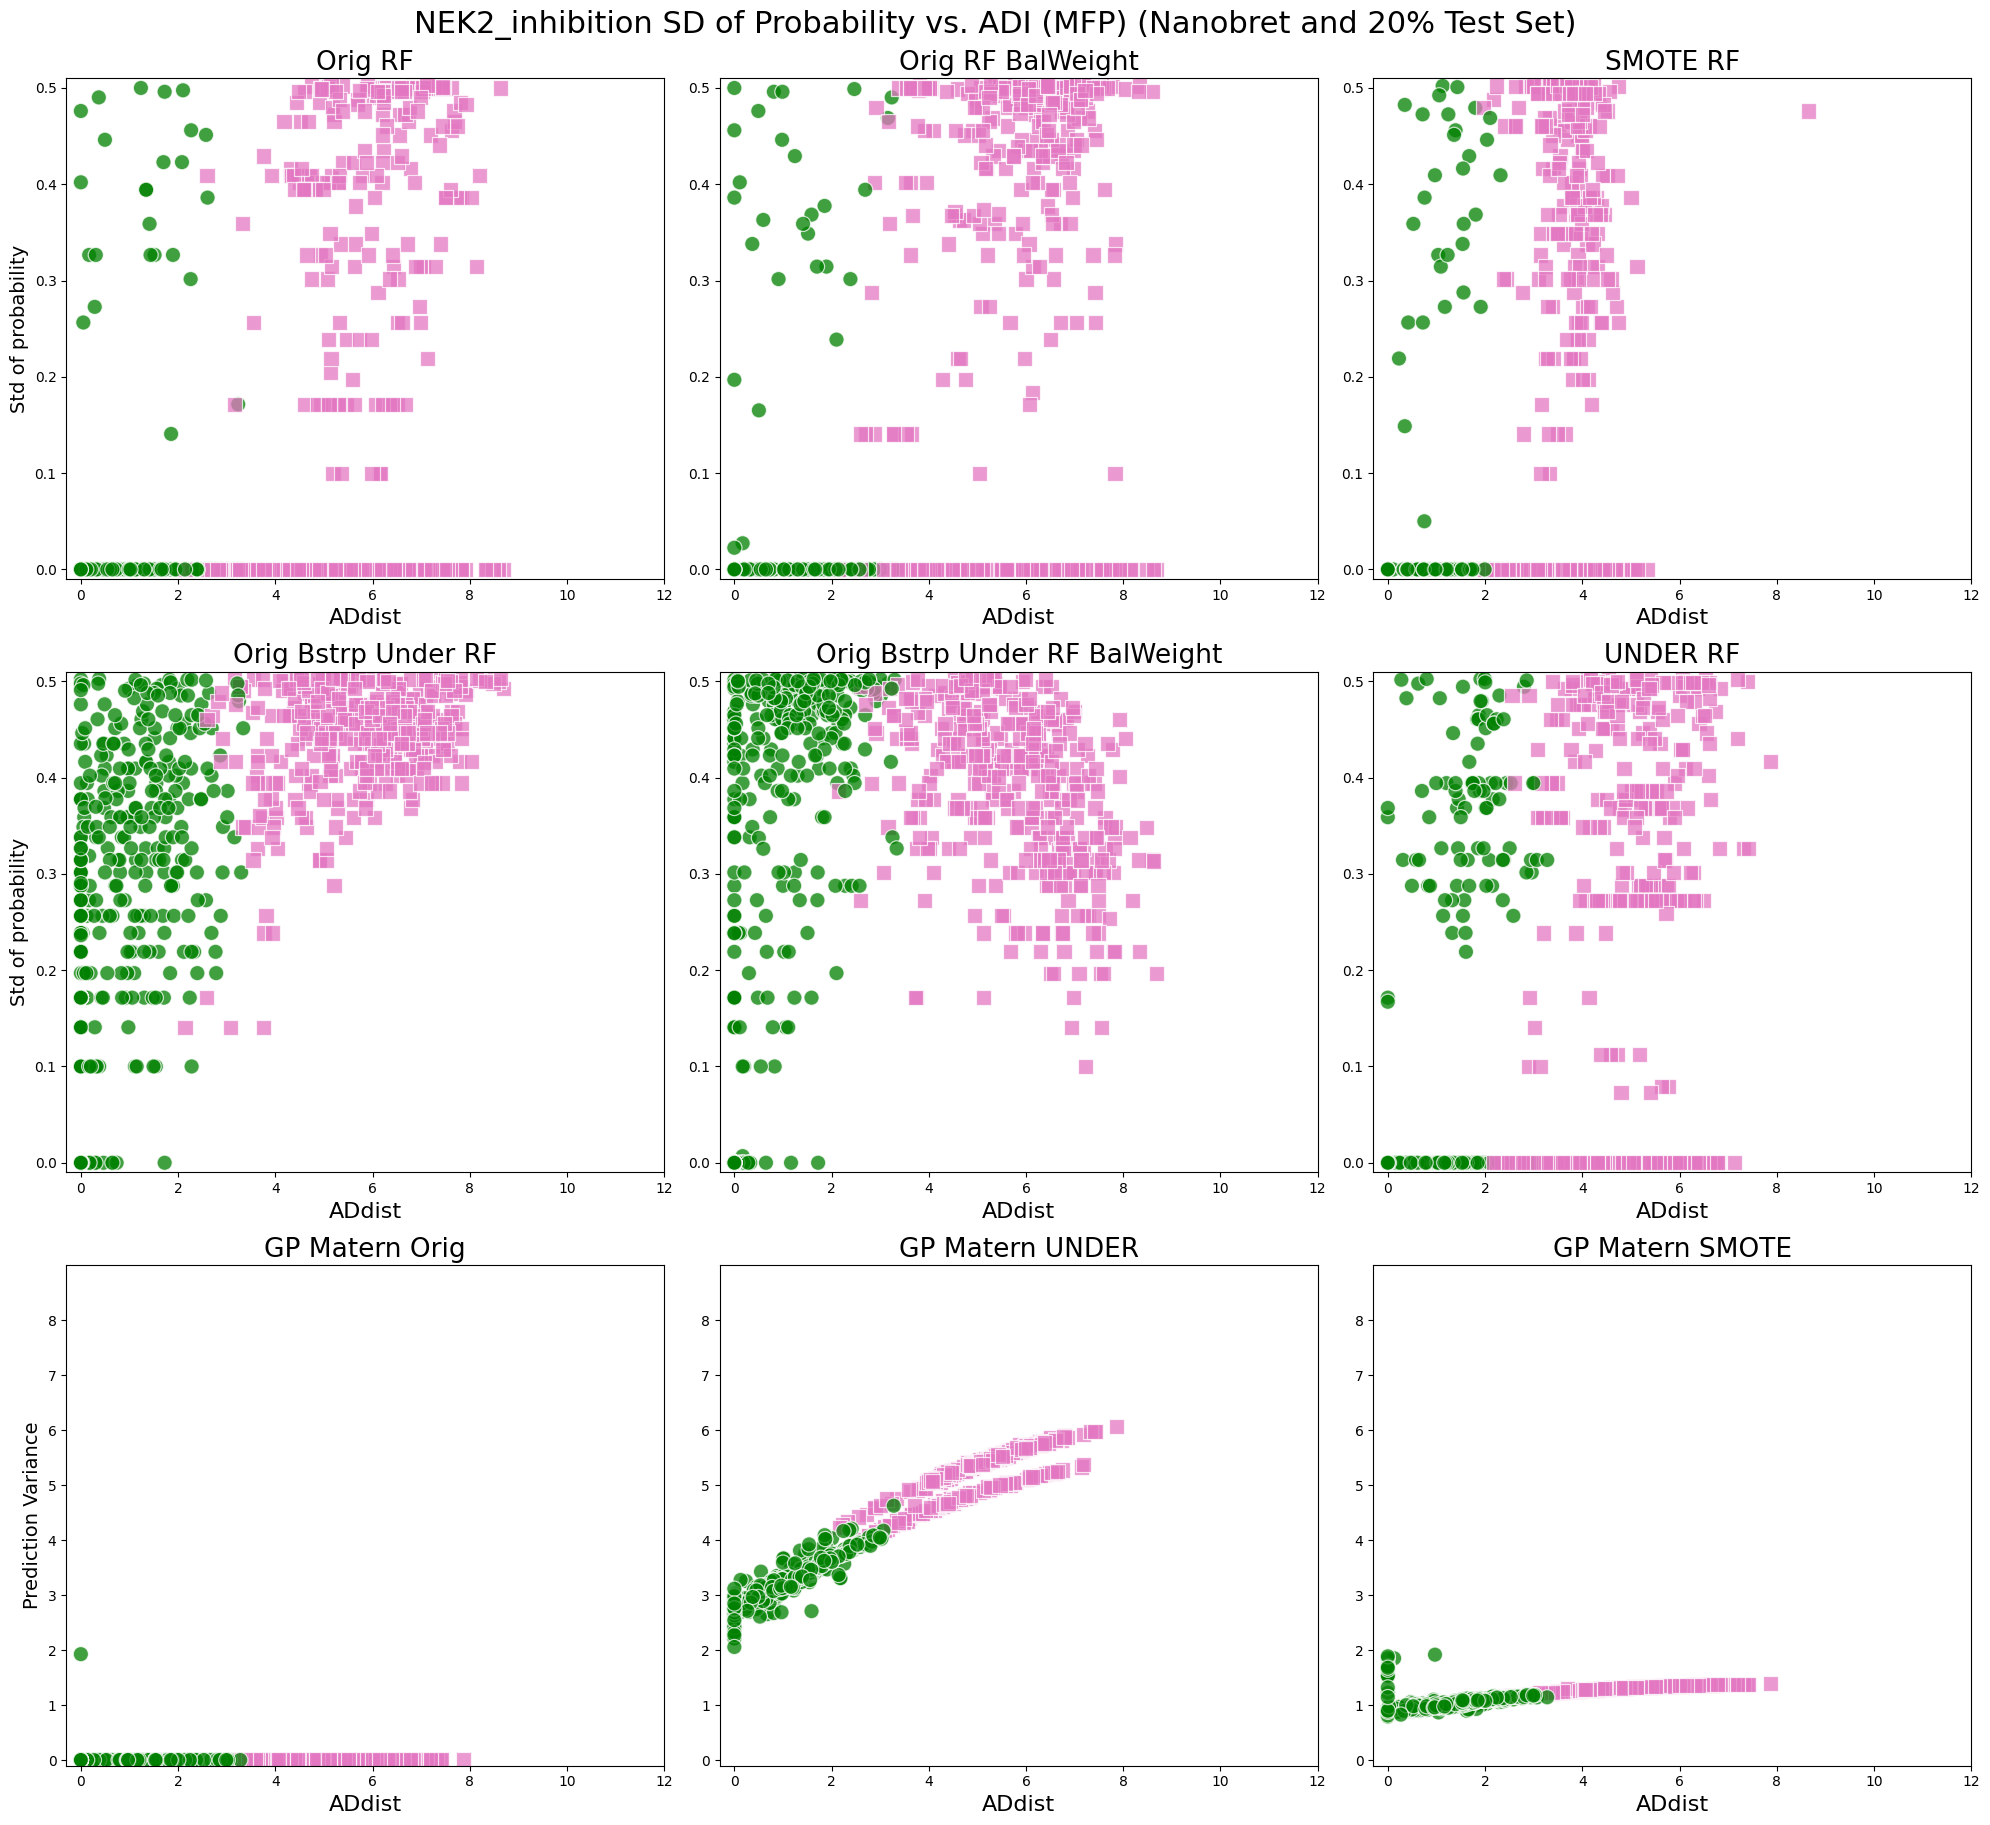

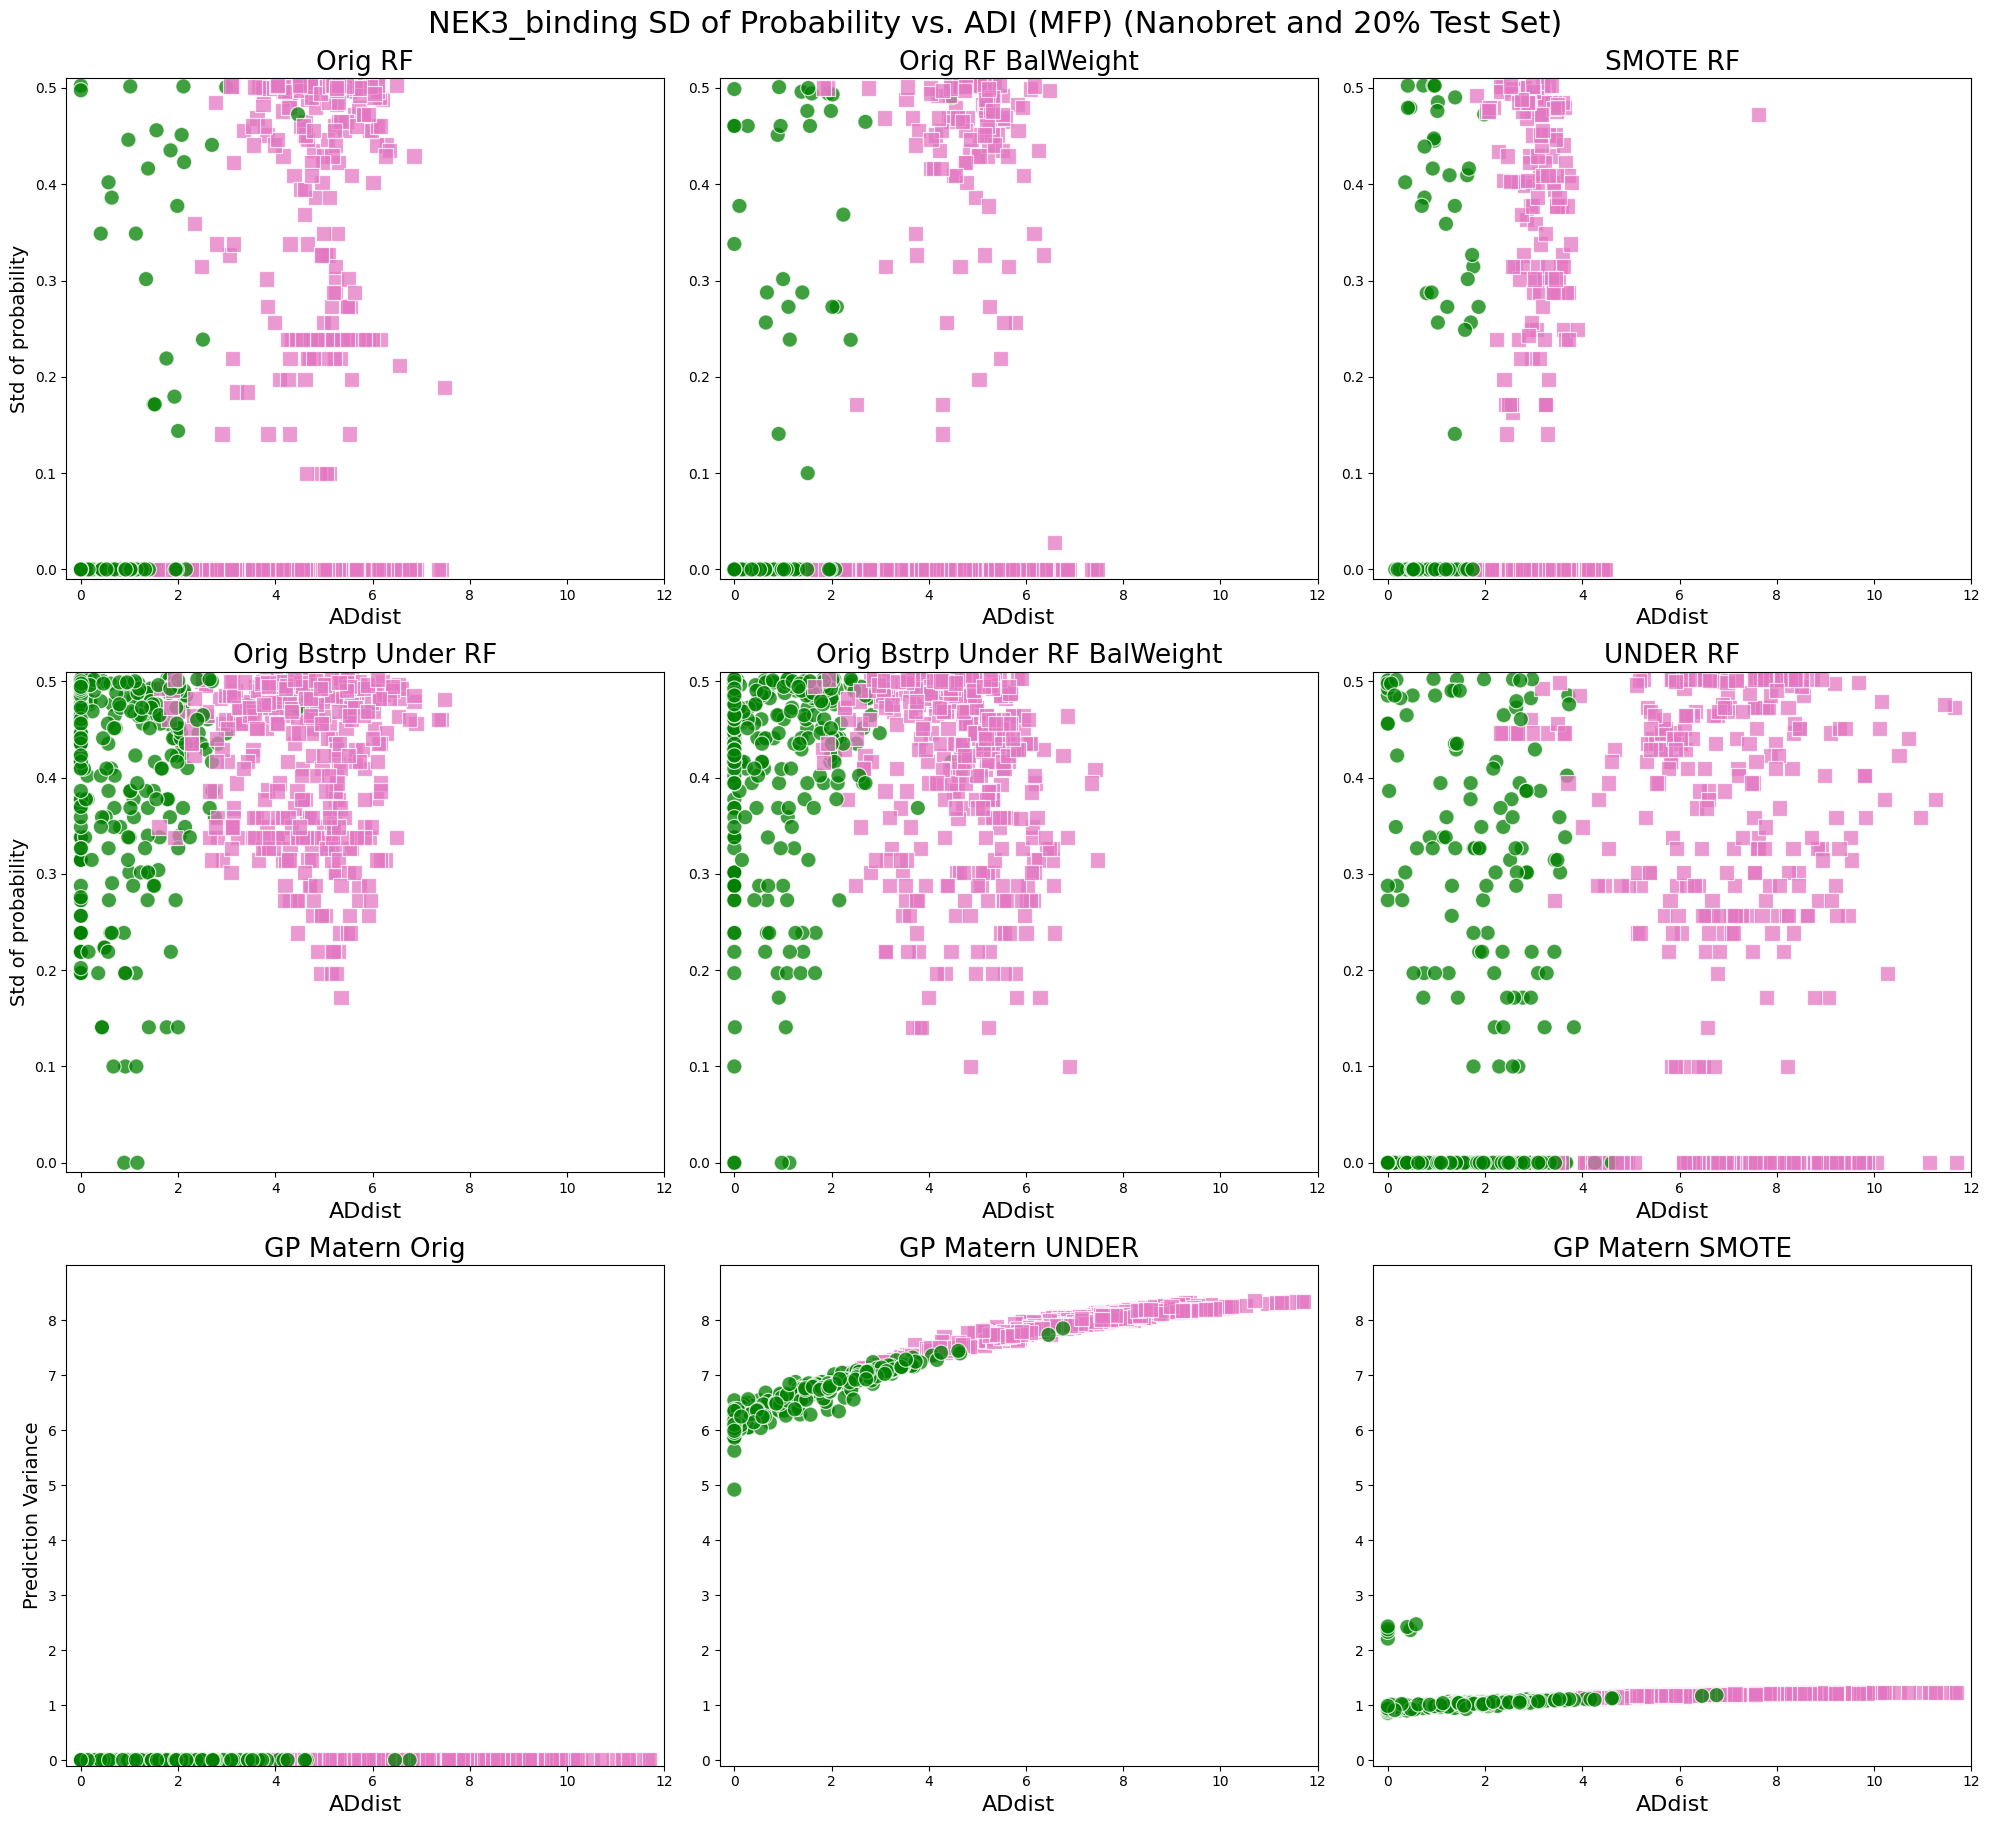

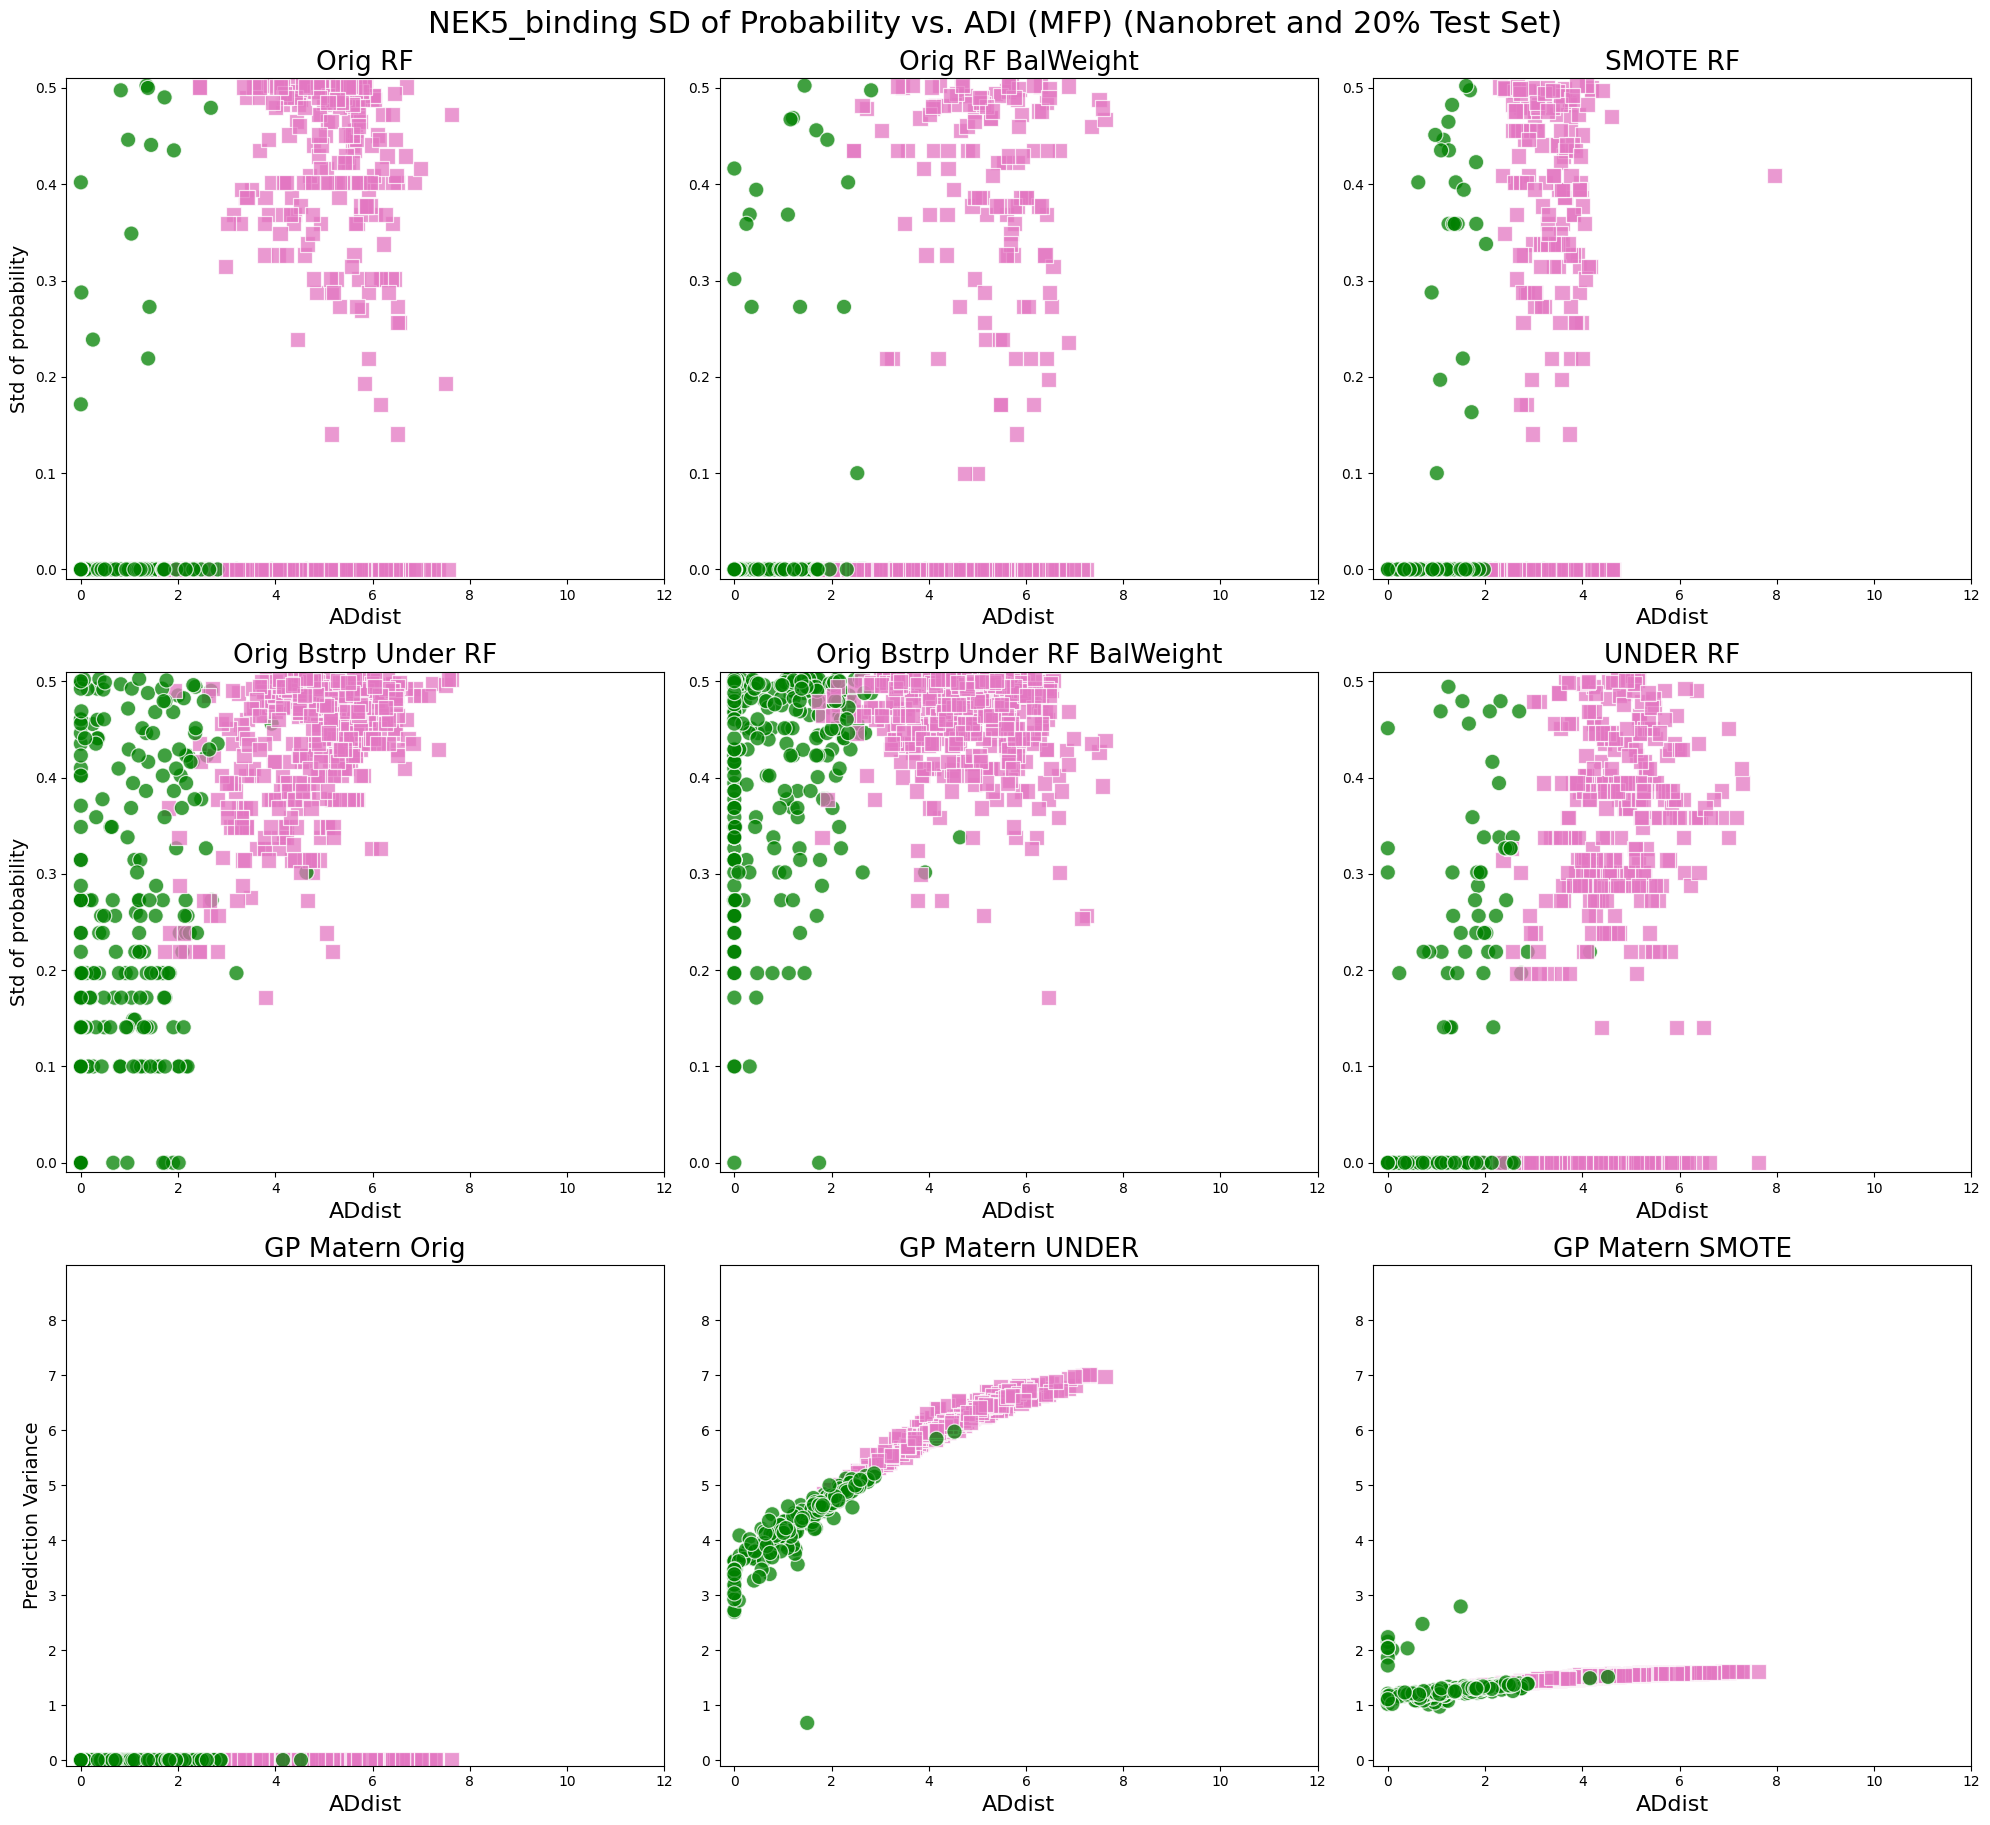

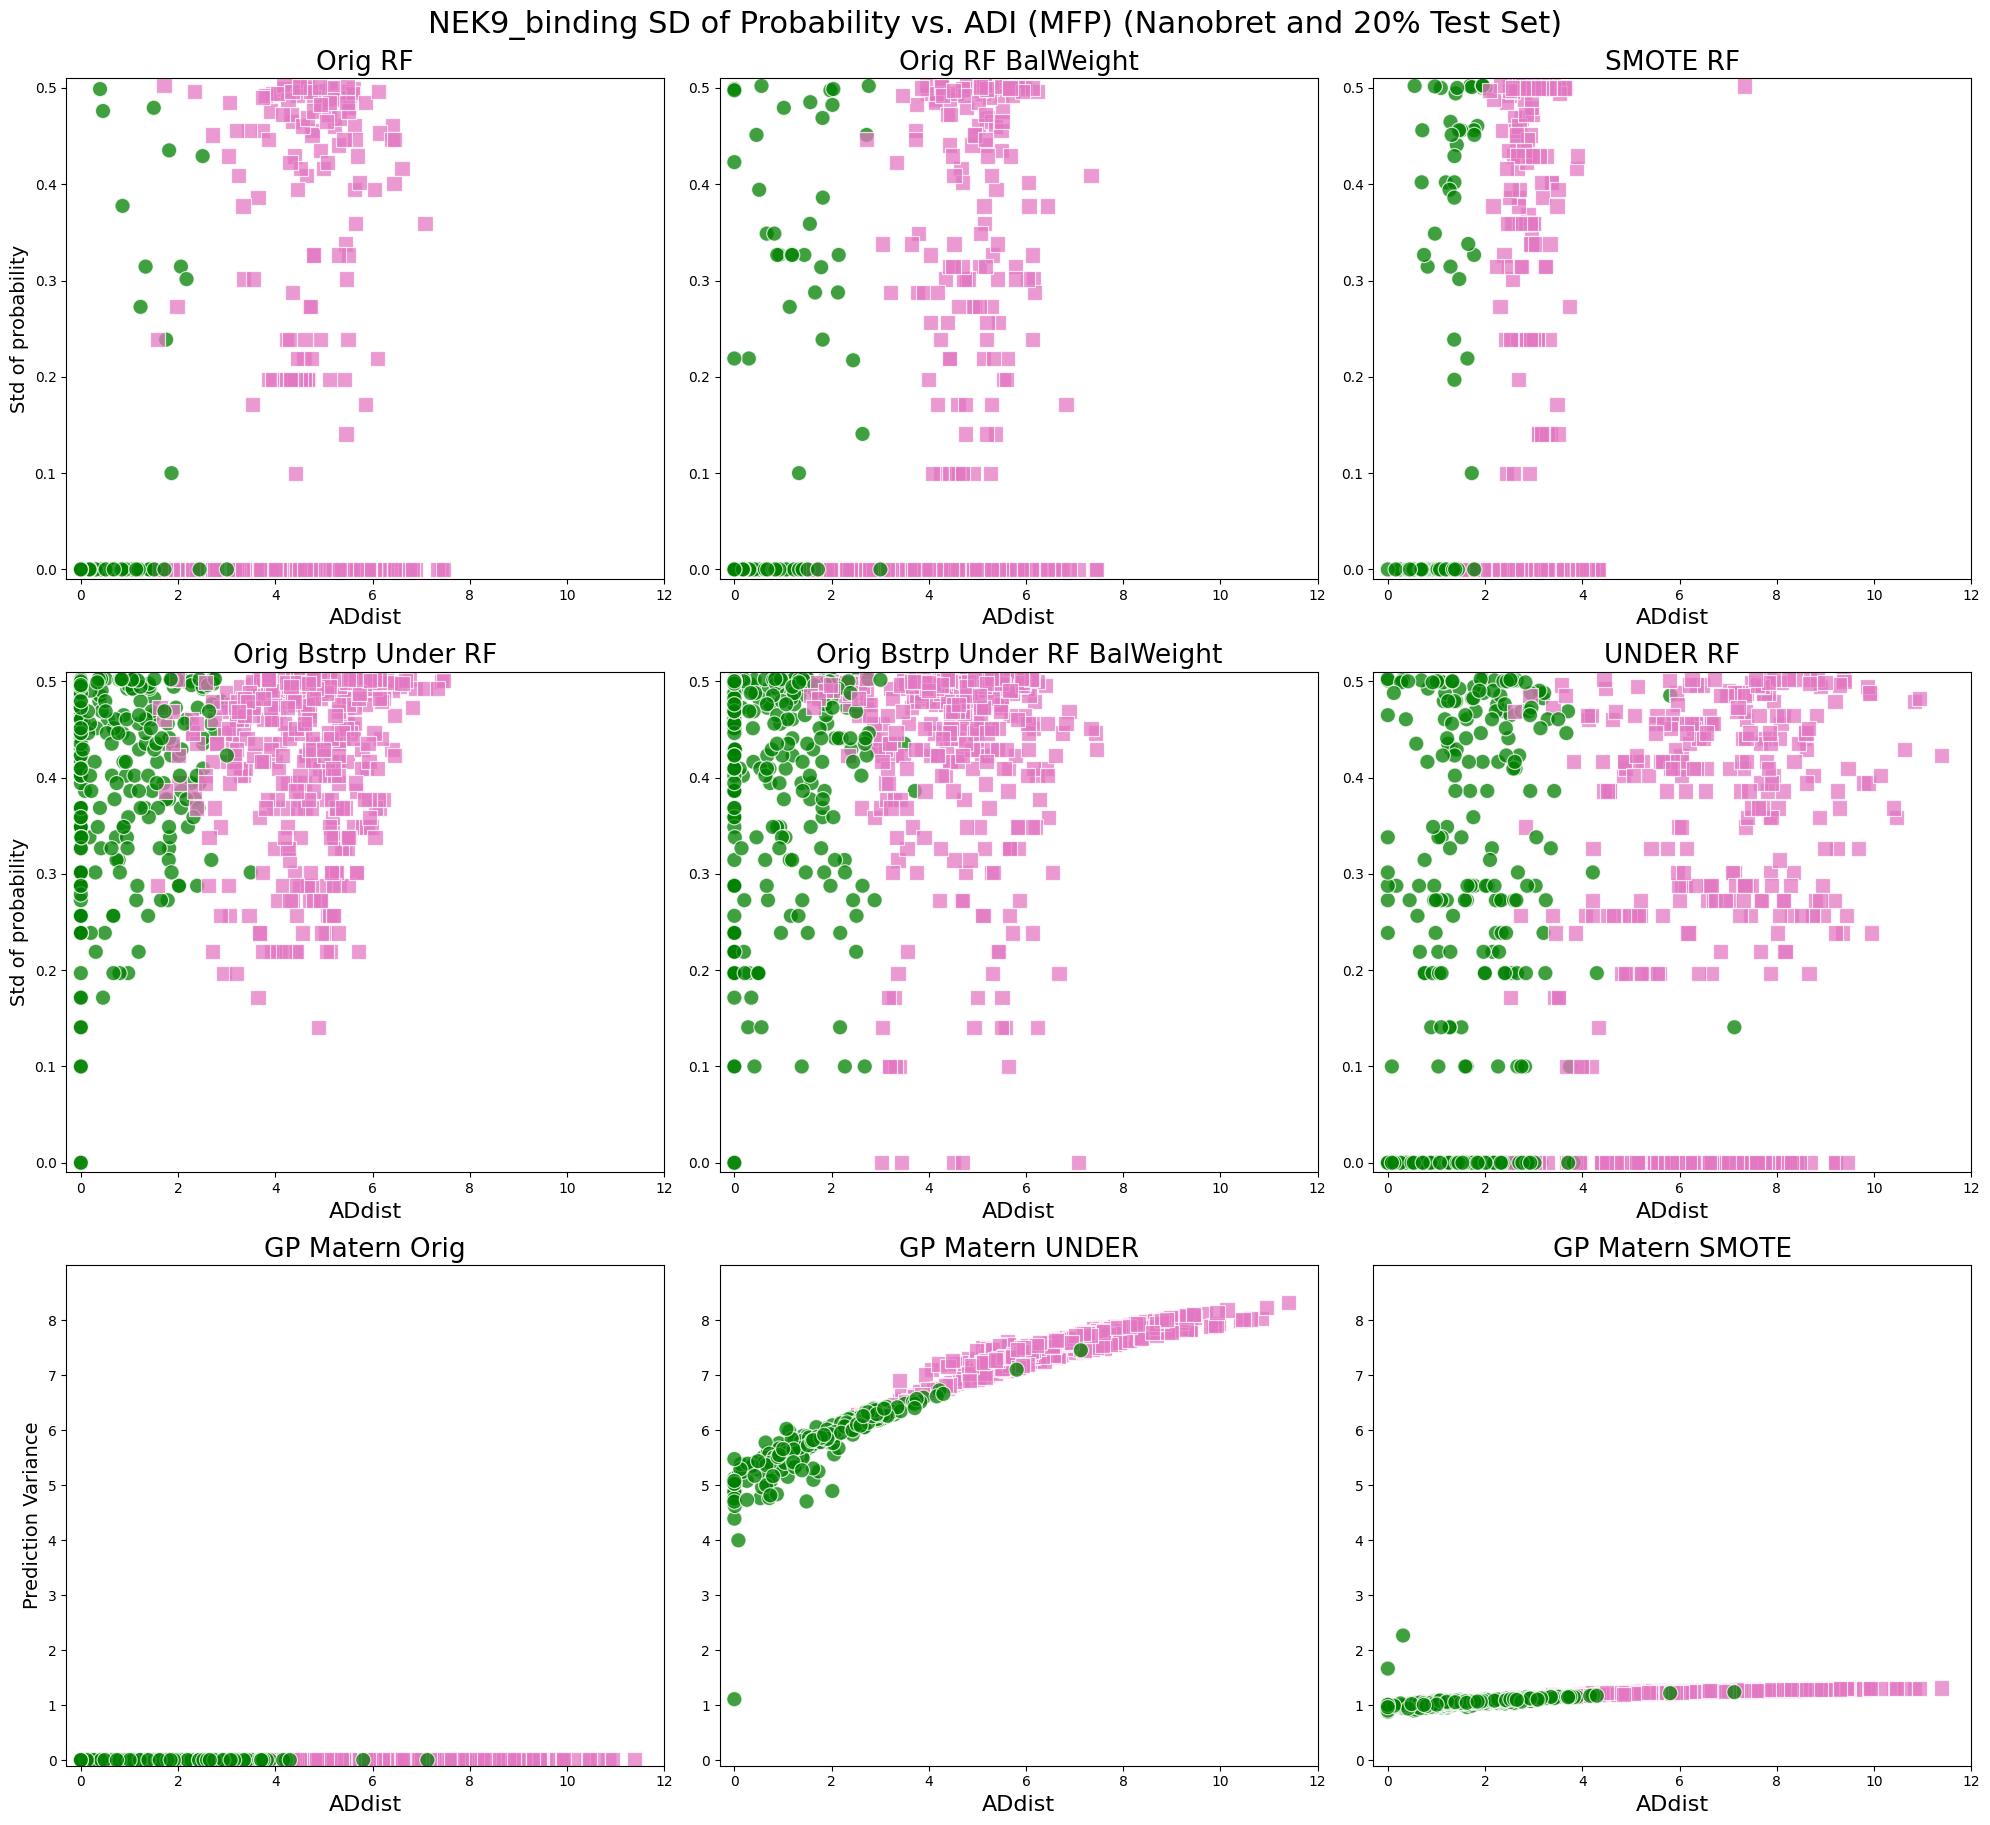

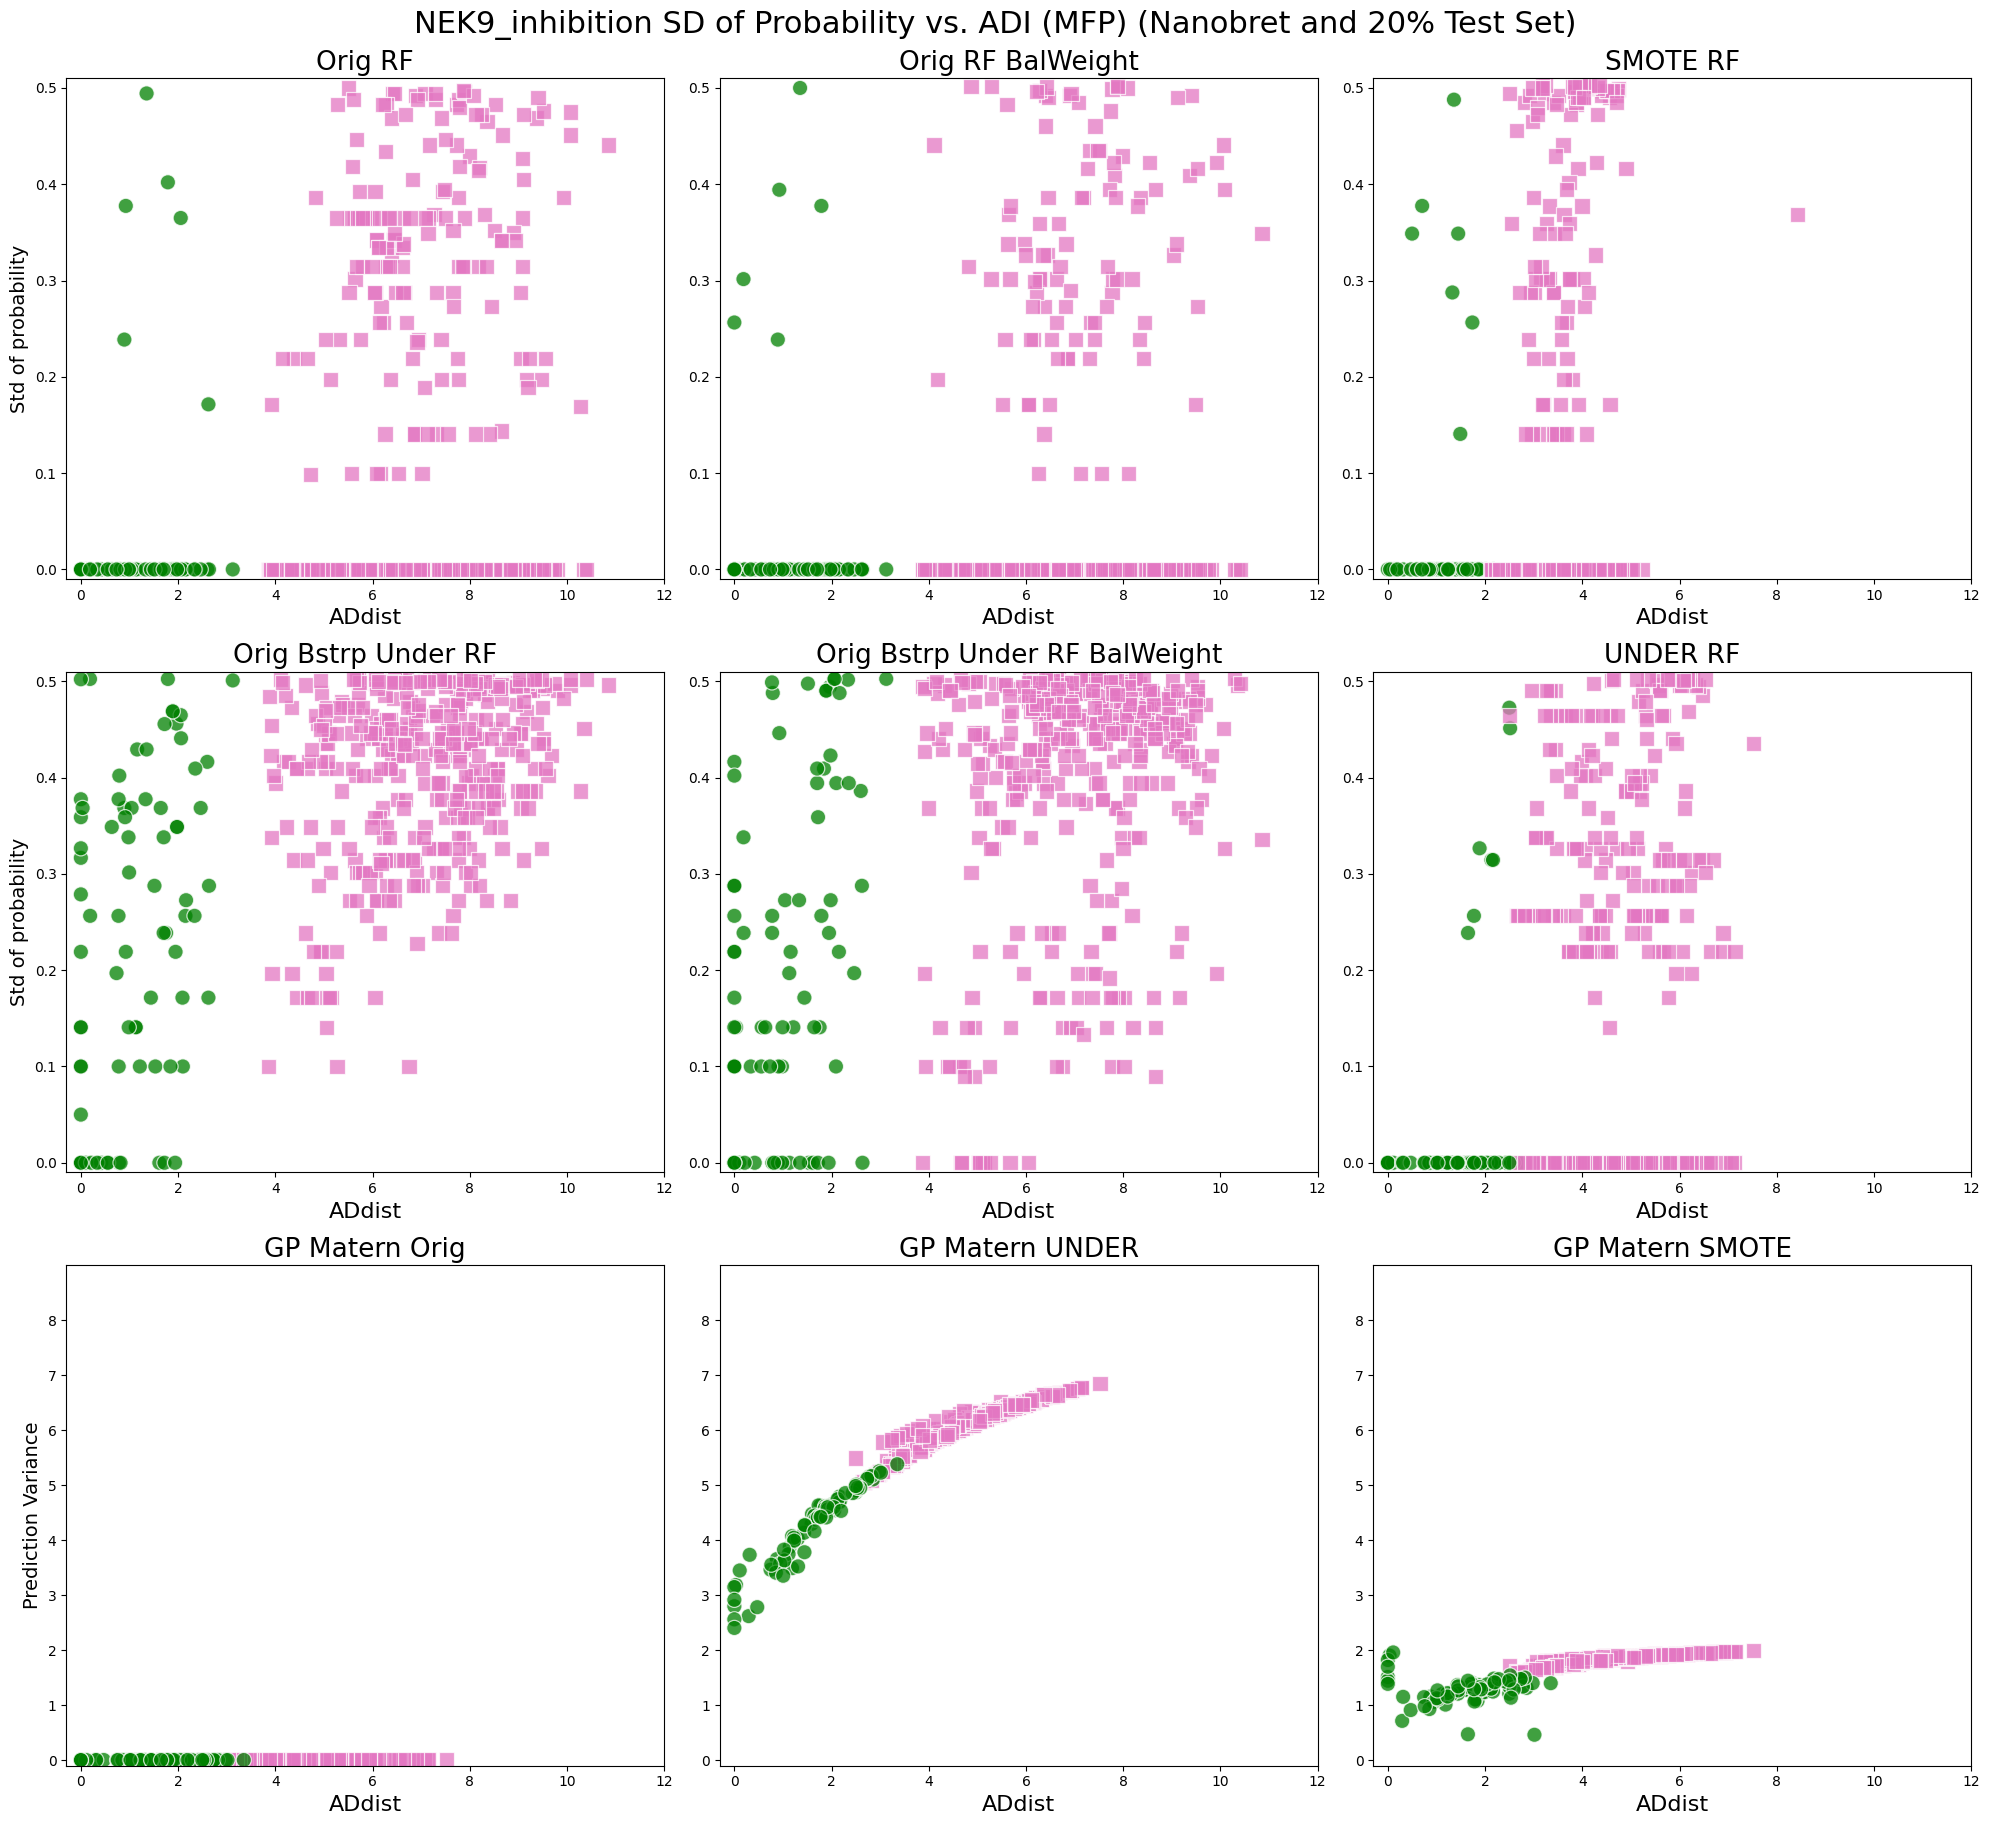

In [65]:
set_palette =  {'nanobret' : 'tab:pink', 'test': 'green'}
figpath = '/Users/jayceepang/msse/ATOM_CODE/UQ/all_sets/'
for nek in neks:
    short_nek = nek[:4] 

    nb_test_df = pd.read_csv(f'{datapath}{short_nek}_MFP_none_unscaled.csv').drop(columns=remove_cols)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    fig.suptitle(f'{nek} SD of Probability vs. ADI (MFP) (Nanobret and 20% Test Set)', fontsize=22,y=0.94)

    plt.subplots_adjust(hspace=.5)
    count=0
    for count, (samp,rf) in enumerate(sampling_combos):
        row = count//3
        col = count%3
        ax =axes[row,col]
        count += 1
        root_name = f'{nek}_MFP_{samp}'
        nb_rf_results_df = pd.read_csv(f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv')
        
        og_df = pd.read_csv(f'{og_datapath}{nek}_MFP_{samp}.csv') 
        train_df = og_df[og_df['subset'] == 'train'].drop(columns=remove_cols)
        ts1_test_df = og_df[og_df['subset'] == 'test'].drop(columns=remove_cols)
        
        ts1_rf_results_df = pd.read_csv(f'{og_rf_results_path}{nek}_MFP_{samp}_{rf}_prod_test.csv')
        
        with open(f'{model_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
            model = pickle.load(f) 
        
        nb_train_dist, nb_test_dist, nb_std0, nb_std1=get_plotting_data_RF_UQ2(model, train_df,nb_test_df)
        ts1_train_dist, ts1_test_dist, ts1_std0, ts1_std1=get_plotting_data_RF_UQ2(model, train_df,ts1_test_df)
        
        nb_rf_results_df['1-specificity'] = 1-nb_rf_results_df['specificity'] 
        nb_rf_true_labels =nb_rf_results_df['y'].to_numpy()
        nb_rf_results_df=change_names(nb_rf_results_df) 
        nb_rf_results_df['set'] = 'nanobret'
        nb_rf_results_df['std0'] = nb_std0
        nb_rf_results_df['std1'] = nb_std1
        nb_rf_results_df['ADdist'] = nb_test_dist
   

        ts1_rf_results_df['1-specificity'] = 1-ts1_rf_results_df['specificity'] 
        
        ts1_rf_results_df=change_names(ts1_rf_results_df) 
        ts1_rf_results_df['set'] = 'test'
        ts1_rf_results_df['std0'] = ts1_std0
        ts1_rf_results_df['std1'] = ts1_std1
        ts1_rf_results_df['ADdist'] = ts1_test_dist
        
    
        rf_all_results = pd.concat([ts1_rf_results_df,nb_rf_results_df], ignore_index=True)
        samp_label=f'{name_strat_lookup[samp]} {name_strat_lookup[rf]}'
        title = (f'{samp_label}')
        RF_scatter_stdprob_AD_sbuplots_SETS_color(rf_all_results, title, ax,palette=set_palette)
        if col == 0:
            ax.set_ylabel('Std of probability', fontsize=14)
    for col, samp2 in enumerate(['none_scaled','UNDER','SMOTE']):
        ax = axes[2, col]
        gp_nb_results = pd.read_csv(f'{nanobret_GP}{short_nek}_MFP_none_scaled_{nek}_{samp2}_GP_matern_nanobret_cellular_holdout.csv')
        gp_nb_dist, gp_nb_results_df=get_plotting_data_GP_UQ2(train_df, nb_test_df, gp_nb_results)
        gp_nb_results_df['set'] = 'nanobret'
        gp_nb_results_df = gp_nb_results_df[gp_cols]
        gp_ts1_results = pd.read_csv(f'{og_gp_results_path}{nek}_MFP_{samp2}_matern_prod_test.csv')
        gp_ts1_dist, gp_ts1_results_df=get_plotting_data_GP_UQ2(train_df, ts1_test_df, gp_ts1_results)
        gp_ts1_results_df['set'] = 'test'
        gp_ts1_results_df = gp_ts1_results_df[gp_cols]
        if gp_nb_results_df.columns.tolist() == gp_ts1_results_df.columns.tolist():
            gp_all_results = pd.concat([gp_nb_results_df,gp_ts1_results_df], ignore_index=True)
        
        GP_scatter_varpred_AD_sbuplots_SETS_color(gp_all_results,ax, palette=set_palette,ylabel_on=False)
        if col == 0:
            ax.set_ylabel('Prediction Variance', fontsize=14)
    
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    fig.savefig(f'{figpath}{nek}_RFGP_allsets_UQ_scatter_color_by_set.png', bbox_inches='tight')

